In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
import pandas as pd
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.dates import DateFormatter
%matplotlib inline

from matplotlib import gridspec
import statsmodels.api as sm

import seaborn as sns
from matplotlib import colors

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
todaystring = datetime.date.today().strftime("%y%m%d")

mycolorsorig = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:grey','tab:olive','tab:cyan'] # specifically for trends
mycolorscb = ['#AA4499','#999933','#332288','#88CCEE'] # for everything else
mycolorscb2 = ['#88CCEE','#999933','#332288','#AA4499'] # only for prev ind plots
marksparams = ['^','o','s','x'] # compare parameters, relative aic recommendations
markstraj = ['o','^','s'] # for trajectories only

import ModelFitFunctions
from ModelFitFunctions import *

import TrendAnalysisFunctions
from TrendAnalysisFunctions import *

In [2]:
import importlib as imp
imp.reload(TrendAnalysisFunctions)
from TrendAnalysisFunctions import *

imp.reload(ModelFitFunctions)
from ModelFitFunctions import *

# Comments on included prevalence data
1. The positive tests data has been aggregated over all zip codes that overlap each respective WRP catchment area, and then a centered rolling 7-day average smoothing function has been applied.  
    1. For the large WRPs (Stickney, Calumet, and O'Brien), this data was obtained directly from the Illinois Department of Public Health, with date referring to the date of an individual's test, and is the data that was used in generating results and figures in the manuscript and suplement.  
    2. For the smaller WRPs (Egan, Kirie, Hanover Park, and Lemont), this data was also obtained from the Illinois Department of Public Health via their public API, with date referring to the date the tests were reported to the health department.  This data was then shifted back 2 days to account for reporting delays so as to more closely match the original sensitive data.  It is also scaled such that its maximum for each WRP between November 2020 to November 2021 is equal to the maximum of the sensitive data during the same time frame.  Due to small population sizes, we are unable to post the data used to generate figures and results in the manuscript and supplement, but this data can act as a proxy.  
2. To obtain the test positivity rate data, total positive tests and total tests have each been aggregated over all zip codes that overlap each respective WRP catchment area, and then a centered rolling 7-day average smoothing function has been applied.  Finally the resulting positive tests was divided by the total tests, to obtain test positivity rate.  For each WRP, this data was obtained from the Illinois Department of Pulic Health via their public API, with date referring to the date the tests were reported to the health department.  This data was used in generating results and figures in the manuscript and supplement.  
3. The hospital admissions data was obtained from the Illinois Deparment of Public Health via their public API as regional data.  It is also scaled such that its maximum for each WRP between November 2020 to November 2021 is equal to the maximum of the sensitive data during the same time frame.  Due to low hospitalization rates, we are unable to post the data used to generate figures and results in the manuscript and supplement, but this data can act as a proxy.  Some portions of the figures do change if the pipeline is run on this dataset.
    1. For the large WRPs (Stickney, Calumet, and O'Brien), the 7-day averaged totals for Chicago (COVID region 11) and the 7-day averaged totals for suburban Cook County (COVID region 10) are combined to obtain a total Cook County metric.  
    2. For the smaller plants we only include the 7-day averaged totals for suburban Cook County (COVID region 10).    
4. The beds in use data was also obtained from the Illinois Department of Public Health via their public API as regional data.  This data was used in generating results and figures in the manuscript and supplement.  
    1. For the large WRPs (Stickney, Calumet, and O'Brien), the 7-day averaged totals for Chicago (COVID region 11) and the 7-day averaged totals for suburban Cook County (COVID region 10) are combined to obtain a total Cook County metric.  
    2. For the smaller plants we only include the 7-day averaged totals for suburban Cook County (COVID region 10).  
    
    
We thank the Illinois Department of Public Health for their partnership with the University of Illinois and Northwestern in the code and data provided in this repository.  

The conclusions, opinions, or recommendations are those of the authors and not of IDPH.

In [3]:
filepath = 'data'

wbefile = 'data/wastewater.csv'
prevfile = 'data/clinical.csv'

## Uncomment to use Parameters trained to actual data
paramfile = 'data/fitparams_qpcr_fits_sensitive.csv'
aicfile = 'data/fitaic_qpcr_fits_sensitive.csv'
aicfullfile = 'data/fitaicfull_qpcr_fits_sensitive.csv'
altparamfile = 'data/fitparams_qpcr_fits_altend_sensitive.csv'
paramwindowfile = 'data/fitparams_qpcr_window_fits_sensitive.csv'

## Uncomment to use Parameters trained to representative publicaly available data
# paramfile = 'data/fitparams_qpcr_fits_240201.csv'
# aicfile = 'data/fitaic_qpcr_fits_240201.csv'
# aicfullfile = 'data/fitaicfull_qpcr_fits_240201.csv'
# altparamfile = 'data/fitparams_qpcr_fits_altend_240201.csv'
# paramwindowfile = 'data/fitparams_qpcr_window_fits_240201.csv'

firstdate = '2020-10-01'
lastdate = '2022-01-01'
catches_shortlist = ['Stickney','Calumet','OBrien']
catches_correlation = ['Stickney','Calumet','OBrien','Stickney','Calumet','OBrien','Egan','Hanover','Kirie','Lemont']
lag = 3
wwtp = 'comb'

# last one in this should be beds or latest...
useprevs_trendflags = ['positive tests','hospital admissions','Cook County beds in use']
plabs = ['C','A'] # labels for flags for all but last.

useprev_single = 'hospital admissions'
origdatatype = 'pmmov_bcov_norm'
usewws = ['orig-raw_data','pmmov_bcov_norm']
wwlabs = ['Raw SARS-CoV-2','Corrected Wastewater']

ww_lod = 67 # limit of detection for wastewater data


prevenddate = {'positive tests':'2022-11-01', 
               'test positivity rate':'2022-04-06', 
               'hospital admissions':'2022-07-15', 
               'Cook County beds in use':'2022-09-20'}

num_weeks_ww = 4
num_weeks_prev = 4
prev_CI = 66
ww_CI = 66
prev_daythresh = 15
ww_daythresh = 15

fs1 = 22
fs2 = 24
fs3 = 18
fs4 = 18

allprev = ['positive tests', 'test positivity rate', 'hospital admissions', 'Cook County beds in use']
trymodels = ['raw_data','only_flow_norm','pmmov_norm','only_bcov_norm','bcov_flow_norm','pmmov_bcov_norm','pmmov_bcov_flow_norm']
whatiscomb = catches_shortlist
lags = np.arange(-10,11)

## Format wbe and other dfs

In [4]:
wbe = pd.read_csv(wbefile, parse_dates=['date'])
wbe.rename(columns={'wrp':'catchment','sarscov2':'raw_data'},inplace=True)
prevdf = pd.read_csv(prevfile, parse_dates=['date'])
prevdf.rename(columns={'wrp':'catchment'},inplace=True)
paramdf = pd.read_csv(paramfile)
aicdf = pd.read_csv(aicfile)

aicfulldf = pd.read_csv(aicfullfile)
paramdfwindow = pd.read_csv(paramwindowfile)

wbe = CalculateModelFitsFromParams(wbe,paramdf,ww_lod,wwtp,lag,useprev_single)
wbe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 670 entries, 0 to 669
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       670 non-null    datetime64[ns]
 1   catchment                  670 non-null    object        
 2   raw_data                   670 non-null    float64       
 3   bcov_recovery              670 non-null    float64       
 4   pmmov                      670 non-null    float64       
 5   flow                       670 non-null    float64       
 6   orig-only_bcov_norm        670 non-null    float64       
 7   orig-bcov_flow_norm        670 non-null    float64       
 8   orig-pmmov_norm            670 non-null    float64       
 9   orig-pmmov_bcov_norm       670 non-null    float64       
 10  orig-pmmov_bcov_flow_norm  670 non-null    float64       
 11  orig-only_flow_norm        670 non-null    float64       
 12  orig-raw

In [5]:
prevlagdict,prevbounds = get_prevlags(prevdf,catches_shortlist,allprev,prevenddate,'2020-08-01','2022-04-01',corthresh=0.00129,wlags=[-2,5],plotcors=False)

Correlating: positive tests test positivity rate
	max lag = 3 	other lags =  [3 4]
	 [0, 10]
 Possible offsets: [[3], [4]]
 wlags = [[-2, 5], [0, 10]]

Correlating: positive tests hospital admissions
	max lag = 2 	other lags =  [2 3]
	 [-1, 9]
Correlating: test positivity rate hospital admissions
	max lag = 1 	other lags =  [0 1]
	 [-1, 9]
 Possible offsets: [[3, 3]]
 wlags = [[-2, 5], [0, 10], [-1, 9]]

Correlating: positive tests Cook County beds in use
	max lag = 9 	other lags =  [ 8  9 10]
	 [5, 16]
Correlating: test positivity rate Cook County beds in use
	max lag = 8 	other lags =  [7 8]
	 [5, 16]
Correlating: hospital admissions Cook County beds in use
	max lag = 7 	other lags =  [6 7]
	 [5, 16]
 Possible offsets: [[3, 3, 10]]
 wlags = [[-2, 5], [0, 10], [-1, 9], [5, 16]]

{'positive tests': 0, 'test positivity rate': 3, 'hospital admissions': 3, 'Cook County beds in use': 10}


prevind  lower  upper
0           positive tests     -2      5
1     test positivity rate     -3      7
2      hospital admissions     -4      6
3  Cook County beds in use     -5      6

In [6]:
aict2,param2,models = reformat_aic_params(aicdf,paramdf,trymodels)
aicf2,param2,models = reformat_aic_params(aicfulldf[['wwtp','prevind','fit','lag','aictest']].rename(columns={'aictest':'aic'}),paramdf,trymodels)

### Figure 4

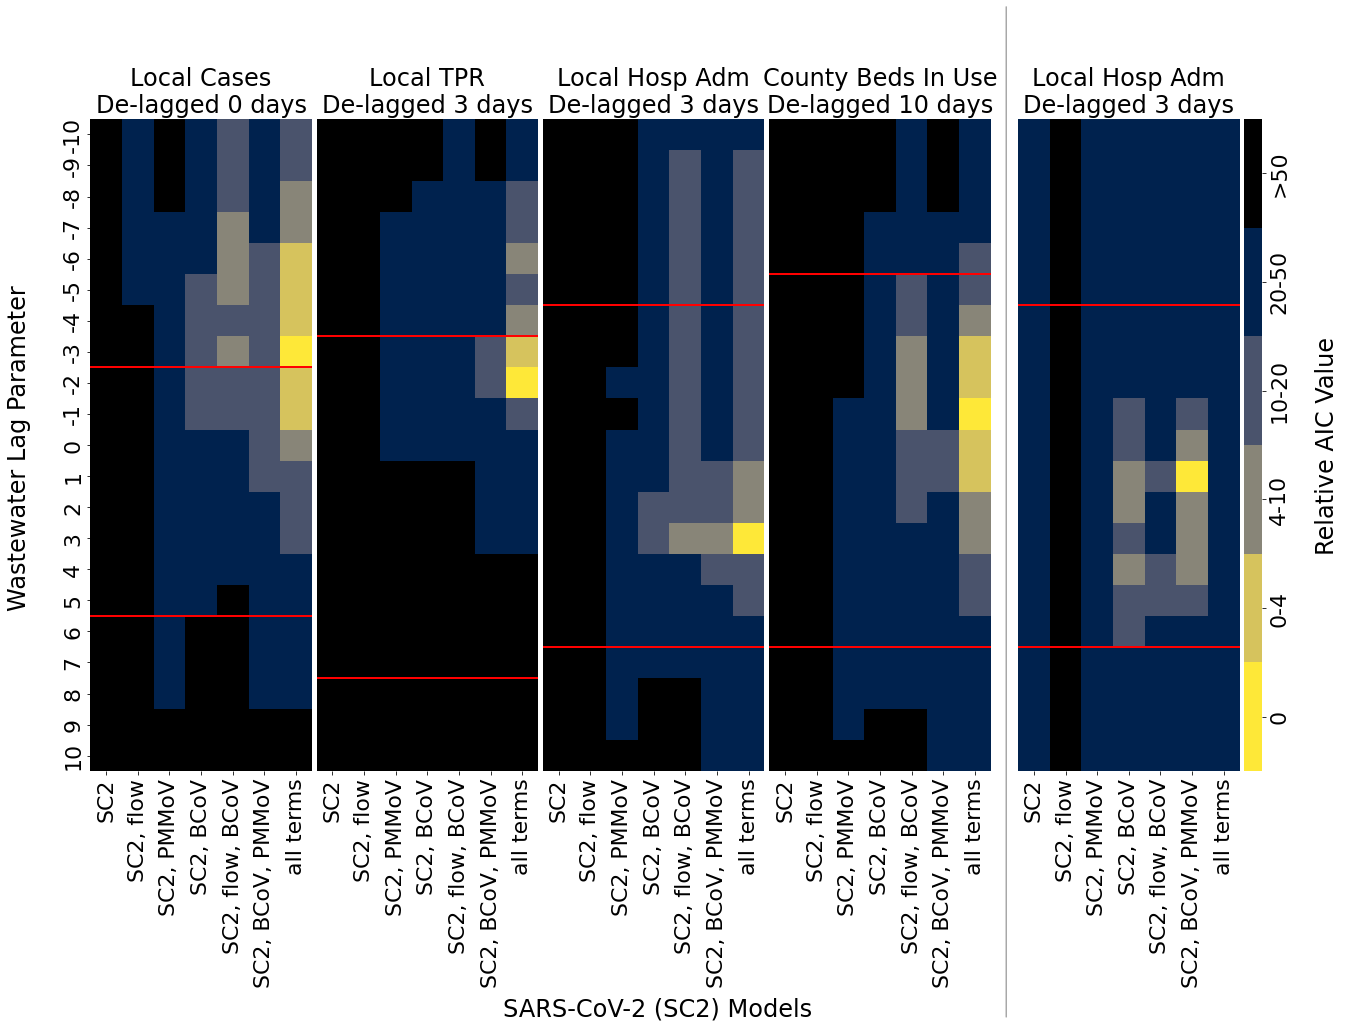

In [7]:
aic2 = pd.concat([aict2,aicf2[aicf2.prevind=='hospital admissions'].replace('hospital admissions','outofsample')])
fs1 = 22 # tick labels
fs2 = 24 # axis labels & axis titles
aicprevs = ['positive tests','test positivity rate','hospital admissions','Cook County beds in use','outofsample']
aic2.prevind=pd.Categorical(aic2.prevind,categories=aic2.prevind.unique(),ordered=True)
aic2.model=pd.Categorical(aic2.model,categories=aic2.model.unique(),ordered=True)
pivotedaic = aic2[(aic2.model.isin(models)) & (aic2.wwtp==wwtp)].pivot_table(index = ['lag'],
                         columns = ['prevind','model'],sort=False)
newmapaic = aic_colormap()
offset = {}
for prev in aic2.prevind.unique():
    offset[prev] = pivotedaic.aic.loc[:,(pivotedaic.aic.columns.get_level_values('prevind')==prev)].min().min()
    pivotedaic.aic.loc[:,(pivotedaic.aic.columns.get_level_values('prevind')==prev)] = pivotedaic.aic.loc[
        :,(pivotedaic.aic.columns.get_level_values('prevind')==prev)].sub(pivotedaic.aic.loc[
        :,(pivotedaic.aic.columns.get_level_values('prevind')==prev)].min().min(),axis=1).values
rel = ' - rel AIC across models and lags for each prev'

modtermdict = {'no correction':'SC2',
               'only flow':'SC2, flow',
               'pmmov norm':'SC2, PMMoV', 
               'only bcov norm':'SC2, BCoV',
               'bcov flow norm':'SC2, flow, BCoV',
               'pmmov bcov norm':'SC2, BCoV, PMMoV',
               'pm bc fl':'all terms'}
prevnamedict = {'positive tests':'Local Cases',
 'test positivity rate':'Local TPR',
 'hospital admissions':'Local Hosp Adm',
 'Cook County beds in use':'County Beds In Use',
 'outofsample':'Local Hosp Adm'}
nplots = len(aicprevs)
fig = plt.figure(figsize=(nplots*4+1,12))
gs = fig.add_gridspec(1, nplots+2, hspace=0.03, wspace=0.03,width_ratios=[1]*(nplots-1)+[0.08]+[1,0.08])
axs = gs.subplots()
for m,prevind in enumerate(aicprevs):
    if m<nplots-1:
        n=m
    else:
        n=m+1
    melted = pd.melt(pivotedaic['aic',prevind],var_name='model',value_name='aic',ignore_index=False)
    melted.aic = melted.aic.apply(lambda x:discrete_color_aic(x))
    melted.model=pd.Categorical(melted.model,categories=models,ordered=True)
    # Updates: allow for variably chosen models to show here...
    newpivotedaic = melted[(melted.model.str.contains('new')) & ~(melted.model.isin(
        [' new only flow aic',' new no correction aic',' new pmmov norm aic']))].pivot_table(index=['lag'],columns=['model'],sort=False)
    if m<nplots-1:
        sns.heatmap(newpivotedaic['aic'], cmap=newmapaic,cbar=False,vmin=-0.5,vmax=5.5,ax= axs[n])
    if m==nplots-1:
        sns.heatmap(newpivotedaic['aic'], cmap=newmapaic,vmin=-0.5,vmax=5.5,ax= axs[n],cbar_ax=axs[n+1])
    mymods = [modtermdict[m[4:-4]] for m in newpivotedaic.aic.columns.tolist()]
    uselags = newpivotedaic.aic.index.tolist()
    axs[n].set_xticks(np.linspace(0.5,0.5*(len(mymods)*2-1),len(mymods)))
    axs[n].set_xticklabels(mymods, fontsize = fs1)
    axs[n].set_xlabel('Model',fontsize=fs2)
    axs[n].set_yticks(np.linspace(0.5,0.5*(len(uselags)*2-1),len(uselags)))
    axs[n].set_yticklabels(uselags, fontsize = fs1)
    axs[n].set_xlabel('')
    axs[n].set_ylabel('')
    if n>0:
        axs[n].set_yticks([])
    # Updates: if lags is not every integer from -10 to 10, this does not show the right lines...
    axs[n].axhline(y=prevbounds[prevbounds.prevind==prevind.replace('outofsample','hospital admissions')].upper.iloc[0]+11,
                   color='r',linewidth=2) # upper
    axs[n].axhline(y=prevbounds[prevbounds.prevind==prevind.replace('outofsample','hospital admissions')].lower.iloc[0]+10,
                   color='r',linewidth=2) # lower
    if m==nplots-1:
        colorbar = axs[n+1]#.collections[0].colorbar
        colorbar.set_yticks([0,1,2,3,4,5])
        colorbar.set_yticklabels(['0','0-4', '4-10', '10-20', '20-50', '>50'],rotation=90,\
                                 verticalalignment='center',horizontalalignment='left',fontsize=fs1)
        plt.annotate('Relative AIC Value',xy=(1,1),xycoords='figure fraction',
                               xytext=(4, 2.5), textcoords='data',
                               horizontalalignment='left',verticalalignment='center',rotation=90,fontsize=fs2)
    axs[n].set_title(prevnamedict[prevind]+'\nDe-lagged '+str(int(prevlagdict[prevind.replace('outofsample','hospital admissions')]))+' days',fontsize=fs2)
axs[m].set_yticks([])
axs[m].set_xticks([])
axs[m].axis('off')
axs[m].annotate('', xy = (0.6, 1.175), xycoords='axes fraction',
                    xytext = (0.6, -0.38), textcoords='axes fraction',
                    arrowprops=dict(arrowstyle="-",color='tab:grey') )


fig.text(0.07, 0.5,'Wastewater Lag Parameter', va='center', rotation='vertical',fontsize=fs2)
fig.text(0.5, -.15, 'SARS-CoV-2 (SC2) Models', va='center', rotation='horizontal',ha='center',fontsize=fs2)
plt.show()

### Figure 5

Cook County beds in use
88.30778746766053 118.65871429393066 26.519081283524976
test positivity rate
53.07174978594701 40.886434363386066 29.44882525204329
hospital admissions
81.61612766343917 112.04843968482258 31.068939293893727
positive tests
55.75705440108976 107.37061402201466 9.97438434181958
Cook County beds in use
369.8499074959516 289.41049373263814 80.48362410068898
test positivity rate
302.0204600904773 243.84077634234905 75.81449001162538
hospital admissions
292.1268770600162 215.7991856157795 67.65622375569399
positive tests
167.1022953289147 122.98013368503655 66.90996781074602


/tmp/ipykernel_9332/3781002614.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([modtermdict[mod[4:-4]] for mod in np.array(aic2[mask].model)[np.r_[modelorder]]],rotation=90,fontsize=fs1)
/tmp/ipykernel_9332/3781002614.py:81: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_ins.set_xticklabels([modtermdict[mod[4:-4]].replace(' ','\n') for mod in np.array(aic2[mask].model)[np.r_[subsetorder]]],rotation=90,fontsize=fs4)
/tmp/ipykernel_9332/3781002614.py:116: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([modtermdict[mod[4:-4]] for mod in np.array(aic2[mask].model)[np.r_[modelorder]]],rotation=90,fontsize=fs1)


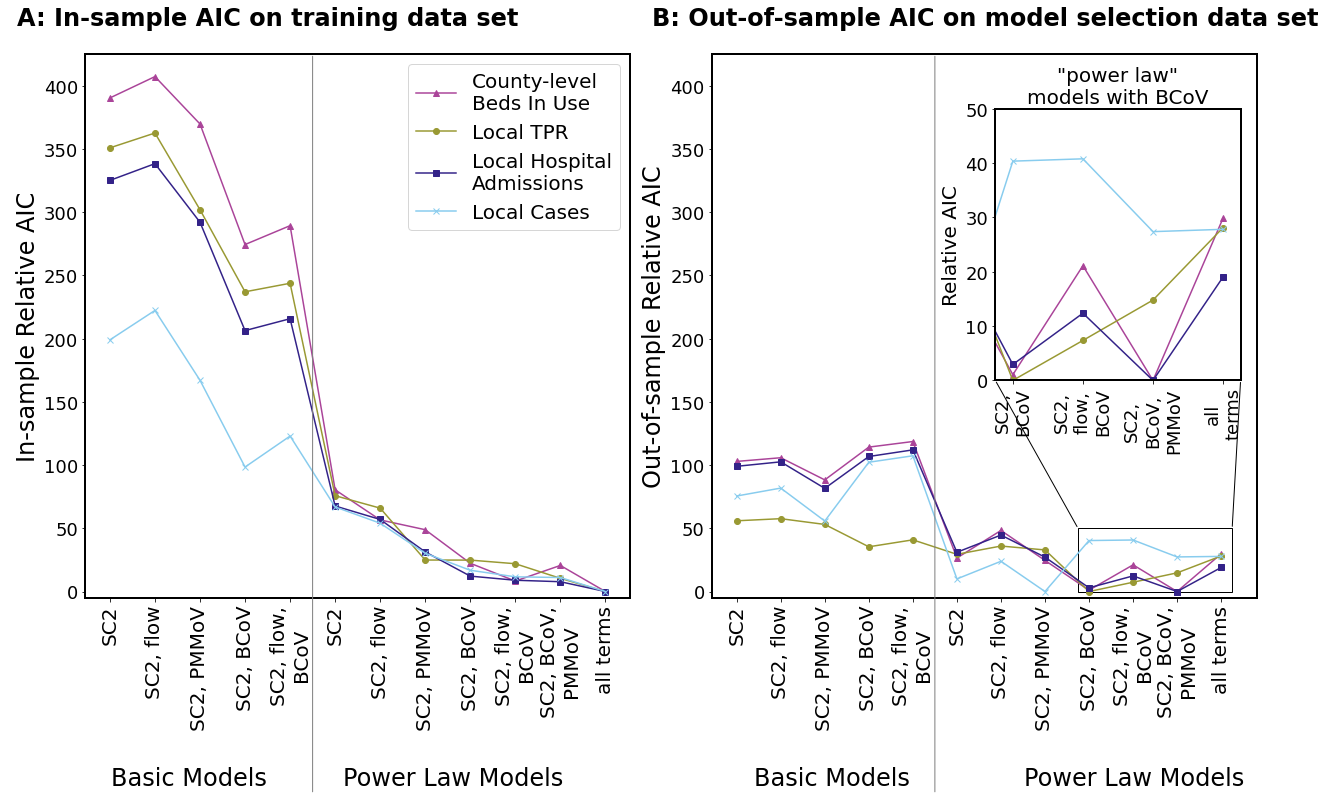

In [8]:
aic2 = aicf2.copy()
fs1 = 20 # big ticks
fs2 = 24 # big labels
fs3 = 20 # legend
fs4 = 18 # small ticks
fs5 = 20 # small labels & title
modtermdict = {'no correction':'SC2',
               'only flow':'SC2, flow',
               'pmmov norm':'SC2, PMMoV', 
               'only bcov norm':'SC2, BCoV',
               'bcov flow norm':'SC2, flow,\nBCoV',
               'pmmov bcov norm':'SC2, BCoV,\nPMMoV',
               'pm bc fl':'all terms'}
prevnamedict = {'positive tests':'Local Cases',
 'test positivity rate':'Local TPR',
 'hospital admissions':'Local Hospital\nAdmissions',
 'Cook County beds in use':'County-level\nBeds In Use'}
prevwwlagdict = {'positive tests':-2,
                'test positivity rate':-2,
                'hospital admissions':3,
                'Cook County beds in use':-1}

marks2 = marksparams
mycolors = mycolorscb

fig = plt.figure(figsize=(21,10))
gs = fig.add_gridspec(1, 2, wspace=.15)
axs = gs.subplots()
modelorder = [0,2,4,6,8,1,3,5,7,9,11,13]
subsetorder = [5,7,9,11,13]
aiclistdf = pd.DataFrame({'models':[]})
theseprev = ['Cook County beds in use','test positivity rate','hospital admissions','positive tests']
ax = axs[1]
for p,prev in enumerate(theseprev):
    mylag = prevwwlagdict[prev]
    mask = (aic2.prevind==prev) & (aic2.wwtp=='comb') & (aic2.lag==mylag)
    ax.plot(np.array(aic2[mask].model)[np.r_[modelorder]],
             np.array(aic2[mask].aic-np.min(aic2[mask].aic))[np.r_[modelorder]],marks2[p]+'-',color=mycolors[p],label=prevnamedict[prev])
    aiclist = np.array(aic2[mask].aic-np.min(aic2[mask].aic))[np.r_[modelorder]]
    aiclistdf = pd.merge(aiclistdf,pd.DataFrame({'models':np.array(aic2[mask].model)[np.r_[modelorder]],prev+' in':aiclist}),on='models',how='outer')
    print(prev)
    print(aiclist[2],aiclist[4],aiclist[5])
ax.add_patch(Rectangle((7.75,0), 3.5, 50, fill=None, alpha=1))
ax.set_ylim([-5,425])
ylim = ax.get_ylim()
ax.annotate('', xy = (4.5, ylim[-1]), xycoords='data',
                    xytext = (4.5, -160), textcoords='data',
                    arrowprops=dict(arrowstyle="-",color='tab:grey') )
ax.annotate('Basic Models',xy=(1,1),xycoords='figure fraction',
               xytext=(.125, .015), textcoords='figure fraction',
               horizontalalignment='center',verticalalignment='bottom',fontsize=fs2)
ax.annotate('Power Law Models',xy=(1,1),xycoords='figure fraction',
               xytext=(.3, .015), textcoords='figure fraction',
               horizontalalignment='center',verticalalignment='bottom',fontsize=fs2)
ax.set_xticklabels([modtermdict[mod[4:-4]] for mod in np.array(aic2[mask].model)[np.r_[modelorder]]],rotation=90,fontsize=fs1)
ax.set_ylabel('Out-of-sample Relative AIC',fontsize=fs2)
ax.yaxis.set_tick_params(labelsize=fs4)
ax.set_xlabel(' ')
inset = (.52,.4,.45,.5)
ax_ins = inset_axes(ax, width="100%", height="100%",bbox_to_anchor=inset,bbox_transform=ax.transAxes, loc=3, borderpad=0)
for p,prev in enumerate(theseprev):
    mylag = prevwwlagdict[prev]
    mask = (aic2.prevind==prev) & (aic2.wwtp=='comb') & (aic2.lag==mylag)
    ax_ins.plot(np.array(aic2[mask].model)[np.r_[subsetorder]],
             np.array(aic2[mask].aic-np.min(aic2[mask].aic))[np.r_[subsetorder]],marks2[p]+'-',color=mycolors[p],label=prevnamedict[prev])
ax_ins.set_ylabel('Relative AIC',fontsize=fs5)
ax_ins.yaxis.set_tick_params(labelsize=fs4)
ax_ins.set_xlim([0.75,4.25])
ax_ins.set_title("\"power law\"\nmodels with BCoV",fontsize=fs5)
ax_ins.set_ylim([0,50])
# ax_ins.set_xticklabels([modtermdict[mod[4:-4]].replace(' ','\n') for mod in models[7:]],rotation=90,fontsize=fs4)
ax_ins.set_xticklabels([modtermdict[mod[4:-4]].replace(' ','\n') for mod in np.array(aic2[mask].model)[np.r_[subsetorder]]],rotation=90,fontsize=fs4)

ax.annotate('', xy = (7.75, 50), xycoords='data',
                    xytext = (0.52, .4), textcoords='axes fraction',
                    arrowprops=dict(arrowstyle="-") )
ax.annotate('', xy = (11.25, 50), xycoords='data',
                    xytext = (0.97, 0.4), textcoords='axes fraction',
                    arrowprops=dict(arrowstyle="-") )



aic2 = aict2.copy()
ax = axs[0]
for p,prev in enumerate(theseprev):
    mylag = prevwwlagdict[prev]
    mask = (aic2.prevind==prev) & (aic2.wwtp=='comb') & (aic2.lag==mylag)
    ax.plot(np.array(aic2[mask].model)[np.r_[modelorder]],
             np.array(aic2[mask].aic-np.min(aic2[mask].aic))[np.r_[modelorder]],marks2[p]+'-',color=mycolors[p],label=prevnamedict[prev])
    aiclist = np.array(aic2[mask].aic-np.min(aic2[mask].aic))[np.r_[modelorder]]
    aiclistdf = pd.merge(aiclistdf,pd.DataFrame({'models':np.array(aic2[mask].model)[np.r_[modelorder]],prev+' out':aiclist}),on='models',how='outer')
    print(prev)
    print(aiclist[2],aiclist[4],aiclist[5])
# ax.add_patch(Rectangle((7.75,0), 3.5, 35, fill=None, alpha=1))
ax.set_ylim([-5,425])
ylim = ax.get_ylim()
ax.annotate('', xy = (4.5, ylim[-1]), xycoords='data',
                    xytext = (4.5, -160), textcoords='data',
                    arrowprops=dict(arrowstyle="-",color='tab:grey') )
ax.annotate('Basic Models',xy=(1,1),xycoords='figure fraction',
               xytext=(.55, .015), textcoords='figure fraction',
               horizontalalignment='center',verticalalignment='bottom',fontsize=fs2)
ax.annotate('Power Law Models',xy=(1,1),xycoords='figure fraction',
               xytext=(.75, .015), textcoords='figure fraction',
               horizontalalignment='center',verticalalignment='bottom',fontsize=fs2)
ax.legend(loc='upper right',fontsize=fs3)
ax.set_xticklabels([modtermdict[mod[4:-4]] for mod in np.array(aic2[mask].model)[np.r_[modelorder]]],rotation=90,fontsize=fs1)
ax.set_ylabel('In-sample Relative AIC',fontsize=fs2)
ax.yaxis.set_tick_params(labelsize=fs4)
ax.set_xlabel(' ')
fig.text(0.08, 0.93, 'A: In-sample AIC on training data set', va='center', rotation='horizontal',fontsize=fs2,weight='bold')
fig.text(0.5, 0.93, 'B: Out-of-sample AIC on model selection data set', va='center', rotation='horizontal',fontsize=fs2,weight='bold')
plt.show()

### Figure 6

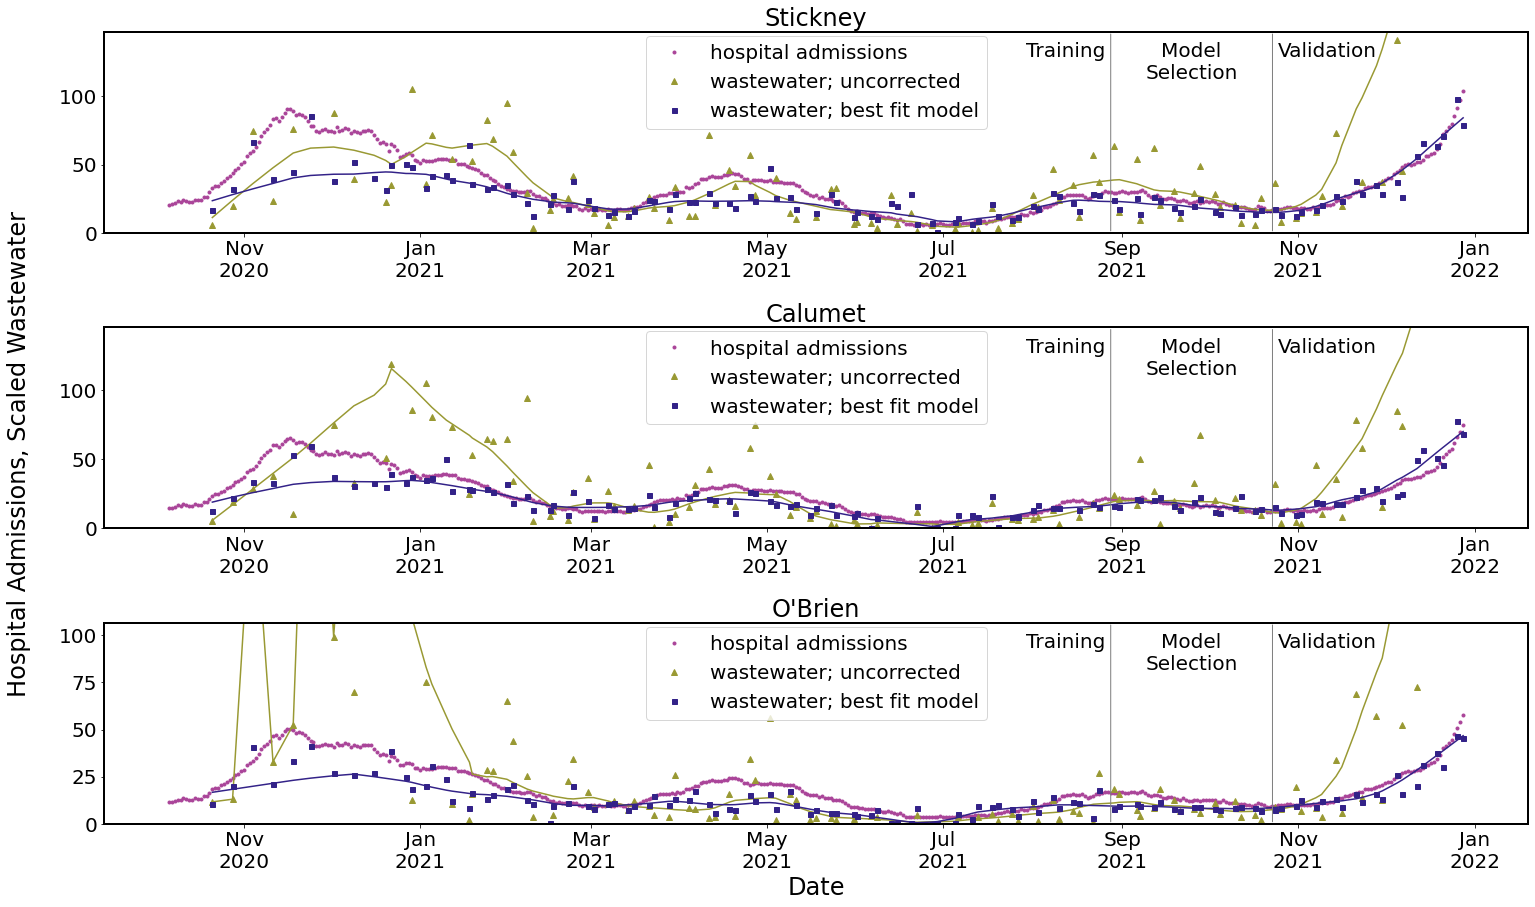

In [9]:
fs1 = 20 # tick labels
fs2 = 24 # axis labels & titles
fs3 = 20 # legend
fig = plt.figure(figsize=(21,13))
mycolors = mycolorscb
marks = markstraj
for j,catch in enumerate(catches_shortlist):
    plt.subplot(len(catches_shortlist),1,j+1)
    ax = plt.gca()
    startdate = wbe[(wbe.catchment==catch) & (wbe.date>=prevdf.date.min())].date.min()-pd.Timedelta(15,'days')
    enddate = wbe[(wbe.catchment==catch) & (wbe.date<=prevdf.date.max())].date.max()
    maskp = (prevdf.catchment==catch.replace('Stickney Full','Stickney')) & (prevdf.date>=startdate) & (prevdf.date<=enddate)
    maskw = (wbe.catchment==catch) & (wbe.date>=startdate) & (wbe.date<=enddate)
    p = ax.plot(prevdf[maskp].date,prevdf[maskp][useprev_single],'.',color=mycolors[0],label=useprev_single)
    ws = []
    for n,(ww,label) in enumerate(zip(usewws,['uncorrected','best fit model'])):
        ws = ax.plot(wbe[maskw].date,wbe[maskw][ww],marks[np.mod(n+1,3)],
                markersize=msize[np.mod(n+1,3)],color=mycolors[n+1],label='wastewater; '+label)
        smooth = sm.nonparametric.lowess(endog=wbe[maskw][ww], exog=mdates.date2num(wbe[maskw].date), frac= 0.1)
        ax.plot(smooth[:,0],smooth[:,1],'-',color=mycolors[n+1])
        p+=ws
        ax.set_ylim([0,ax.get_ylim()[1]/2])
        ax.xaxis.set_tick_params(labelsize=fs1)
        ax.yaxis.set_tick_params(labelsize=fs1)
        labs = [l.get_label() for l in p]
        ax.legend(p,labs,bbox_to_anchor=(.5,1),loc='upper center',borderaxespad=.2,fontsize=fs3)
        ax.set_title(catch.replace(' Full','').replace('OBrien',"O'Brien"),fontsize=fs2)
        ax.xaxis.set_major_formatter(DateFormatter("%b\n%Y"))
    ylim = ax.get_ylim()
    for d,align in zip(['2021-08-28','2021-10-23'],['right','right']):
        ax.annotate('', xy = (pd.to_datetime(d, format = '%Y-%m-%d'), ylim[0]), xycoords='data',
                    xytext = (pd.to_datetime(d, format = '%Y-%m-%d'), ylim[-1]), textcoords='data',
                    arrowprops=dict(arrowstyle="-",color='tab:grey'),
                    horizontalalignment='left', verticalalignment='top',fontsize=16)
    for d,txt,align in zip(['2021-08-26','2021-09-25','2021-10-25'],
                           ['Training','Model\nSelection','Validation'],
                           ['right','center','left']):
        ax.annotate(txt,xy = (pd.to_datetime(d, format = '%Y-%m-%d'), ylim[-1]*.95), xycoords='data',
                xytext = (pd.to_datetime(d, format = '%Y-%m-%d'), ylim[-1]*.95), textcoords='data',
                horizontalalignment=align, verticalalignment='top',fontsize=fs3,rotation='horizontal')
#     ax1.set_ylabel('Hospital\nAdmissions,\nScaled\nWastewater')
ax.set_xlabel('Date',fontsize=fs2)
fig.text(-.02, 0.5, 'Hospital Admissions, Scaled Wastewater', va='center', rotation='vertical',fontsize=fs2)
plt.tight_layout()
plt.show()

### Figure 7

In [10]:
wbe1 = pd.read_csv(wbefile, parse_dates=['date'])
wbe1.rename(columns={'wrp':'catchment','sarscov2':'raw_data'},inplace=True)
datatype = usewws[-1]

paramdfsmallnone,aicdfsmall,pdfsmall,aicfulldfsmall = FitModelParameters(wbe1[wbe1.date<'2021-08-28'],prevdf,['comb'],['hospital admissions'],
                                                 ['raw_data'],['Egan','Hanover','Kirie','Lemont'],'2021-08-28',
                                                 [3],ww_lod,{'hospital admissions':3},prevenddate)
display(paramdfsmallnone[paramdfsmallnone.fit=='orig-raw_data'])
wbe1 = CalculateModelFitsFromParams(wbe1,paramdf,ww_lod,wwtp,lag,useprev_single,scaleparam=False)                               
paramdfsmallfixed,aicdfsmall,pdfsmall,aicfulldfsmall = FitModelParameters(wbe1[wbe1.date<'2021-08-28'],prevdf,['comb'],['hospital admissions'],
                                                 [datatype],['Egan','Hanover','Kirie','Lemont'],'2021-08-28',
                                                 [3],ww_lod,{'hospital admissions':3},prevenddate)
display(paramdfsmallfixed[paramdfsmallfixed.fit=='orig-'+datatype])

lag: 3 , catch:  comb


wwtp              prevind            fit  feature lag    params        lb  \
0  comb  hospital admissions  orig-raw_data     Egan   3  4.862366  4.683191   
1  comb  hospital admissions  orig-raw_data  Hanover   3  4.849260  4.670085   
2  comb  hospital admissions  orig-raw_data    Kirie   3  4.340396  4.161221   
3  comb  hospital admissions  orig-raw_data   Lemont   3  4.925912  4.754704   

         ub  
0  5.041541  
1  5.028435  
2  4.519571  
3  5.097120

lag: 3 , catch:  comb


wwtp              prevind                   fit  feature lag    params  \
0  comb  hospital admissions  orig-pmmov_bcov_norm     Egan   3  1.605586   
1  comb  hospital admissions  orig-pmmov_bcov_norm  Hanover   3  1.635468   
2  comb  hospital admissions  orig-pmmov_bcov_norm    Kirie   3  1.342523   
3  comb  hospital admissions  orig-pmmov_bcov_norm   Lemont   3  2.293620   

         lb        ub  
0  1.534827  1.676345  
1  1.562658  1.708278  
2  1.265011  1.420036  
3  2.187481  2.399758

Using lag = 3


catchment  Raw SARS-CoV-2  Corrected Wastewater  % change
0  Stickney          0.3742                0.1977    0.4717
1   Calumet          0.4250                0.1776    0.5821
2    OBrien          0.5070                0.2371    0.5323
3  Stickney          0.4519                0.1310    0.7101
4   Calumet          0.5183                0.1141    0.7799
5    OBrien          0.4539                0.1675    0.6310
6      Egan          0.3390                0.1193    0.6481
7   Hanover          0.4003                0.2241    0.4402
8     Kirie          0.3323                0.1328    0.6004
9    Lemont          0.5052                0.1640    0.6754

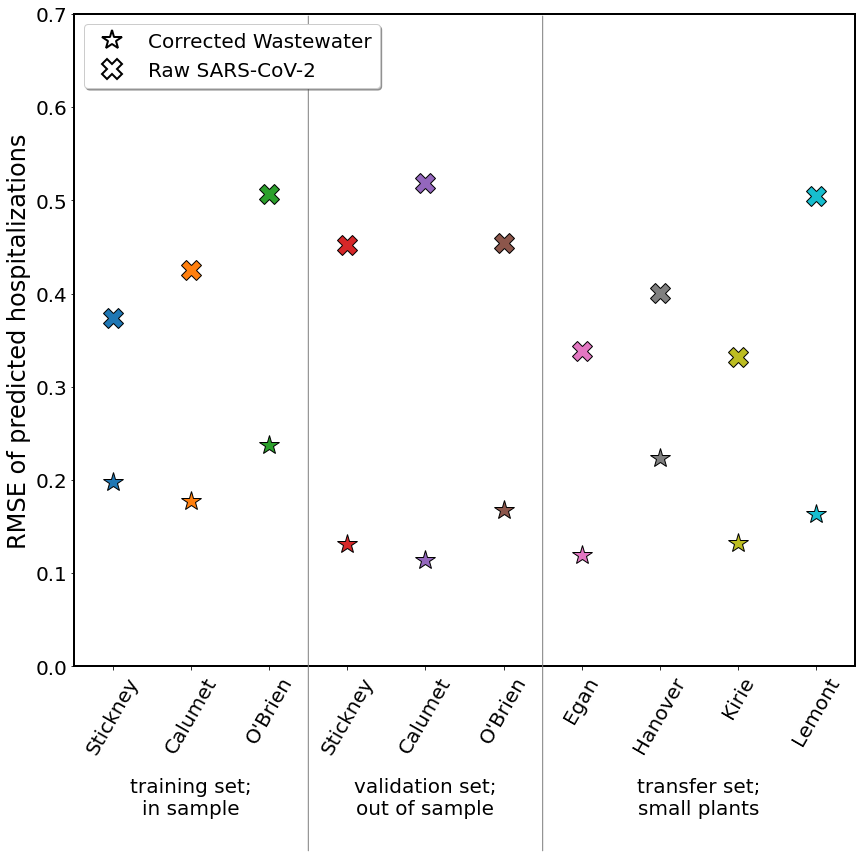

In [11]:
fs1 = 20 # tick labels 
fs2 = 24 # axis label
fs3 = 20 # legend & training annotation
mycolors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:grey','tab:olive','tab:cyan']

uselags = np.arange(-10,10,1)
show_corr_plot=False
if show_corr_plot:
    plt.figure(figsize=(14,7))
mylags = pd.DataFrame()
mycorrs = pd.DataFrame()
mylags['catchment'] = catches_correlation
mycorrs['catchment'] = catches_correlation
for (ww,label,lin) in zip(usewws,wwlabs,['--','-']):
    mylag = []
    mycorr = []
    for n,catch in enumerate(catches_correlation):
        if n<3:
            startdate = '2020-10-16'
            enddate = '2021-08-28'
        elif n<6:
#             startdate = '2021-09-11'
            startdate = '2021-10-23'
            enddate = '2022-01-01'
        else:
            startdate = '2020-10-16'
            enddate = '2022-01-01'
        maskp = (prevdf.catchment==catch.replace('Stickney Full','Stickney')) & (prevdf[useprev_single]>0)
        maskw = (wbe.catchment==catch) & (wbe.date>=startdate) & (wbe.date<=enddate) & (wbe.orig_raw>ww_lod)
        wdf = wbe[maskw][['date',ww]].copy()
        if catch in ['Egan','Kirie','Hanover','Lemont']:
            if ww == 'orig-raw_data':
                wdf[ww] = wdf[ww]*10**(-paramdfsmallnone[(paramdfsmallnone.fit=='orig-raw_data') & (paramdfsmallnone.feature==catch)].params.iloc[0])
            else:
                wdf[ww] = wdf[ww]*10**(-paramdfsmallfixed[(paramdfsmallfixed.fit=='orig-'+datatype) & (paramdfsmallfixed.feature==catch)].params.iloc[0])
        pdf = prevdf[maskp][['date',useprev_single]].copy()
        wdf[ww] = np.log10(wdf[ww])
        pdf[useprev_single] = np.log10(pdf[useprev_single])
        mycors = crosscorrW(wdf,pdf,lags=uselags+prevlagdict[useprev_single],rmse=True)
        if show_corr_plot:
            plt.plot(uselags+prevlagdict[useprev_single],mycors,lin,color=mycolors[n],label=catch+', '+ww)
        mylag.append(uselags[np.argmax(mycors)]+prevlagdict[useprev_single])
        mycorr.append(mycors[uselags==lag])
    mylags[label] = np.round(mylag,4)
    mycorrs[label] = np.round(mycorr,4)
# mycorrs['% change'] = np.round((mycorrs[wwlabs[1]]-mycorrs[wwlabs[0]])/mycorrs[wwlabs[1]],4)
mycorrs['% change'] = np.round((mycorrs[wwlabs[0]]-mycorrs[wwlabs[1]])/mycorrs[wwlabs[0]],4)
print('Using lag =',lag)
# display(mylags)
display(mycorrs)
if show_corr_plot:
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()
# fig,ax = plt.subplots(figsize=(8,5))
fig,ax = plt.subplots(figsize=(14,12))
for n,catch in enumerate(catches_correlation):
    for (ww,star) in zip(wwlabs,['X','*']):
        plt.plot(n,mycorrs[ww].iloc[n],star,markeredgecolor='black',color=mycolors[n],markersize=20)
plt.plot(10,60,'*',color='black',markersize=20,markeredgewidth=2,markerfacecolor='None',label=wwlabs[1])
plt.plot(10,50,'X',color='black',markersize=20,markeredgewidth=2,markerfacecolor='None',label=wwlabs[0])
# if box!=None:
ax.annotate('', xy = (2.5, 0.7), xycoords='data',
                    xytext = (2.5, -0.2), textcoords='data',
                    arrowprops=dict(arrowstyle="-",color='tab:grey'),
                    horizontalalignment='left', verticalalignment='top',fontsize=16)
ax.annotate('', xy = (5.5, 0.7), xycoords='data',
                    xytext = (5.5, -0.2), textcoords='data',
                    arrowprops=dict(arrowstyle="-",color='tab:grey'),
                    horizontalalignment='left', verticalalignment='top',fontsize=16)
for loc,txt in zip([0.15,0.45,0.8],
                   ['training set;\nin sample','validation set;\nout of sample',
                    'transfer set;\nsmall plants']):
#         ax.add_patch(Rectangle((box[0],box[1]), box[2], box[3], fill=None, alpha=1))
    plt.annotate(txt,xy=(1,1),xycoords='figure fraction',
                   xytext=(loc,-0.17), textcoords='axes fraction',
                   horizontalalignment='center',verticalalignment='top',fontsize=fs3)
ax.set_xlim([-.5,len(catches_correlation)-.5])
ax.set_xticks(range(len(catches_correlation)))
ax.set_xticklabels([catch.replace(' Full','').replace('OBrien',"O'Brien") for catch in catches_correlation],
                   rotation=60,fontsize=fs1)
ax.yaxis.set_tick_params(labelsize=fs1)
ax.set_ylim([0,0.7])
ax.set_ylabel('RMSE of predicted hospitalizations',fontsize=fs2)
ledge = plt.legend(loc='upper left', shadow=True, fancybox=True, numpoints=1,ncol=1,fontsize=fs3)#bbox_to_anchor=(0.0, 0.83)
plt.show()
 

### Figure 8

In [12]:
fulldf = rolling_trend_analysis(wbe,prevdf,catches_shortlist,useprevs_trendflags,usewws,
                                firstdate,lastdate,num_weeks_ww,num_weeks_prev,showfig=False)
datedf = trend_trajectory(fulldf,catches_shortlist,useprevs_trendflags,usewws,prev_CI,ww_CI,
                          prev_daythresh,ww_daythresh,num_weeks_ww,firstdate,lastdate,showfig=False)

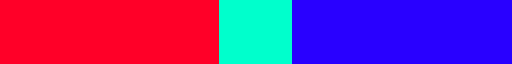

In [13]:
base = plt.cm.get_cmap('gist_rainbow')
color_list = base(np.array([0,0,0,.55,.8,.8,.8]))
newmap = ListedColormap(color_list,'newmap')

newmap

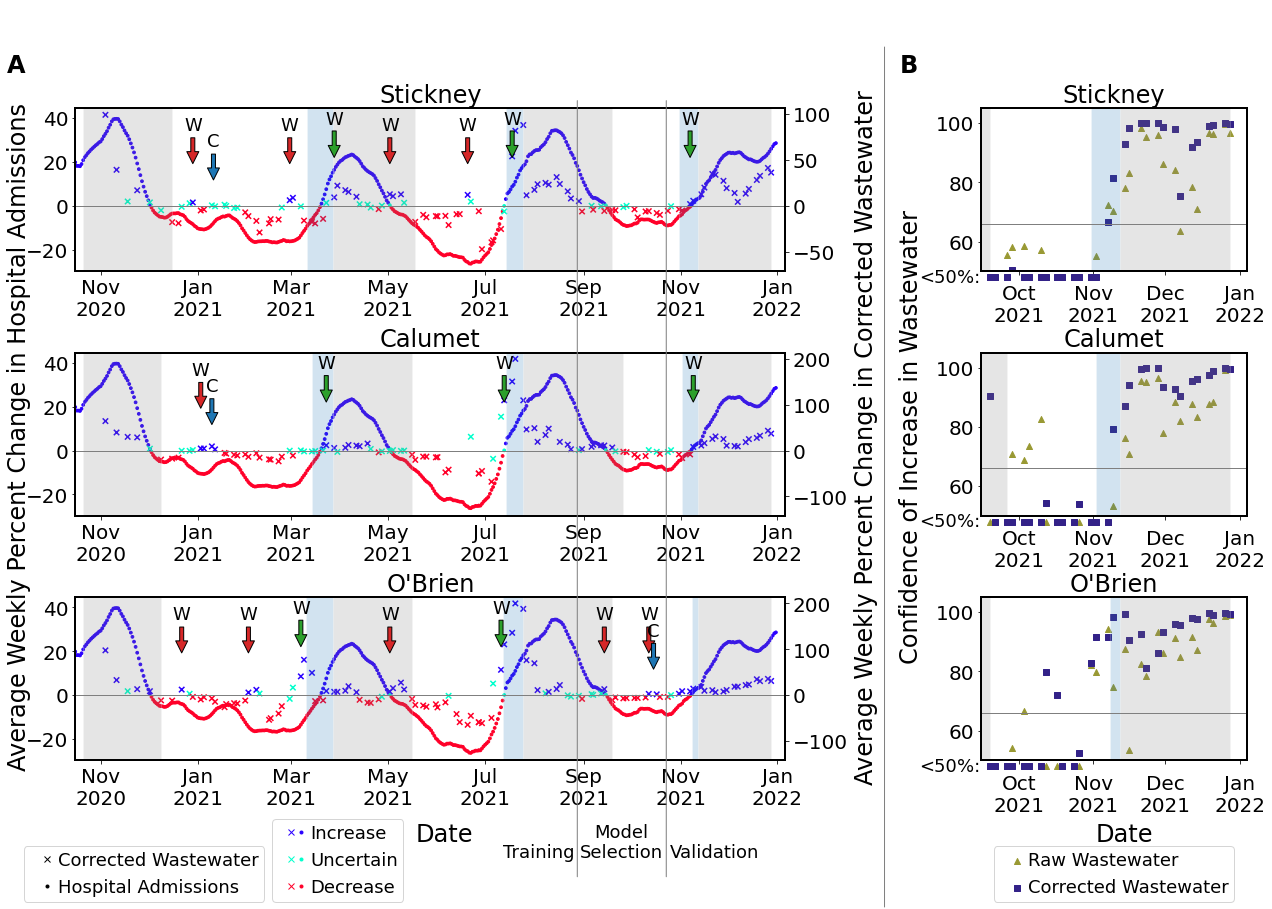

In [14]:
fs1 = 20 # tick labels
fs2 = 24 # axis labels
fs3 = 18 # legend
fs4 = 18 # flags
wws = usewws    
num_weeks = num_weeks_ww
add_surge_arrows=False
add_surge_arrows2=False
n = 0
datatype = usewws[-1]
showdate = '2021-09-15'
datalabel = 'Corrected Wastewater'
fig = plt.figure(figsize=(21,12))
gs = fig.add_gridspec(len(catches_shortlist), 2, wspace=.4, hspace=.5,width_ratios=[8,3])
axs = gs.subplots()
surgedf = pd.DataFrame(columns={'catchment','date','source','surge'})
for c, catch in enumerate(catches_shortlist):
    for m,usedata in enumerate([useprev_single,datatype]):
        mdf2 = fulldf[(fulldf.datatype==usedata) & (fulldf.catchment==catch)].copy()
        if m==0: # if we're doing the prevalence indicator, not the wastewater indicator...
            ax = axs[c,0]
            ax.scatter(mdf2.date,np.minimum(mdf2[f'Percent Change Weekly over {num_weeks} weeks'],200),\
                       c=mdf2[f'Confidence of {num_weeks} week Trend'].apply(lambda x:discrete_color(x)),\
                            s=30,cmap=newmap,marker='.')
            ax.set_title(catch.replace(' Full','').replace('OBrien',"O'Brien"),fontsize=fs2)
            ylim = ax.get_ylim()
            ax.set_ylim(-ylim[1]/1.5,ylim[1])
            ax.xaxis.set_tick_params(labelsize=fs1)
            ax.yaxis.set_tick_params(labelsize=fs1)
        else: # if we're doing a wastewater indicator
            ax = axs[c,0].twinx()
            sp = ax.scatter(mdf2.date,np.minimum(mdf2[f'Percent Change Weekly over {num_weeks} weeks'],200),\
                            c=mdf2[f'Confidence of {num_weeks} week Trend'].apply(lambda x:discrete_color(x)),\
                            s=30,cmap=newmap,marker='x')
            ax.axhline(y=0, xmin=0, xmax=1, color='tab:grey', linestyle='-', linewidth=1)
            ylim = ax.get_ylim()
            ax.set_ylim(-ylim[1]/1.5,ylim[1])
            ax.set_xbound(lower=mdates.date2num(datetime.datetime.strptime(firstdate, '%Y-%m-%d')-pd.Timedelta(5,'days')),\
                                 upper=mdates.date2num(datetime.datetime.strptime(lastdate, '%Y-%m-%d')+pd.Timedelta(5,'days')))
            if c==2: # if it's the first one, do this stuff so the first one has a legend.
                ax.plot(0,0,'x',color='black',label='Corrected Wastewater')
                ax.plot(0,0,'.',color='black',label=useprev_single.replace('hospital admissions','Hospital Admissions'))
                l1 = ax.legend(bbox_to_anchor=(-0.08,-0.9),loc='lower left',fontsize=fs3,borderaxespad=.3,\
                               handletextpad=-.4,borderpad=.3)
                ax1 = ax
                p1, = ax1.plot(0,0,'x',color=newmap.colors[6])
                p2, = ax1.plot(0,0,'.',color=newmap.colors[6])
                p3, = ax1.plot(0,0,'x',color=newmap.colors[3])
                p4, = ax1.plot(0,0,'.',color=newmap.colors[3])
                p5, = ax1.plot(0,0,'x',color=newmap.colors[0])
                p6, = ax1.plot(0,0,'.',color=newmap.colors[0])
                ax.add_artist(l1)
                l = ax1.legend([(p1, p2), (p3, p4), (p5, p6)],\
                               ['Increase', 'Uncertain','Decrease'],\
                               handler_map={tuple: HandlerTuple(ndivide=None,pad=-.9)},borderaxespad=.3,\
                               bbox_to_anchor=(0.27,-0.9),loc='lower left',fontsize=fs3,handletextpad=-.2,borderpad=.3)
            # This is where we start ading the shaded regions and arrow flags, using fulldf and datedf information.
            date0 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata)].iloc[0].date
            date2 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==useprev_single) & 
                       (fulldf.date>date0.strftime('%Y-%m-%d')) & 
                       (fulldf[f'Confidence of {num_weeks} week Trend']<66)].iloc[0].date
            date3 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata) & 
                           (fulldf.date>=date2.strftime('%Y-%m-%d')) &
                           (fulldf[f'Confidence of {num_weeks} week Trend']<34)].iloc[0].date
            # This is the first grey area, from the first date to the "end" of that region.
            plt.axvspan(date0,date3, facecolor='tab:grey',edgecolor='white', alpha=.2)
            h = ax.get_ylim()
            # Now we'll loop over the flagged dates in the bedsused column.  These are the (three) major surges.
            numbeddates = len(datedf[catch+f' {useprevs_trendflags[-1]} {num_weeks}wk'].dropna())
            for d,mydateb in enumerate(datedf[catch+f' {useprevs_trendflags[-1]} {num_weeks}wk'].dropna()):
                surgedf = pd.concat([surgedf,pd.DataFrame({
                    'catchment':catch.replace(' Full',''),'date':mydateb.date(),
                    'source':useprevs_trendflags[-1].split(' ')[1],'surge':str(mydateb.date())+'-surge'},index=[0])],axis=0,ignore_index=True)
                if add_surge_arrows:
                    ax.annotate('B',xy=(mydateb, h[0]+(.68)*(h[1]-h[0])), xycoords='data',
                        xytext=(mydateb, h[0]+(.98)*(h[1]-h[0])), textcoords='data',
                        arrowprops=dict(facecolor=mycolors[8], shrink=0.05),
                        horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                # 3 prevalence columns to look at
                cols = ['date']+[catch+f' {pr} {num_weeks_prev}wk' for pr in useprevs_trendflags]
                df1 = datedf[cols].set_index('date').dropna(how='all').reset_index()
                # first date that is triggered in one of the prev columns that is 
                # less than 21 days before the beds date for the current surge.
                date1 = df1[df1.date+datetime.timedelta(days=21)>mydateb.strftime('%Y-%m-%d')].iloc[0].date
                # shade this region from that date to the beds date in blue.
                plt.axvspan(date1,mydateb, facecolor='tab:blue', edgecolor='white',alpha=.2)
                # Now 4 columns - the three prev columns plus the wastewater column.
                cols = ['date',catch+' '+usedata+f' {num_weeks}wk']+ [catch+f' {pr} {num_weeks_prev}wk' for pr in useprevs_trendflags]
                df1 = datedf[cols].set_index('date').dropna(how='all').reset_index()
                # Now this is the first date in all those columns, including ww, that is less than 21 days before the beds date.
                date1 = df1[df1.date+datetime.timedelta(days=21)>mydateb.strftime('%Y-%m-%d')].iloc[0].date
                # This is just dates that are after the the last date (from the previous surge) 
                # that sensitive admissions had an increase, 
                # but before the beginning of the next surge.  
                # So this will be dates where admissions or cases get shown, and where ww is shown with red.
#                     df2 = df1[(df1.date>date2) & (df1.date<date1)].copy()
                df2 = df1[(df1.date-datetime.timedelta(days=5)>date0) & (df1.date<date1)].copy()
                # Loop over wastewater dates where the date is within the range of associated with the surge, label green.
                for mydate in df1[(df1.date>=date1) & (df1.date-datetime.timedelta(days=5)<mydateb)][catch+' '+usedata+f' {num_weeks}wk'].dropna():
                    ax.annotate('W',xy=(mydate, h[0]+.69*(h[1]-h[0])), xycoords='data',
                        xytext=(mydate, h[0]+.99*(h[1]-h[0])), textcoords='data',
                        arrowprops=dict(facecolor='tab:green', shrink=0.04),
                        horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                    surgedf = pd.concat([surgedf,pd.DataFrame({
                        'catchment':catch.replace(' Full',''),'date':mydate.date(),
                        'source':'wastewater','surge':str(mydateb.date())+'-surge'},index=[0])],axis=0,ignore_index=True)
                # Loop over wastewater dates where the date is out of that range, label red.
                for mydate in df2[catch+' '+usedata+f' {num_weeks}wk'].dropna():
                    ax.annotate('W',xy=(mydate, h[0]+.65*(h[1]-h[0])), xycoords='data',
                        xytext=(mydate, h[0]+.95*(h[1]-h[0])), textcoords='data',
                        arrowprops=dict(facecolor='tab:red', shrink=0.05),
                        horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                    surgedf = pd.concat([surgedf,pd.DataFrame({
                        'catchment':catch.replace(' Full',''),'date':mydate.date(),
                        'source':'wastewater','surge':str(mydateb.date())+', pre:'+str(mydate.date())},
                        index=[0])],axis=0,ignore_index=True)
                # Loop over cases and admissions dates that are out of that range, label.
                for p,(mydat,ca) in enumerate(zip(useprevs_trendflags[:-1],plabs)):
                    for mydate in df2[catch+' '+mydat+f' {num_weeks}wk'].dropna():
                        ax.annotate(ca,xy=(mydate, h[0]+(.55-p*.1)*(h[1]-h[0])), xycoords='data',
                            xytext=(mydate, h[0]+(.85-p*.1)*(h[1]-h[0])), textcoords='data',
                            arrowprops=dict(facecolor=mycolors[p*4], shrink=0.05),
                            horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                        surgedf = pd.concat([surgedf,pd.DataFrame({
                            'catchment':catch.replace(' Full',''),'date':mydate.date(),
                            'source':mydat.split(' ')[1],'surge':str(mydateb.date())+', pre:'+str(mydate.date())},
                            index=[0])],axis=0,ignore_index=True)
                for p,(mydat,ca) in enumerate(zip(useprevs_trendflags[:-1],plabs)):
                    for mydate in df1[(df1.date>=date1) & (df1.date<mydateb)][catch+' '+mydat+' 4wk'].dropna():
                        if add_surge_arrows:
                            ax.annotate(ca,xy=(mydate, h[0]+(.55-p*.1)*(h[1]-h[0])), xycoords='data',
                                xytext=(mydate, h[0]+(.85-p*.1)*(h[1]-h[0])), textcoords='data',
                                arrowprops=dict(facecolor=mycolors[p*4+1], shrink=0.05),
                                horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                        surgedf = pd.concat([surgedf,pd.DataFrame({
                            'catchment':catch.replace(' Full',''),'date':mydate.date(),
                            'source':mydat.split(' ')[1],'surge':str(mydateb.date())+'-surge'},
                            index=[0])],axis=0,ignore_index=True)
                # Get the range for the next gray band.
                if d<numbeddates-1:
                    date2 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==useprev_single) & 
                               (fulldf.date>mydateb.strftime('%Y-%m-%d')) & 
                               (fulldf[f'Confidence of {num_weeks} week Trend']<66)].iloc[0].date
                    date3 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata) & 
                                   (fulldf.date>=date2.strftime('%Y-%m-%d')) &
                                   (fulldf[f'Confidence of {num_weeks} week Trend']<34)].iloc[0].date
                    plt.axvspan(mydateb,date3, facecolor='tab:grey',edgecolor='white', alpha=.2)
                    date0 = mydateb
                else:
                    date2 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata)].iloc[-1].date
                    date3 = date2
#                     plt.axvline(x=mydateb, color='white')
                    plt.axvspan(mydateb,date3, facecolor='tab:grey', edgecolor='white',alpha=.2)
#                     print(catch,date1,mydateb,date2,date3)
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
            ax.xaxis.set_major_formatter(DateFormatter("%b\n%Y"))
            ax.set_xbound(lower=mdates.date2num(datetime.datetime.strptime(firstdate, '%Y-%m-%d')+pd.Timedelta(15,'days')),\
                                 upper=mdates.date2num(datetime.datetime.strptime(lastdate, '%Y-%m-%d')+pd.Timedelta(5,'days')))
    if c==2:
        ylim = ax.get_ylim()
        for d,align in zip(['2021-08-28','2021-10-23'],['right','right']):
            ax.annotate('', xy = (pd.to_datetime(d, format = '%Y-%m-%d'), 0), xycoords='data',
                        xytext = (pd.to_datetime(d, format = '%Y-%m-%d'), -400), textcoords='data',
                        arrowprops=dict(arrowstyle="-",color='tab:grey'),
                        horizontalalignment='left', verticalalignment='top',fontsize=16)
            ax.annotate('', xy = (pd.to_datetime(d, format = '%Y-%m-%d'), 0), xycoords='data',
                        xytext = (pd.to_datetime(d, format = '%Y-%m-%d'), 1300), textcoords='data',
                        arrowprops=dict(arrowstyle="-",color='tab:grey'),
                        horizontalalignment='left', verticalalignment='top',fontsize=16)
        for d,txt,align,vert,vert2 in zip(['2021-08-26','2021-09-25','2021-10-25'],
                               ['\n\n\n\nTraining','\n\n\nModel\nSelection','\n\n\n\nValidation'],
                               ['right','center','left'],[ylim[0]*.95,ylim[0]*.95,ylim[0]*.95],['top','top','top']):
            ax.annotate(txt,xy = (pd.to_datetime(d, format = '%Y-%m-%d'), ylim[0]), xycoords='data',
                    xytext = (pd.to_datetime(d, format = '%Y-%m-%d'), ylim[0]), textcoords='data',
                    horizontalalignment=align, verticalalignment=vert2,fontsize=fs3,rotation='horizontal')
        
    for m,usedata in enumerate(['orig-raw_data','pmmov_bcov_norm']):
        mdf2 = fulldf[(fulldf.datatype==usedata) & (fulldf.catchment==catch)].copy()
        if m==0: # if we're doing the prevalence indicator, not the wastewater indicator...['#AA4499','#999933','#332288','#88CCEE']
            ax = axs[c,1]
            ax1b = ax.twinx()
            ax.scatter(mdf2.date,mdf2[f'Confidence of {num_weeks} week Trend'],color='#999933',marker='^',label='Raw Wastewater')
            ax1b.scatter(mdf2[(mdf2[f'Confidence of {num_weeks} week Trend']<50) & (mdf2.date>showdate)].date,
                         np.ones(len(mdf2[(mdf2[f'Confidence of {num_weeks} week Trend']<50) & (mdf2.date>showdate)])),color='#999933',marker='^',clip_on=False)
#             ylim = ax.get_ylim()
#             ax.set_ylim(-5,105)
            ax.xaxis.set_tick_params(labelsize=fs1)
            ax.yaxis.set_tick_params(labelsize=fs1)
        else: # if we're doing a wastewater indicator
            ax = axs[c,1]
#             ax = axs[c].twinx()
            ax.scatter(mdf2.date,mdf2[f'Confidence of {num_weeks} week Trend'],color='#332288',marker='s',label='Corrected Wastewater')
            ax1b.scatter(mdf2[(mdf2[f'Confidence of {num_weeks} week Trend']<50) & (mdf2.date>showdate)].date,np.ones(len(mdf2[(mdf2[f'Confidence of {num_weeks} week Trend']<50) & (mdf2.date>showdate)])),color='#332288',marker='s',clip_on=False)
            ax1b.text(x=(pd.to_datetime(showdate, format = '%Y-%m-%d')), y=1, s="<50%:", fontsize=fs4, 
                      color="black",horizontalalignment='right',verticalalignment='center')
            ax1b.set_ylim([2,30])
            ax1b.set_yticks([])
            ax.axhline(y=66, xmin=0, xmax=1, color='tab:grey', linestyle='-', linewidth=1)
            ax.set_title(catch.replace(' Full','').replace('OBrien',"O'Brien"),fontsize=fs2)
            ylim = ax.get_ylim()
            ax.set_ylim(50,105)
            ax.set_xbound(lower=mdates.date2num(datetime.datetime.strptime(firstdate, '%Y-%m-%d')-pd.Timedelta(15,'days')),\
                                 upper=mdates.date2num(datetime.datetime.strptime(lastdate, '%Y-%m-%d')+pd.Timedelta(15,'days')))
            if c==2: # if it's the first one, do this stuff so the first one has a legend.
                l1 = ax.legend(bbox_to_anchor=(0.5,-0.9),loc='lower center',fontsize=fs3,borderaxespad=.3,\
                               handletextpad=-.4,borderpad=.3)
            # This is where we start ading the shaded regions and arrow flags, using fulldf and datedf information.
            date0 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata)].iloc[0].date
            date2 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==useprev_single) & 
                       (fulldf.date>date0.strftime('%Y-%m-%d')) & 
                       (fulldf[f'Confidence of {num_weeks} week Trend']<66)].iloc[0].date
            date3 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata) & 
                           (fulldf.date>=date2.strftime('%Y-%m-%d')) &
                           (fulldf[f'Confidence of {num_weeks} week Trend']<34)].iloc[0].date
            # This is the first grey area, from the first date to the "end" of that region.
            ax.axvspan(date0,date3, facecolor='tab:grey',edgecolor='white', alpha=.2)
            h = ax.get_ylim()
            # Now we'll loop over the flagged dates in the bedsused column.  These are the (three) major surges.
            numbeddates = len(datedf[catch+f' {useprevs_trendflags[-1]} {num_weeks}wk'].dropna())
            for d,mydateb in enumerate(datedf[catch+f' {useprevs_trendflags[-1]} {num_weeks}wk'].dropna()):
                if add_surge_arrows2:
                    ax.annotate('B',xy=(mydateb, h[0]+(.68)*(h[1]-h[0])), xycoords='data',
                        xytext=(mydateb, h[0]+(.98)*(h[1]-h[0])), textcoords='data',
                        arrowprops=dict(facecolor=mycolors[8], shrink=0.05),
                        horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                # 3 prevalence columns to look at
                cols = ['date']+[catch+f' {pr} {num_weeks_prev}wk' for pr in useprevs_trendflags]
                df1 = datedf[cols].set_index('date').dropna(how='all').reset_index()
                # first date that is triggered in one of the prev columns that is 
                # less than 21 days before the beds date for the current surge.
                date1 = df1[df1.date+datetime.timedelta(days=21)>mydateb.strftime('%Y-%m-%d')].iloc[0].date
                # shade this region from that date to the beds date in blue.
                ax.axvspan(date1,mydateb, facecolor='tab:blue', edgecolor='white',alpha=.2)
                # Now 4 columns - the three prev columns plus the wastewater column.
                cols = ['date',catch+' '+usedata+f' {num_weeks}wk']+ [catch+f' {pr} {num_weeks_prev}wk' for pr in useprevs_trendflags]
                df1 = datedf[cols].set_index('date').dropna(how='all').reset_index()
                # Now this is the first date in all those columns, including ww, that is less than 21 days before the beds date.
                date1 = df1[df1.date+datetime.timedelta(days=21)>mydateb.strftime('%Y-%m-%d')].iloc[0].date
                # This is just dates that are after the the last date (from the previous surge) 
                # that sensitive admissions had an increase, 
                # but before the beginning of the next surge.  
                # So this will be dates where admissions or cases get shown, and where ww is shown with red.
                df2 = df1[(df1.date-datetime.timedelta(days=5)>date0) & (df1.date<date1)].copy()
                for p,(mydat,ca) in enumerate(zip(useprevs_trendflags[:-1],plabs)):
                    for mydate in df1[(df1.date>=date1) & (df1.date<mydateb)][catch+' '+mydat+' 4wk'].dropna():
                        if add_surge_arrows2:
                            ax.annotate(ca,xy=(mydate, h[0]+(.55-p*.1)*(h[1]-h[0])), xycoords='data',
                                xytext=(mydate, h[0]+(.85-p*.1)*(h[1]-h[0])), textcoords='data',
                                arrowprops=dict(facecolor=mycolors[p*4+1], shrink=0.05),
                                horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                # Get the range for the next gray band.
                if d<numbeddates-1:
                    date2 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==useprev_single) & 
                               (fulldf.date>mydateb.strftime('%Y-%m-%d')) & 
                               (fulldf[f'Confidence of {num_weeks} week Trend']<66)].iloc[0].date
                    date3 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata) & 
                                   (fulldf.date>=date2.strftime('%Y-%m-%d')) &
                                   (fulldf[f'Confidence of {num_weeks} week Trend']<34)].iloc[0].date
                    ax.axvspan(mydateb,date3, facecolor='tab:grey',edgecolor='white', alpha=.2)
                    date0 = mydateb
                else:
                    date2 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata)].iloc[-1].date
                    date3 = date2
#                     plt.axvline(x=mydateb, color='white')
                    ax.axvspan(mydateb,date3, facecolor='tab:grey', edgecolor='white',alpha=.2)
#                     print(catch,date1,mydateb,date2,date3)
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
            ax.xaxis.set_major_formatter(DateFormatter("%b\n%Y"))
            ax.tick_params(axis='x', which='major', pad=10)
#             ax.yaxis.set_ticks([-100,0,100,200,300])
            ax.set_xbound(lower=mdates.date2num(datetime.datetime.strptime(showdate, '%Y-%m-%d')),\
                                 upper=mdates.date2num(datetime.datetime.strptime(lastdate, '%Y-%m-%d')+pd.Timedelta(3,'days')))
fig.text(0.35, 0.04, 'Date', va='center', rotation='horizontal',fontsize=fs2)
fig.text(0.8, 0.04, 'Date', va='center', rotation='horizontal',fontsize=fs2)
fig.text(0.08, 0.5, 'Average Weekly Percent Change in '+useprev_single.replace('hospital admissions','Hospital Admissions'), va='center', rotation='vertical',fontsize=fs2)
fig.text(0.64, 0.5, 'Average Weekly Percent Change in '+datalabel, va='center', rotation='vertical',fontsize=fs2)
fig.text(0.67, 0.5, 'Confidence of Increase in Wastewater', va='center', rotation='vertical',fontsize=fs2)
fig.text(0.08, 0.93, 'A', va='center', rotation='horizontal',fontsize=fs2,weight='bold')
fig.text(0.67, 0.93, 'B', va='center', rotation='horizontal',fontsize=fs2,weight='bold')
plt.annotate('', xy = (0.585, 1), xycoords='figure fraction',
                    xytext = (0.585, 0), textcoords='figure fraction',
                    arrowprops=dict(arrowstyle="-",color='tab:grey') )
plt.show()


#### Sup Table 4

In [15]:
surgedf.source = surgedf.source.replace('County','bedsused').replace('tests','cases')
surgedf.loc[(surgedf.catchment=='Calumet') & (surgedf.surge=='2021-03-27, pre:2021-01-11'),'surge'] = '2021-03-27, pre:2021-01-03'
surgedf.loc[(surgedf.catchment=='OBrien') & (surgedf.surge=='2021-11-12, pre:2021-09-20'),'surge'] = '2021-11-12, pre:2021-09-14'
surgedf.loc[(surgedf.catchment=='OBrien') & (surgedf.surge=='2021-11-12, pre:2021-10-12'),'surge'] = '2021-11-12, pre:2021-10-16'
surgedf.loc[(surgedf.catchment=='Stickney') & (surgedf.surge=='2021-03-27, pre:2021-01-12'),'surge'] = '2021-03-27, pre:2020-12-29'
newsurgedf = FormatDatesNicely(surgedf)
display(newsurgedf[['catchment','wastewater','cases','admissions','bedsused']])


Wastewater leads admissions in 4 surges by up to 13 days, and lags admissions in 4 surges by up to 8 days.
Cases leads admissions in 6 surges by up to 10 days, and lags admissions in 2 surges by up to 0 days.
Beds-in-use lags admissions in all surges by 4 to 11 days.

Wastewater leads cases in 3 surges by up to 3 days, and lags cases in 5 surges by up to 17 days.
Wastewater leads beds-in-use in all surges by -1 to 20 days.


source catchment  wastewater       cases  admissions    bedsused
0        Calumet  2021-01-03         NaN         NaN         NaN
1        Calumet         NaN  2021-01-10         NaN         NaN
2        Calumet  2021-03-23  2021-03-14  2021-03-20  2021-03-27
3        Calumet  2021-07-13  2021-07-14  2021-07-14  2021-07-25
4        Calumet  2021-11-09  2021-11-02  2021-11-08  2021-11-12
5         OBrien  2020-12-22         NaN         NaN         NaN
6         OBrien  2021-02-02         NaN         NaN         NaN
7         OBrien  2021-03-07  2021-03-10  2021-03-20  2021-03-27
8         OBrien  2021-05-02         NaN         NaN         NaN
9         OBrien  2021-07-11  2021-07-12  2021-07-14  2021-07-25
10        OBrien  2021-09-14         NaN         NaN         NaN
11        OBrien         NaN  2021-10-15         NaN         NaN
12        OBrien  2021-10-12         NaN         NaN         NaN
13        OBrien         NaN         NaN  2021-11-08  2021-11-12
14      Stickney  2020-12-29         NaN         NaN         NaN
15      Stickney         NaN  2021-01-11         NaN         NaN
16      Stickney  2021-02-28         NaN         NaN         NaN
17      Stickney  2021-03-28  2021-03-11  2021-03-20  2021-03-27
18      Stickney  2021-05-02         NaN         NaN         NaN
19      Stickney  2021-06-20         NaN         NaN         NaN
20      Stickney  2021-07-18  2021-07-14  2021-07-14  2021-07-25
21      Stickney  2021-11-07  2021-10-31  2021-11-08  2021-11-12

In [16]:
surgebest = surgedf.copy()

# Supplement

### Sup Figure 1

In [17]:
useparams = []
checkprevs = ['positive tests','test positivity rate','hospital admissions','Cook County beds in use']
for prev in checkprevs:
    mask = (aic2.prevind==prev) & (aic2.wwtp=='comb') & (aic2.model.isin(models[-4:]))
    print(prev)
    ps = np.unique(list(aic2[mask & (aic2.aic-np.min(aic2[mask].aic.values)<10)].lag.values))
    print(ps)
    useparams.append(ps)
    print(str(np.unique(list(aic2[mask & (aic2.aic-np.min(aic2[mask].aic.values)<4)].lag.values)))[1:-1])
    print(str(np.unique(list(aic2[mask & (aic2.aic-np.min(aic2[mask].aic.values)<10)].lag.values)))[1:-1])
print(useparams)

positive tests
[-8 -7 -6 -5 -4 -3 -2 -1  0]
-6 -5 -4 -3 -2 -1
-8 -7 -6 -5 -4 -3 -2 -1  0
test positivity rate
[-6 -4 -3 -2]
-3 -2
-6 -4 -3 -2
hospital admissions
[1 2 3]
3
1 2 3
Cook County beds in use
[-4 -3 -2 -1  0  1  2  3]
-3 -2 -1  0  1
-4 -3 -2 -1  0  1  2  3
[array([-8, -7, -6, -5, -4, -3, -2, -1,  0]), array([-6, -4, -3, -2]), array([1, 2, 3]), array([-4, -3, -2, -1,  0,  1,  2,  3])]


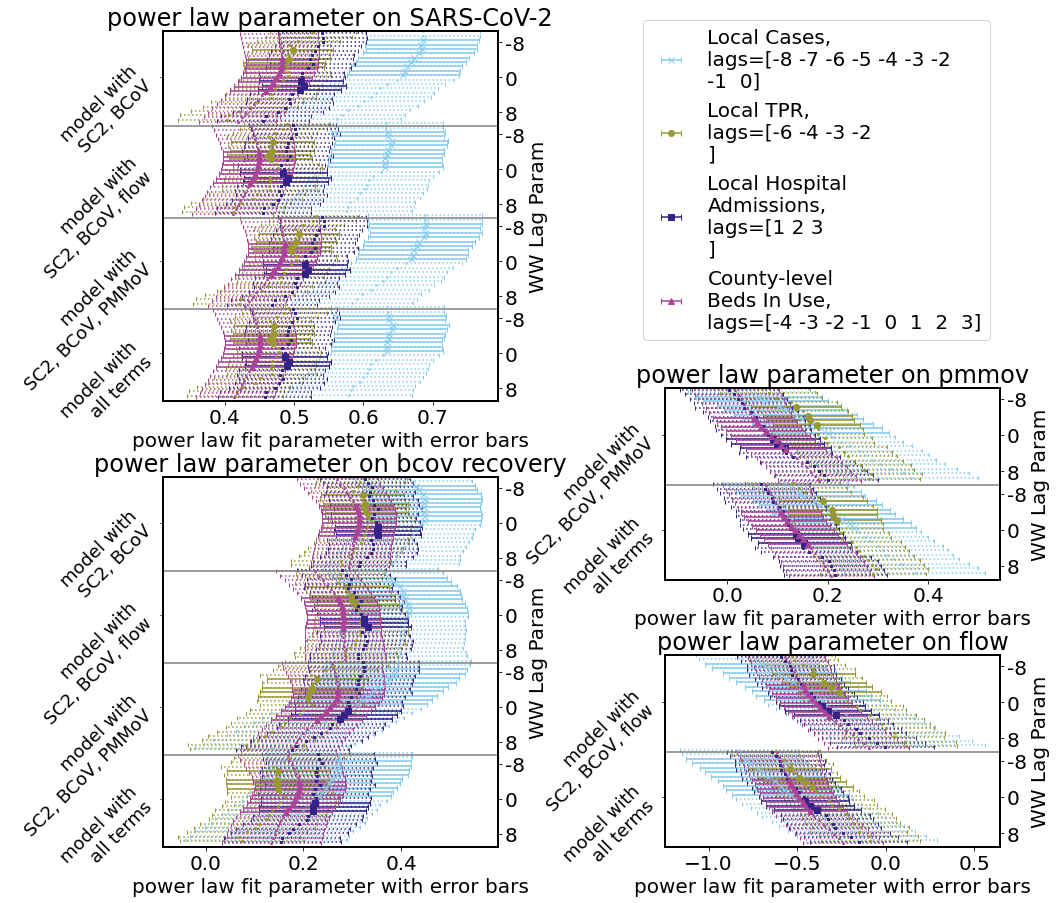

In [18]:
plus0 = 21*len(checkprevs)
lastprev = len(checkprevs)-1
modtermdict2 = {'raw_data':'SC2',
               'only_flow_norm':'SC2, flow',
               'pmmov_norm':'SC2, PMMoV', 
               'only_bcov_norm':'SC2, BCoV',
               'bcov_flow_norm':'SC2, BCoV, flow',
               'pmmov_bcov_norm':'SC2, BCoV, PMMoV',
               'pmmov_bcov_flow_norm':'all terms'}
prevnamedict = {'positive tests':'Local Cases',
 'test positivity rate':'Local TPR',
 'hospital admissions':'Local Hospital\nAdmissions',
 'Cook County beds in use':'County-level\nBeds In Use'}
fig = plt.figure(figsize=(15,15))
gs = gridspec.GridSpec(10, 2, figure=fig,hspace=5.5,wspace=.5)
mycolors = mycolorscb2
marks = ['x','o','s','^']
for (feature,fits,sign) in zip(['bcov_recovery','pmmov','flow','raw_data'],[[7,9,11,13],[11,13],[9,13],[7,9,11,13]],[-1,-1,1,1]):
    if feature == 'raw_data':
        ax = fig.add_subplot(gs[:5, 0])
    elif feature == 'bcov_recovery':
        ax = fig.add_subplot(gs[5:, 0])
    elif feature == 'pmmov':
        ax = fig.add_subplot(gs[4:7, 1])
    elif feature == 'flow':
        ax = fig.add_subplot(gs[7:, 1])
    p0 = 0
    splits = []
    for n,myfit in enumerate(paramdf.fit.unique()[np.r_[fits]]):
        for m,(prevind,mylags) in enumerate(zip(checkprevs,useparams)):
            mask = (paramdf.wwtp=='comb') & (paramdf.fit==myfit) & (
                paramdf.lag.isin(mylags)) & (paramdf.feature==feature) & (
                paramdf.prevind==prevind)
            mask1 = (paramdf.wwtp=='comb') & (paramdf.fit==myfit) & (
                paramdf.feature==feature) & (paramdf.prevind==prevind)
            if feature=='raw_data':
                if (n==0) & (m==lastprev):
                    lab = prevnamedict[prevind]+',\nlags='+str(mylags)
                elif n==0:
                    lab = prevnamedict[prevind]+',\nlags='+str(mylags[:7])[:-1]+'\n'+str(mylags[7:])[1:]
                else:
                    lab=None
            else:
                lab=None
            eb1 = plt.errorbar(paramdf[mask1].params*sign,-10-np.array(lags)-p0-.2*m,
                                 xerr=[(paramdf[mask1].params-paramdf[mask1].lb)*sign,
                                       (paramdf[mask1].ub-paramdf[mask1].params)*sign],
                                 capsize=2,fmt = marks[m],color=mycolors[m],markersize=2)
            eb1[-1][0].set_linestyle(':')
            ax.errorbar(paramdf[mask].params*sign,-10-np.array(mylags)-p0-.2*m,
                                 xerr=[(paramdf[mask].params-paramdf[mask].lb)*sign,
                                       (paramdf[mask].ub-paramdf[mask].params)*sign],
                                 capsize=3,fmt = marks[m],color=mycolors[m],label=lab,markersize=6)
        p0+=len(lags)
        splits.append(p0)
    xlims = plt.gca().get_xlim()
    plt.gca().set_ylim([-p0-.5, 0])
    for p in splits:
        plt.hlines(y=-p-.5,xmin=xlims[0],xmax=xlims[1],color='tab:grey')
    plt.gca().set_xlim(xlims)
    plt.title('power law parameter on '+feature.replace('raw_data','SARS-CoV-2').replace('_',' '))
    plt.xlabel('power law fit parameter with error bars')
    plt.gca().set_yticks(10.5-np.array(splits),
                         ['model with\n'+modtermdict2[mod] for mod in paramdf.fit.unique()[np.r_[fits]]],
                         rotation=45,fontsize=18)
    ax = plt.gca().twinx()
    ax.set_ylim([-p0-.5,0])
    ax.set_yticks([s-10.5-21*s1 for s1 in range(n,-1,-1) for s in [-8,0,8]],
                  [s for s1 in range(n,-1,-1) for s in [8,0,-8]])
    ax.set_ylabel('WW Lag Param')
fig.legend(loc='upper right',bbox_to_anchor=(.9,.9))
plt.show()


### Sup Figure 2

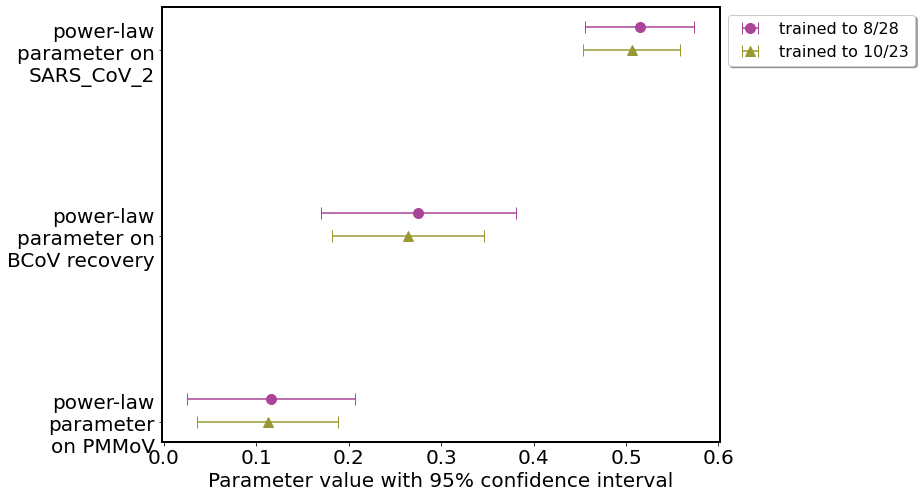

In [19]:
paramdf1023 = pd.read_csv(altparamfile)

plt.figure(figsize=(10,8))
ax = plt.gca()
mycolors = mycolorscb
marks = markstraj
modtermdict2 = {'raw_data':'power-law\nparameter on\nSARS_CoV_2',
               'bcov_recovery':'power-law\nparameter on\nBCoV recovery', 
               'pmmov':'power-law\nparameter\non PMMoV'}
for m,(mdf,lab,wtp) in enumerate(zip([paramdf,paramdf1023],
                                          ['trained to 8/28','trained to 10/23'],
                                          ['comb','comb'])):
    mask = (mdf.wwtp==wtp) & (mdf.prevind=='hospital admissions') & (mdf.lag==3) & (
        mdf.fit=='pmmov_bcov_norm') & (mdf.feature.isin(['raw_data','bcov_recovery','pmmov']))
    ax.errorbar(mdf[mask].params*[1,-1,-1],2-np.arange(3)-(m-1)/8,
                 xerr=[mdf[mask].params-mdf[mask].lb,mdf[mask].ub-mdf[mask].params],
             capsize=6,fmt =marks[m],color=mycolors[m],markersize=10,label=lab)
ax.set_yticks(range(3))
ax.set_yticklabels([modtermdict2[m] for m in mdf[mask].feature][::-1],fontsize=20)
ax.set_xlabel('Parameter value with 95% confidence interval',fontsize=20)
ledge = plt.legend(loc='upper left',bbox_to_anchor=(1,1), shadow=True, fancybox=True, numpoints=1,ncol=1,fontsize=16)#bbox_to_anchor=(0.0, 0.83)
plt.show()

### Sup Figure 3

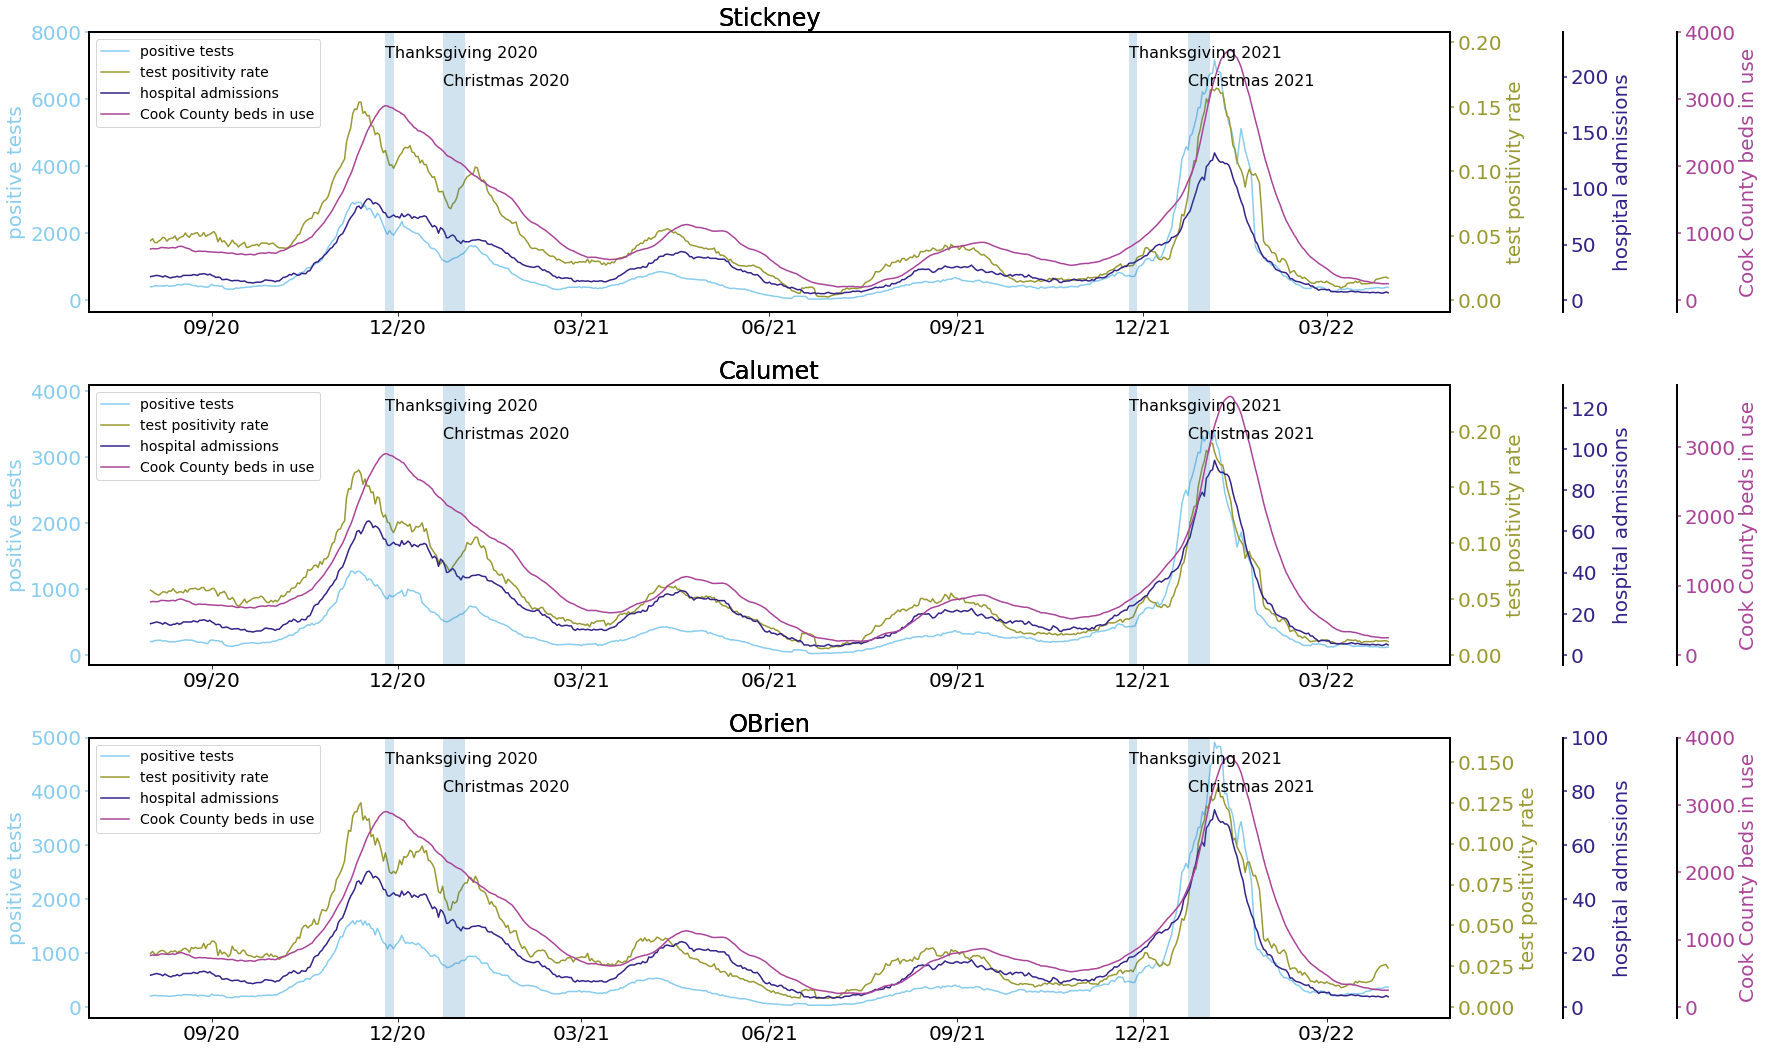

In [20]:
useprevs = ['test positivity rate','hospital admissions','Cook County beds in use']
plt.figure(figsize=(25,15))
tkw = dict(size=4, width=1.5)
startdate = '2020-08-01'
ylims = [[-350,8000],[-150,4100],[-200,5000]]
ylimmult = [[2.6e-5,0.03,0.5],[5.9e-5,0.032,0.95],[3.3e-5,0.02,0.8]]
plotlags = [0,0,0]
mycolors = ['#88CCEE','#999933','#332288','#AA4499']
marks = ['^','x','s','o']
for n,catch in enumerate(catches_shortlist):
    plt.subplot(len(catches_shortlist),1,n+1)
    ax1 = plt.gca()
    mask = (prevdf.catchment == catch) & (prevdf.date>startdate) & (prevdf.date<='2022-04-05')
    w1 = ax1.plot(prevdf[mask].date,prevdf[mask]['positive tests'],label='positive tests',color=mycolors[0])
    ax1.set_ylabel('positive tests')
    ax1.yaxis.label.set_color(mycolors[0])
    ax1.tick_params(axis='y', colors=mycolors[0], **tkw)
    ax1.set_ylim(ylims[n])
    for m,(col,lag) in enumerate(zip(useprevs,plotlags)):
        enddate = '2022-04-05'
        ax = ax1.twinx()
        mask = (prevdf.catchment == catch) & (prevdf.date>startdate) & (prevdf.date<=enddate)
        p=ax.plot(prevdf[mask].date-datetime.timedelta(days=lag),prevdf[mask][col],color=mycolors[m+1],label=col)
        w1+=p
        ax.set_ylabel(col)
        ax.set_title(catch)
        ax.yaxis.label.set_color(p[0].get_color())
        ax.tick_params(axis='y', colors=p[0].get_color(), **tkw)
        ax.spines['right'].set_position(("axes", 1+m/12))
        ax.set_ylim([p*ylimmult[n][m] for p in ylims[n]])
    h = ax.get_ylim()
    for p,(s,e,name) in enumerate(zip(['2020-11-25','2020-12-23','2021-11-24','2021-12-23'],
                     ['2020-11-29','2021-01-03','2021-11-28','2022-01-03'],
                     ['Thanksgiving 2020','Christmas 2020','Thanksgiving 2021','Christmas 2021'])):
        ax.axvspan(s,e,alpha=0.2)
        ax.annotate(name,xy=(pd.to_datetime(s, format = '%Y-%m-%d'), h[0]+(.95-.1*np.mod(p,2))*(h[1]-h[0])), xycoords='data',
                    xytext=(pd.to_datetime(s, format = '%Y-%m-%d'), h[0]+(.95-.1*np.mod(p,2))*(h[1]-h[0])), textcoords='data',
                    arrowprops=dict(facecolor='tab:red', shrink=0.05),
                    horizontalalignment='left', verticalalignment='top',fontsize=16)
    ax.set_title(catch)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(DateFormatter("%m/%y"))
    labs = [l.get_label() for l in w1]
    plt.legend(w1,labs,fontsize=14,loc='upper left')
ax.set_xlabel('Date')
plt.tight_layout()
plt.show()

### Sup Figure 4

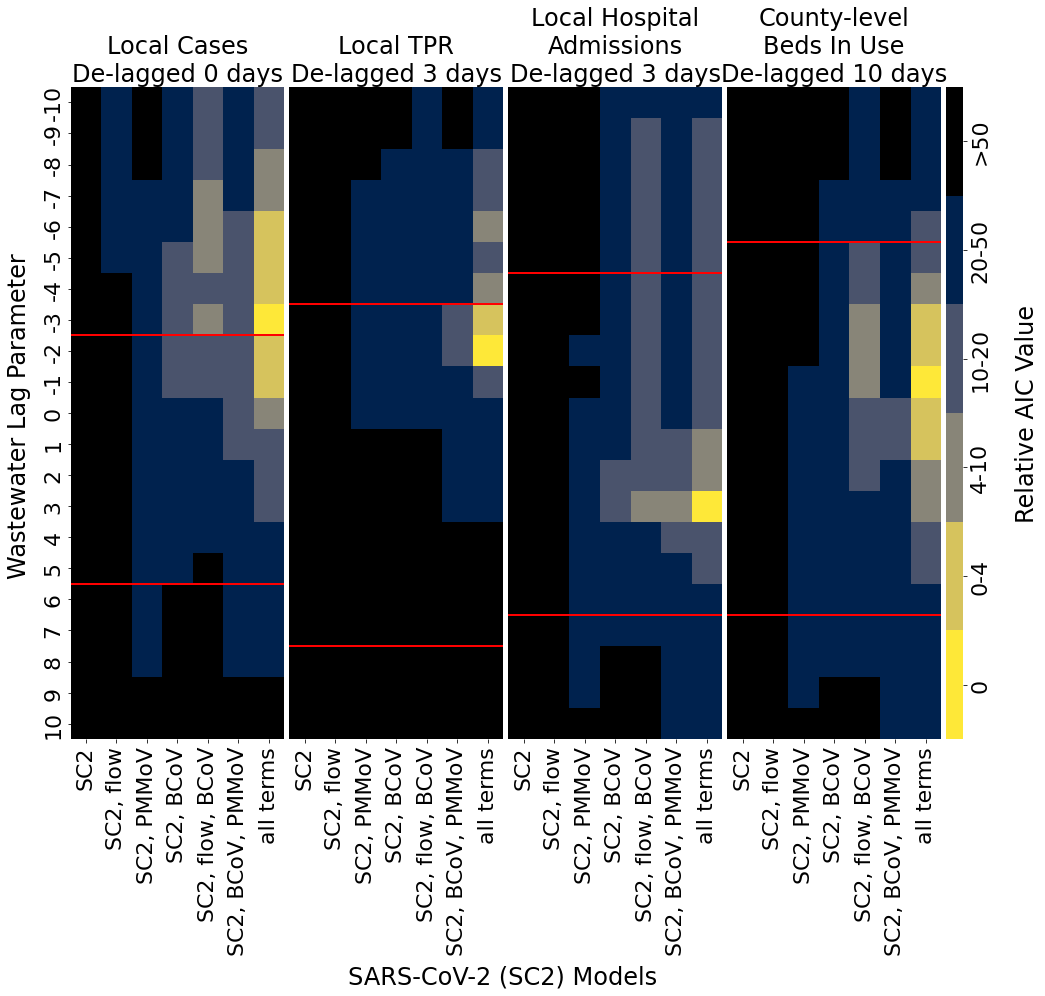

In [21]:
fs1 = 22 # tick labels
fs2 = 24 # axis labels & axis titles
aic2 = aict2.copy()
aicprevs = ['positive tests','test positivity rate','hospital admissions','Cook County beds in use']
aic2.prevind=pd.Categorical(aic2.prevind,categories=aic2.prevind.unique(),ordered=True)
aic2.model=pd.Categorical(aic2.model,categories=aic2.model.unique(),ordered=True)
pivotedaic = aic2[(aic2.model.isin(models)) & (aic2.wwtp==wwtp)].pivot_table(index = ['lag'],
                         columns = ['prevind','model'],sort=False)
newmapaic = aic_colormap()
# for each prev, calc relative aic.
offset = {}
for prev in aic2.prevind.unique():
    offset[prev] = pivotedaic.aic.loc[:,(pivotedaic.aic.columns.get_level_values('prevind')==prev)].min().min()
    pivotedaic.aic.loc[:,(pivotedaic.aic.columns.get_level_values('prevind')==prev)] = pivotedaic.aic.loc[
        :,(pivotedaic.aic.columns.get_level_values('prevind')==prev)].sub(pivotedaic.aic.loc[
        :,(pivotedaic.aic.columns.get_level_values('prevind')==prev)].min().min(),axis=1).values
rel = ' - rel AIC across models and lags for each prev'

modtermdict = {'no correction':'SC2',
               'only flow':'SC2, flow',
               'pmmov norm':'SC2, PMMoV', 
               'only bcov norm':'SC2, BCoV',
               'bcov flow norm':'SC2, flow, BCoV',
               'pmmov bcov norm':'SC2, BCoV, PMMoV',
               'pm bc fl':'all terms'}
prevnamedict = {'positive tests':'Local Cases',
 'test positivity rate':'Local TPR',
 'hospital admissions':'Local Hospital\nAdmissions',
 'Cook County beds in use':'County-level\nBeds In Use'}
nplots = len(aicprevs)
fig = plt.figure(figsize=(nplots*4,12))
gs = fig.add_gridspec(1, nplots+1, hspace=0.03, wspace=0.03,width_ratios=[1]*nplots+[0.08])
axs = gs.subplots()
for n,prevind in enumerate(aicprevs):
    melted = pd.melt(pivotedaic['aic',prevind],var_name='model',value_name='aic',ignore_index=False)
    melted.aic = melted.aic.apply(lambda x:discrete_color_aic(x))
    melted.model=pd.Categorical(melted.model,categories=models,ordered=True)
    # Updates: allow for variably chosen models to show here...
    newpivotedaic = melted[(melted.model.str.contains('new')) & ~(melted.model.isin([' new only flow aic',' new no correction aic',' new pmmov norm aic']))].pivot_table(index=['lag'],columns=['model'],sort=False)
    if n<nplots-1:
        sns.heatmap(newpivotedaic['aic'], cmap=newmapaic,cbar=False,vmin=-0.5,vmax=5.5,ax= axs[n])
    if n==nplots-1:
        sns.heatmap(newpivotedaic['aic'], cmap=newmapaic,vmin=-0.5,vmax=5.5,ax= axs[n],cbar_ax=axs[n+1])
    mymods = [modtermdict[m[4:-4]] for m in newpivotedaic.aic.columns.tolist()]
    uselags = newpivotedaic.aic.index.tolist()
    axs[n].set_xticks(np.linspace(0.5,0.5*(len(mymods)*2-1),len(mymods)))
    axs[n].set_xticklabels(mymods, fontsize = fs1)
    axs[n].set_xlabel('Model',fontsize=fs2)
    axs[n].set_yticks(np.linspace(0.5,0.5*(len(uselags)*2-1),len(uselags)))
    axs[n].set_yticklabels(uselags, fontsize = fs1)
    axs[n].set_xlabel('')
    axs[n].set_ylabel('')
    if n>0:
        axs[n].set_yticks([])
    # Updates: if lags is not every integer from -10 to 10, this does not show the right lines...
    axs[n].axhline(y=prevbounds[prevbounds.prevind==prevind].upper.iloc[0]+11,color='r',linewidth=2) # upper
    axs[n].axhline(y=prevbounds[prevbounds.prevind==prevind].lower.iloc[0]+10,color='r',linewidth=2) # lower
    if n==nplots-1:
        colorbar = axs[n+1]#.collections[0].colorbar
        colorbar.set_yticks([0,1,2,3,4,5])
        colorbar.set_yticklabels(['0','0-4', '4-10', '10-20', '20-50', '>50'],rotation=90,\
                                 verticalalignment='center',horizontalalignment='left',fontsize=fs1)
        plt.annotate('Relative AIC Value',xy=(1,1),xycoords='figure fraction',
                               xytext=(4, 2.5), textcoords='data',
                               horizontalalignment='left',verticalalignment='center',rotation=90,fontsize=fs2)
    axs[n].set_title(prevnamedict[prevind]+'\nDe-lagged '+str(int(prevlagdict[prevind]))+' days',fontsize=fs2)

fig.text(0.07, 0.5,'Wastewater Lag Parameter', va='center', rotation='vertical',fontsize=fs2)
fig.text(0.5, -.15, 'SARS-CoV-2 (SC2) Models', va='center', rotation='horizontal',ha='center',fontsize=fs2)
plt.show()

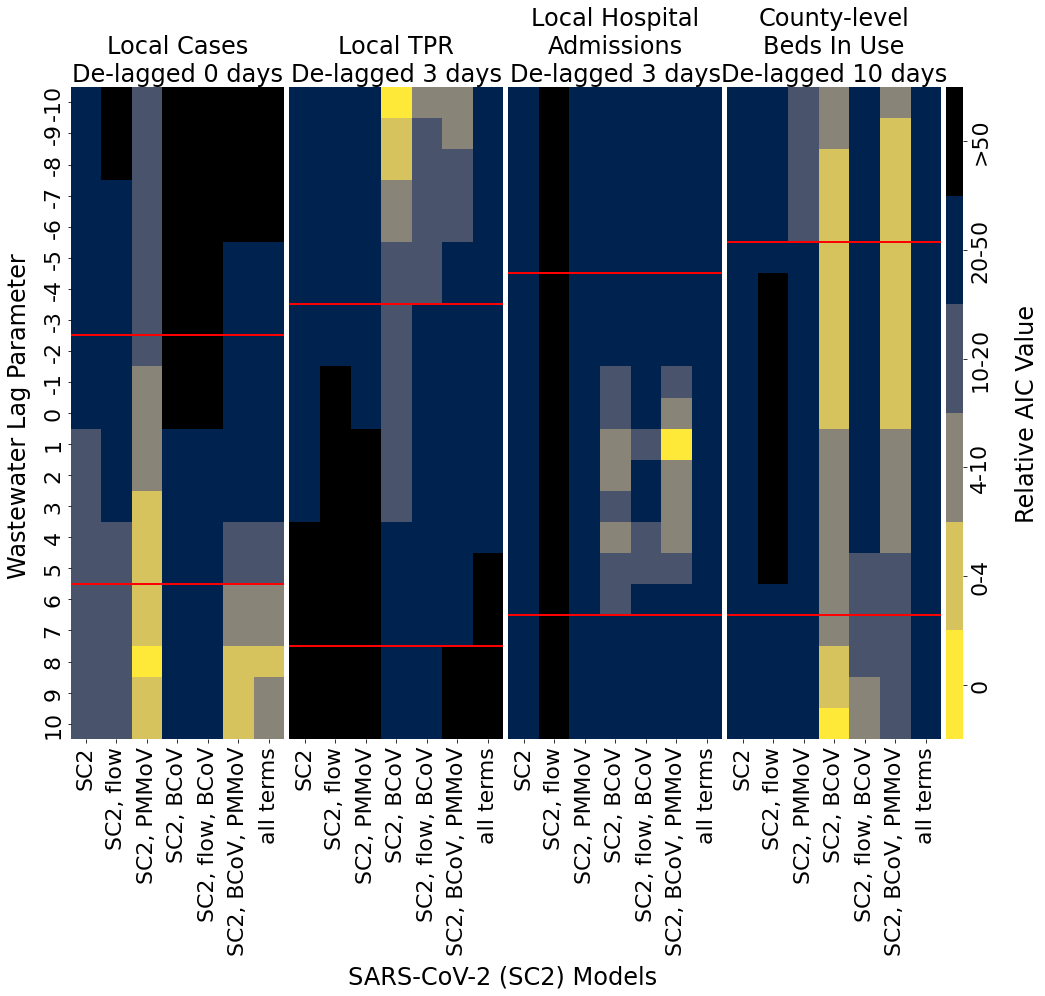

In [22]:
fs1 = 22 # tick labels
fs2 = 24 # axis labels & axis titles
aic2 = aicf2.copy()
aicprevs = ['positive tests','test positivity rate','hospital admissions','Cook County beds in use']
aic2.prevind=pd.Categorical(aic2.prevind,categories=aic2.prevind.unique(),ordered=True)
aic2.model=pd.Categorical(aic2.model,categories=aic2.model.unique(),ordered=True)
pivotedaic = aic2[(aic2.model.isin(models)) & (aic2.wwtp==wwtp)].pivot_table(index = ['lag'],
                         columns = ['prevind','model'],sort=False)
newmapaic = aic_colormap()
# for each prev, calc relative aic.
offset = {}
for prev in aic2.prevind.unique():
    offset[prev] = pivotedaic.aic.loc[:,(pivotedaic.aic.columns.get_level_values('prevind')==prev)].min().min()
    pivotedaic.aic.loc[:,(pivotedaic.aic.columns.get_level_values('prevind')==prev)] = pivotedaic.aic.loc[
        :,(pivotedaic.aic.columns.get_level_values('prevind')==prev)].sub(pivotedaic.aic.loc[
        :,(pivotedaic.aic.columns.get_level_values('prevind')==prev)].min().min(),axis=1).values
rel = ' - rel AIC across models and lags for each prev'

modtermdict = {'no correction':'SC2',
               'only flow':'SC2, flow',
               'pmmov norm':'SC2, PMMoV', 
               'only bcov norm':'SC2, BCoV',
               'bcov flow norm':'SC2, flow, BCoV',
               'pmmov bcov norm':'SC2, BCoV, PMMoV',
               'pm bc fl':'all terms'}
prevnamedict = {'positive tests':'Local Cases',
 'test positivity rate':'Local TPR',
 'hospital admissions':'Local Hospital\nAdmissions',
 'Cook County beds in use':'County-level\nBeds In Use'}
nplots = len(aicprevs)
fig = plt.figure(figsize=(nplots*4,12))
gs = fig.add_gridspec(1, nplots+1, hspace=0.03, wspace=0.03,width_ratios=[1]*nplots+[0.08])
axs = gs.subplots()
for n,prevind in enumerate(aicprevs):
    melted = pd.melt(pivotedaic['aic',prevind],var_name='model',value_name='aic',ignore_index=False)
    melted.aic = melted.aic.apply(lambda x:discrete_color_aic(x))
    melted.model=pd.Categorical(melted.model,categories=models,ordered=True)
    # Updates: allow for variably chosen models to show here...
    newpivotedaic = melted[(melted.model.str.contains('new')) & ~(melted.model.isin([' new only flow aic',' new no correction aic',' new pmmov norm aic']))].pivot_table(index=['lag'],columns=['model'],sort=False)
    if n<nplots-1:
        sns.heatmap(newpivotedaic['aic'], cmap=newmapaic,cbar=False,vmin=-0.5,vmax=5.5,ax= axs[n])
    if n==nplots-1:
        sns.heatmap(newpivotedaic['aic'], cmap=newmapaic,vmin=-0.5,vmax=5.5,ax= axs[n],cbar_ax=axs[n+1])
    mymods = [modtermdict[m[4:-4]] for m in newpivotedaic.aic.columns.tolist()]
    uselags = newpivotedaic.aic.index.tolist()
    axs[n].set_xticks(np.linspace(0.5,0.5*(len(mymods)*2-1),len(mymods)))
    axs[n].set_xticklabels(mymods, fontsize = fs1)
    axs[n].set_xlabel('Model',fontsize=fs2)
    axs[n].set_yticks(np.linspace(0.5,0.5*(len(uselags)*2-1),len(uselags)))
    axs[n].set_yticklabels(uselags, fontsize = fs1)
    axs[n].set_xlabel('')
    axs[n].set_ylabel('')
    if n>0:
        axs[n].set_yticks([])
    # Updates: if lags is not every integer from -10 to 10, this does not show the right lines...
    axs[n].axhline(y=prevbounds[prevbounds.prevind==prevind].upper.iloc[0]+11,color='r',linewidth=2) # upper
    axs[n].axhline(y=prevbounds[prevbounds.prevind==prevind].lower.iloc[0]+10,color='r',linewidth=2) # lower
    if n==nplots-1:
        colorbar = axs[n+1]#.collections[0].colorbar
        colorbar.set_yticks([0,1,2,3,4,5])
        colorbar.set_yticklabels(['0','0-4', '4-10', '10-20', '20-50', '>50'],rotation=90,\
                                 verticalalignment='center',horizontalalignment='left',fontsize=fs1)
        plt.annotate('Relative AIC Value',xy=(1,1),xycoords='figure fraction',
                               xytext=(4, 2.5), textcoords='data',
                               horizontalalignment='left',verticalalignment='center',rotation=90,fontsize=fs2)
    axs[n].set_title(prevnamedict[prevind]+'\nDe-lagged '+str(int(prevlagdict[prevind]))+' days',fontsize=fs2)

fig.text(0.07, 0.5,'Wastewater Lag Parameter', va='center', rotation='vertical',fontsize=fs2)
fig.text(0.5, -.15, 'SARS-CoV-2 (SC2) Models', va='center', rotation='horizontal',ha='center',fontsize=fs2)
plt.show()

### Sup Figure 5

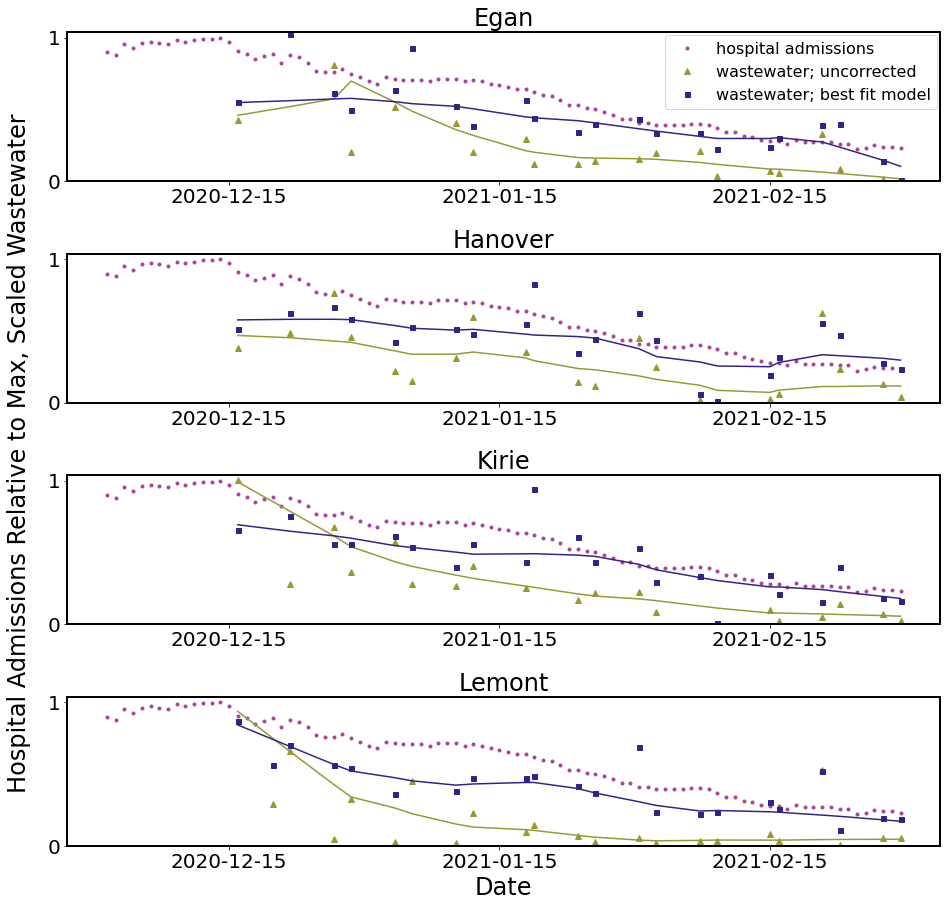

In [23]:
marks = markstraj
msize = [5,6,5]
mycolors = mycolorscb
fig = plt.figure(figsize=(13,1+len(['Egan','Hanover','Kirie','Lemont'])*3))
for j,catch in enumerate(['Egan','Hanover','Kirie','Lemont']):
    plt.subplot(len(['Egan','Hanover','Kirie','Lemont']),1,j+1)
    ax = plt.gca()
    startdate = wbe[(wbe.catchment==catch) & (wbe.date>=prevdf.date.min())].date.min()-pd.Timedelta(15,'days')
    enddate = wbe[(wbe.catchment==catch) & (wbe.date<=prevdf.date.max())].date.max()
    maskp = (prevdf.catchment==catch.replace('Stickney Full','Stickney')) & (prevdf.date>=startdate) & (prevdf.date<=enddate)
    maskw = (wbe.catchment==catch) & (wbe.date>=startdate) & (wbe.date<=enddate)
    p = ax.plot(prevdf[maskp].date,prevdf[maskp][useprev_single],'.',color=mycolors[0],label=useprev_single.replace('sensitive','hospital'))
    ax1 = ax
    ws = []
    for n,(ww,label) in enumerate(zip(usewws,['uncorrected','best fit model'])):
        ax1.set_ylim([0,ax1.get_ylim()[1]])
        datax = wbe[(wbe.catchment==catch)][['date',ww]].copy()
        dataz = prevdf[(prevdf.catchment==catch)][['date','hospital admissions']].copy()
        dataz.date -= datetime.timedelta(days=5)
        mydf2 = pd.merge(datax,dataz,on=['date'],how='inner')
        mydf2.dropna(how='any',inplace=True)
        features = mydf2[(mydf2.date<enddate)][ww]
        target = mydf2[(mydf2.date<enddate)]['hospital admissions']
        f2,reg = mymreg(features,target,addconst=0)
        ws = ax1.plot(wbe[maskw].date,wbe[maskw][ww]*reg.params[0],marks[np.mod(n+1,3)],
                markersize=msize[np.mod(n+1,3)],color=mycolors[n+1],label='wastewater; '+label)
        smooth = sm.nonparametric.lowess(endog=wbe[maskw][ww]*reg.params[0], exog=mdates.date2num(wbe[maskw].date), 
                                         frac= 0.4)
        ax1.plot(smooth[:,0],smooth[:,1],'-',color=mycolors[n+1])
        p+=ws
    if j==0:
        labs = [l.get_label() for l in p]
        ax.legend(p,labs,bbox_to_anchor=(1,1),loc='upper right',borderaxespad=.2,ncol=1,fontsize=16)
    ax.set_title(catch.replace(' Full','').replace('OBrien',"O'Brien"))
    ax.set_yticks([0,np.max(prevdf[maskp][useprev_single])])
    ax.set_yticklabels([0,1])
    ax.set_xticks(ax.get_xticks()[1::2])
#     print(ax.get_xticks())
ax.set_xlabel('Date',fontsize=fs2)
fig.text(-.02, 0.5, 'Hospital Admissions Relative to Max, Scaled Wastewater', va='center', rotation='vertical',fontsize=fs2)
plt.tight_layout()
plt.show()

### Sup Figure 6

In [24]:
altprev = 'Cook County beds in use'
wbe1 = pd.read_csv(wbefile, parse_dates=['date'])
wbe1.rename(columns={'wrp':'catchment','sarscov2':'raw_data'},inplace=True)
datatype = 'pmmov_bcov_norm'

paramdfsmallnone,aicdfsmall,pdfsmall,aicfulldfsmall = FitModelParameters(wbe1[wbe1.date<'2021-08-28'],prevdf,['comb'],[altprev],
                                                 ['raw_data'],['Stickney','Calumet','OBrien','Egan','Hanover','Kirie','Lemont'],'2021-08-28',
                                                 [3],ww_lod,prevlagdict,prevenddate)
display(paramdfsmallnone[paramdfsmallnone.fit=='orig-raw_data'])
wbe1 = CalculateModelFitsFromParams(wbe1,paramdf,ww_lod,wwtp,lag,useprev_single,scaleparam=False)
paramdfsmallfixed,aicdfsmall,pdfsmall,aicfulldfsmall = FitModelParameters(wbe1[wbe1.date<'2021-08-28'],prevdf,['comb'],[altprev],
                                                 [datatype],['Stickney','Calumet','OBrien','Egan','Hanover','Kirie','Lemont'],'2021-08-28',
                                                 [3],ww_lod,prevlagdict,prevenddate)
display(paramdfsmallfixed[paramdfsmallfixed.fit=='orig-'+datatype])

lag: 3 , catch:  comb


wwtp                  prevind            fit   feature lag    params  \
0  comb  Cook County beds in use  orig-raw_data  Stickney   3  2.038694   
1  comb  Cook County beds in use  orig-raw_data   Calumet   3  1.957416   
2  comb  Cook County beds in use  orig-raw_data    OBrien   3  1.960564   
3  comb  Cook County beds in use  orig-raw_data      Egan   3  2.629775   
4  comb  Cook County beds in use  orig-raw_data   Hanover   3  2.628737   
5  comb  Cook County beds in use  orig-raw_data     Kirie   3  2.333395   
6  comb  Cook County beds in use  orig-raw_data    Lemont   3  1.946654   

         lb        ub  
0  1.945958  2.131430  
1  1.860276  2.054556  
2  1.864092  2.057036  
3  2.449907  2.809643  
4  2.448869  2.808604  
5  2.153528  2.513263  
6  1.774784  2.118523

lag: 3 , catch:  comb


wwtp                  prevind                   fit   feature lag  \
0  comb  Cook County beds in use  orig-pmmov_bcov_norm  Stickney   3   
1  comb  Cook County beds in use  orig-pmmov_bcov_norm   Calumet   3   
2  comb  Cook County beds in use  orig-pmmov_bcov_norm    OBrien   3   
3  comb  Cook County beds in use  orig-pmmov_bcov_norm      Egan   3   
4  comb  Cook County beds in use  orig-pmmov_bcov_norm   Hanover   3   
5  comb  Cook County beds in use  orig-pmmov_bcov_norm     Kirie   3   
6  comb  Cook County beds in use  orig-pmmov_bcov_norm    Lemont   3   

     params        lb        ub  
0 -0.625484 -0.668153 -0.582814  
1 -0.658653 -0.706243 -0.611064  
2 -0.611205 -0.660000 -0.562410  
3 -0.279204 -0.349112 -0.209296  
4 -0.239295 -0.311118 -0.167471  
5 -0.321735 -0.397916 -0.245555  
6 -0.347041 -0.454776 -0.239305

Using lag = 0


catchment  Raw SARS-CoV-2  Corrected Wastewater  % change
0  Stickney          0.3591                0.1783    0.5035
1   Calumet          0.4049                0.1651    0.5922
2    OBrien          0.4648                0.1896    0.5921
3  Stickney          0.5157                0.0910    0.8235
4   Calumet          0.5663                0.0960    0.8305
5    OBrien          0.5503                0.0802    0.8543
6      Egan          0.3524                0.1314    0.6271
7   Hanover          0.4014                0.2282    0.4315
8     Kirie          0.3335                0.1382    0.5856
9    Lemont          0.5066                0.1868    0.6313

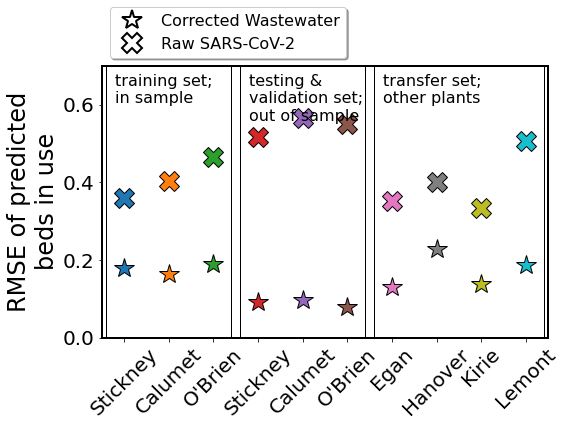

In [25]:
fs3 = 18
mycolors = mycolorsorig
uselags = np.arange(-10,10,1)
show_corr_plot=False
trainbox = [-.4,0,2.8,.7]
testbox = [2.6,0,2.8,.7]
transferbox = [5.6,0,3.8,.7]
if show_corr_plot:
    plt.figure(figsize=(15,8))
mylags = pd.DataFrame()
mycorrs = pd.DataFrame()
mylags['catchment'] = catches_correlation
mycorrs['catchment'] = catches_correlation
for (ww,label,lin) in zip(usewws,wwlabs,['--','-']):
    mylag = []
    mycorr = []
    for n,catch in enumerate(catches_correlation):
        if n<3:
            startdate = '2020-10-16'
            enddate = '2021-08-28'
        elif n<6:
            startdate = '2021-10-23'
#             startdate = '2021-09-11'
            enddate = '2022-01-01'
        else:
            startdate = '2020-10-16'
            enddate = '2022-01-01'
        maskp = (prevdf.catchment==catch.replace('Stickney Full','Stickney')) & (prevdf[altprev]>0)
        maskw = (wbe1.catchment==catch) & (wbe1.date>=startdate) & (wbe1.date<=enddate) & (wbe1.orig_raw>ww_lod)
        wdf = wbe1[maskw][['date',ww]].copy()
        if ww == 'orig-raw_data':
            wdf[ww] = wdf[ww]*10**(-paramdfsmallnone[(paramdfsmallnone.fit=='orig-raw_data') & (paramdfsmallnone.feature==catch)].params.iloc[0])
        else:
            wdf[ww] = wdf[ww]*10**(-paramdfsmallfixed[(paramdfsmallfixed.fit=='orig-'+datatype) & (paramdfsmallfixed.feature==catch)].params.iloc[0])
        pdf = prevdf[maskp][['date',altprev]].copy()
        wdf[ww] = np.log10(wdf[ww])
        pdf[altprev] = np.log10(pdf[altprev])
        mycors = crosscorrW(wdf,pdf,lags=uselags+prevlagdict[altprev],rmse=True)
        if show_corr_plot:
            plt.plot(uselags+prevlagdict[altprev],mycors,lin,color=mycolors[n],label=catch+', '+ww)
        mylag.append(uselags[np.argmax(mycors)]+prevlagdict[altprev])
        mycorr.append(mycors[uselags==lag])
    mylags[label] = np.round(mylag,4)
    mycorrs[label] = np.round(mycorr,4)
mycorrs['% change'] = np.round((mycorrs[wwlabs[0]]-mycorrs[wwlabs[1]])/mycorrs[wwlabs[0]],4)
print('Using lag =',lag)
display(mycorrs)
if show_corr_plot:
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()
fig,ax = plt.subplots(figsize=(8,5))
for n,catch in enumerate(catches_correlation):
    for (ww,star) in zip(wwlabs,['X','*']):
        plt.plot(n,mycorrs[ww].iloc[n],star,markeredgecolor='black',color=mycolors[n],markersize=20)
plt.plot(10,60,'*',color='black',markersize=20,markeredgewidth=2,markerfacecolor='None',label=wwlabs[1])
plt.plot(10,50,'X',color='black',markersize=20,markeredgewidth=2,markerfacecolor='None',label=wwlabs[0])
for box,txt in zip([trainbox,testbox,transferbox],
                   ['training set;\nin sample','testing &\nvalidation set;\nout of sample',
                    'transfer set;\nother plants']):
    ax.add_patch(Rectangle((box[0],box[1]), box[2], box[3], fill=None, alpha=1))
    plt.annotate(txt,xy=(1,1),xycoords='figure fraction',
                   xytext=(box[0]+.2, box[1]+box[3]-.02), textcoords='data',
                   horizontalalignment='left',verticalalignment='top',fontsize=16)
ax.set_xlim([-.5,len(catches_correlation)-.5])
ax.set_xticks(range(len(catches_correlation)))
ax.set_xticklabels([catch.replace(' Full','').replace('OBrien',"O'Brien") for catch in catches_correlation],
                   rotation=45)
ax.set_ylim([0,0.7])
ax.set_ylabel('RMSE of predicted\nbeds in use',fontsize=fs2)
ledge = plt.legend(loc='lower left', bbox_to_anchor=(0,1), shadow=True, fancybox=True, numpoints=1,ncol=1,fontsize=16)#bbox_to_anchor=(0.0, 0.83)
plt.show()
 

In [26]:
altprev = 'test positivity rate'
wbe1 = pd.read_csv(wbefile, parse_dates=['date'])
wbe1.rename(columns={'wrp':'catchment','sarscov2':'raw_data'},inplace=True)
datatype = 'pmmov_bcov_norm'

paramdfsmallnone,aicdfsmall,pdfsmall,aicfulldfsmall = FitModelParameters(wbe1[wbe1.date<'2021-08-28'],prevdf,['comb'],[altprev],
                                                 ['raw_data'],['Stickney','Calumet','OBrien','Egan','Hanover','Kirie','Lemont'],'2021-08-28',
                                                 [3],ww_lod,prevlagdict,prevenddate)
display(paramdfsmallnone[paramdfsmallnone.fit=='orig-raw_data'])
wbe1 = CalculateModelFitsFromParams(wbe1,paramdf,ww_lod,wwtp,lag,useprev_single,scaleparam=False)
paramdfsmallfixed,aicdfsmall,pdfsmall,aicfulldfsmall = FitModelParameters(wbe1[wbe1.date<'2021-08-28'],prevdf,['comb'],[altprev],
                                                 [datatype],['Stickney','Calumet','OBrien','Egan','Hanover','Kirie','Lemont'],'2021-08-28',
                                                 [3],ww_lod,prevlagdict,prevenddate)
display(paramdfsmallfixed[paramdfsmallfixed.fit=='orig-'+datatype])

lag: 3 , catch:  comb


wwtp               prevind            fit   feature lag    params  \
0  comb  test positivity rate  orig-raw_data  Stickney   3  6.394565   
1  comb  test positivity rate  orig-raw_data   Calumet   3  6.244711   
2  comb  test positivity rate  orig-raw_data    OBrien   3  6.398780   
3  comb  test positivity rate  orig-raw_data      Egan   3  6.618369   
4  comb  test positivity rate  orig-raw_data   Hanover   3  6.579158   
5  comb  test positivity rate  orig-raw_data     Kirie   3  6.385028   
6  comb  test positivity rate  orig-raw_data    Lemont   3  5.980773   

         lb        ub  
0  6.297254  6.491875  
1  6.142779  6.346642  
2  6.297549  6.500010  
3  6.429629  6.807109  
4  6.390418  6.767898  
5  6.196288  6.573768  
6  5.800426  6.161121

lag: 3 , catch:  comb


wwtp               prevind                   fit   feature lag    params  \
0  comb  test positivity rate  orig-pmmov_bcov_norm  Stickney   3  3.708185   
1  comb  test positivity rate  orig-pmmov_bcov_norm   Calumet   3  3.643940   
2  comb  test positivity rate  orig-pmmov_bcov_norm    OBrien   3  3.821559   
3  comb  test positivity rate  orig-pmmov_bcov_norm      Egan   3  3.714252   
4  comb  test positivity rate  orig-pmmov_bcov_norm   Hanover   3  3.718615   
5  comb  test positivity rate  orig-pmmov_bcov_norm     Kirie   3  3.737938   
6  comb  test positivity rate  orig-pmmov_bcov_norm    Lemont   3  3.820333   

         lb        ub  
0  3.663975  3.752396  
1  3.594632  3.693248  
2  3.771002  3.872115  
3  3.641819  3.786684  
4  3.644198  3.793033  
5  3.659006  3.816869  
6  3.708707  3.931959

Using lag = 0


catchment  Raw SARS-CoV-2  Corrected Wastewater  % change
0  Stickney          0.3690                0.2291    0.3791
1   Calumet          0.4275                0.1868    0.5630
2    OBrien          0.4757                0.2051    0.5688
3  Stickney          0.6371                0.2005    0.6853
4   Calumet          0.6497                0.1867    0.7126
5    OBrien          0.6806                0.2147    0.6845
6      Egan          0.3770                0.1400    0.6286
7   Hanover          0.4219                0.2382    0.4354
8     Kirie          0.3546                0.1471    0.5852
9    Lemont          0.5234                0.2569    0.5092

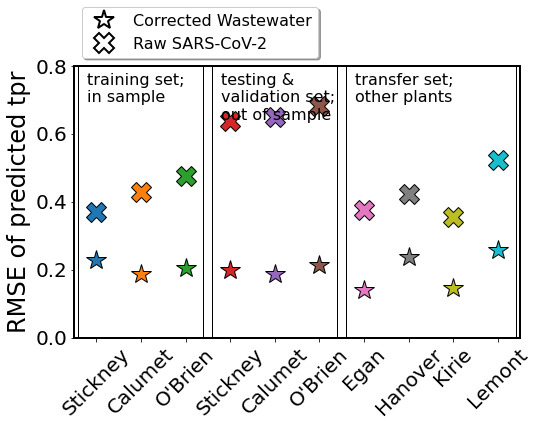

In [27]:
mycolors = mycolorsorig
uselags = np.arange(-10,10,1)
show_corr_plot=False
trainbox = [-.4,0,2.8,.8]
testbox = [2.6,0,2.8,.8]
transferbox = [5.6,0,3.8,.8]
if show_corr_plot:
    plt.figure(figsize=(15,8))
mylags = pd.DataFrame()
mycorrs = pd.DataFrame()
mylags['catchment'] = catches_correlation
mycorrs['catchment'] = catches_correlation
for (ww,label,lin) in zip(usewws,wwlabs,['--','-']):
    mylag = []
    mycorr = []
    for n,catch in enumerate(catches_correlation):
        if n<3:
            startdate = '2020-10-16'
            enddate = '2021-08-28'
        elif n<6:
            startdate = '2021-10-23'
            enddate = '2022-01-01'
        else:
            startdate = '2020-10-16'
            enddate = '2022-01-01'
        maskp = (prevdf.catchment==catch.replace('Stickney Full','Stickney')) & (prevdf[altprev]>0)
        maskw = (wbe1.catchment==catch) & (wbe1.date>=startdate) & (wbe1.date<=enddate) & (wbe1.orig_raw>ww_lod)
        wdf = wbe1[maskw][['date',ww]].copy()
        if ww == 'orig-raw_data':
            wdf[ww] = wdf[ww]*10**(-paramdfsmallnone[(paramdfsmallnone.fit=='orig-raw_data') & (paramdfsmallnone.feature==catch)].params.iloc[0])
        else:
            wdf[ww] = wdf[ww]*10**(-paramdfsmallfixed[(paramdfsmallfixed.fit=='orig-'+datatype) & (paramdfsmallfixed.feature==catch)].params.iloc[0])
        pdf = prevdf[maskp][['date',altprev]].copy()
        wdf[ww] = np.log10(wdf[ww])
        pdf[altprev] = np.log10(pdf[altprev])
        mycors = crosscorrW(wdf,pdf,lags=uselags+prevlagdict[altprev],rmse=True)
        if show_corr_plot:
            plt.plot(uselags+prevlagdict[altprev],mycors,lin,color=mycolors[n],label=catch+', '+ww)
        mylag.append(uselags[np.argmax(mycors)]+prevlagdict[altprev])
        mycorr.append(mycors[uselags==lag])
    mylags[label] = np.round(mylag,4)
    mycorrs[label] = np.round(mycorr,4)
mycorrs['% change'] = np.round((mycorrs[wwlabs[0]]-mycorrs[wwlabs[1]])/mycorrs[wwlabs[0]],4)
print('Using lag =',lag)
display(mycorrs)
if show_corr_plot:
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()
fig,ax = plt.subplots(figsize=(8,5))
for n,catch in enumerate(catches_correlation):
    for (ww,star) in zip(wwlabs,['X','*']):
        plt.plot(n,mycorrs[ww].iloc[n],star,markeredgecolor='black',color=mycolors[n],markersize=20)
plt.plot(10,60,'*',color='black',markersize=20,markeredgewidth=2,markerfacecolor='None',label=wwlabs[1])
plt.plot(10,50,'X',color='black',markersize=20,markeredgewidth=2,markerfacecolor='None',label=wwlabs[0])
for box,txt in zip([trainbox,testbox,transferbox],
                   ['training set;\nin sample','testing &\nvalidation set;\nout of sample',
                    'transfer set;\nother plants']):
    ax.add_patch(Rectangle((box[0],box[1]), box[2], box[3], fill=None, alpha=1))
    plt.annotate(txt,xy=(1,1),xycoords='figure fraction',
                   xytext=(box[0]+.2, box[1]+box[3]-.02), textcoords='data',
                   horizontalalignment='left',verticalalignment='top',fontsize=16)
ax.set_xlim([-.5,len(catches_correlation)-.5])
ax.set_xticks(range(len(catches_correlation)))
ax.set_xticklabels([catch.replace(' Full','').replace('OBrien',"O'Brien") for catch in catches_correlation],
                   rotation=45)
ax.set_ylim([0,0.8])
ax.set_ylabel('RMSE of predicted tpr',fontsize=fs2)
ledge = plt.legend(loc='lower left', bbox_to_anchor=(0,1), shadow=True, fancybox=True, numpoints=1,ncol=1,fontsize=16)#bbox_to_anchor=(0.0, 0.83)
plt.show()
 

In [28]:
altprev = 'positive tests'
wbe1 = pd.read_csv(wbefile, parse_dates=['date'])
wbe1.rename(columns={'wrp':'catchment','sarscov2':'raw_data'},inplace=True)
datatype = 'pmmov_bcov_norm'

paramdfsmallnone,aicdfsmall,pdfsmall,aicfulldfsmall = FitModelParameters(wbe1[wbe1.date<'2021-08-28'],prevdf,['comb'],[altprev],
                                                 ['raw_data'],['Stickney','Calumet','OBrien','Egan','Hanover','Kirie','Lemont'],'2021-08-28',
                                                 [3],ww_lod,prevlagdict,prevenddate)
display(paramdfsmallnone[paramdfsmallnone.fit=='orig-raw_data'])
wbe1 = CalculateModelFitsFromParams(wbe1,paramdf,ww_lod,wwtp,lag,useprev_single,scaleparam=False)
paramdfsmallfixed,aicdfsmall,pdfsmall,aicfulldfsmall = FitModelParameters(wbe1[wbe1.date<'2021-08-28'],prevdf,['comb'],[altprev],
                                                 [datatype],['Stickney','Calumet','OBrien','Egan','Hanover','Kirie','Lemont'],'2021-08-28',
                                                 [3],ww_lod,prevlagdict,prevenddate)
display(paramdfsmallfixed[paramdfsmallfixed.fit=='orig-'+datatype])

lag: 3 , catch:  comb


wwtp         prevind            fit   feature lag    params        lb  \
0  comb  positive tests  orig-raw_data  Stickney   3  2.265013  2.170293   
1  comb  positive tests  orig-raw_data   Calumet   3  2.463710  2.364492   
2  comb  positive tests  orig-raw_data    OBrien   3  2.390088  2.291552   
3  comb  positive tests  orig-raw_data      Egan   3  3.392645  3.208928   
4  comb  positive tests  orig-raw_data   Hanover   3  3.682608  3.498891   
5  comb  positive tests  orig-raw_data     Kirie   3  2.993285  2.809568   
6  comb  positive tests  orig-raw_data    Lemont   3  3.855042  3.679495   

         ub  
0  2.359734  
1  2.562929  
2  2.488625  
3  3.576362  
4  3.866325  
5  3.177002  
6  4.030590

lag: 3 , catch:  comb


wwtp         prevind                   fit   feature lag    params  \
0  comb  positive tests  orig-pmmov_bcov_norm  Stickney   3 -0.460327   
1  comb  positive tests  orig-pmmov_bcov_norm   Calumet   3 -0.180006   
2  comb  positive tests  orig-pmmov_bcov_norm    OBrien   3 -0.241507   
3  comb  positive tests  orig-pmmov_bcov_norm      Egan   3  0.484178   
4  comb  positive tests  orig-pmmov_bcov_norm   Hanover   3  0.811347   
5  comb  positive tests  orig-pmmov_bcov_norm     Kirie   3  0.325557   
6  comb  positive tests  orig-pmmov_bcov_norm    Lemont   3  1.667123   

         lb        ub  
0 -0.514853 -0.405802  
1 -0.240819 -0.119193  
2 -0.303859 -0.179154  
3  0.394845  0.573511  
4  0.719566  0.903128  
5  0.228209  0.422905  
6  1.529452  1.804794

Using lag = 0


catchment  Raw SARS-CoV-2  Corrected Wastewater  % change
0  Stickney          0.3642                0.2929    0.1958
1   Calumet          0.4176                0.2376    0.4310
2    OBrien          0.4621                0.2673    0.4216
3  Stickney          0.3578                0.2269    0.3658
4   Calumet          0.4376                0.2558    0.4154
5    OBrien          0.3933                0.2017    0.4872
6      Egan          0.3620                0.1575    0.5649
7   Hanover          0.4095                0.2462    0.3988
8     Kirie          0.3187                0.1345    0.5780
9    Lemont          0.5151                0.2707    0.4745

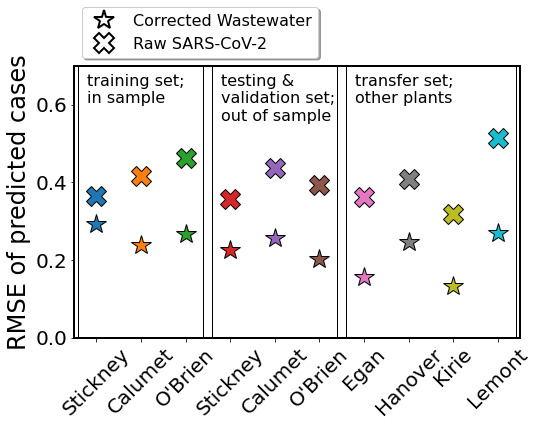

In [29]:
mycolors = mycolorsorig
uselags = np.arange(-10,10,1)
show_corr_plot=False
trainbox = [-.4,0,2.8,.7]
testbox = [2.6,0,2.8,.7]
transferbox = [5.6,0,3.8,.7]
if show_corr_plot:
    plt.figure(figsize=(15,8))
mylags = pd.DataFrame()
mycorrs = pd.DataFrame()
mylags['catchment'] = catches_correlation
mycorrs['catchment'] = catches_correlation
for (ww,label,lin) in zip(usewws,wwlabs,['--','-']):
    mylag = []
    mycorr = []
    for n,catch in enumerate(catches_correlation):
        if n<3:
            startdate = '2020-10-16'
            enddate = '2021-08-28'
        elif n<6:
            startdate = '2021-10-23'
            enddate = '2022-01-01'
        else:
            startdate = '2020-10-16'
            enddate = '2022-01-01'
        maskp = (prevdf.catchment==catch.replace('Stickney Full','Stickney')) & (prevdf[altprev]>0)
        maskw = (wbe1.catchment==catch) & (wbe1.date>=startdate) & (wbe1.date<=enddate) & (wbe1.orig_raw>ww_lod)
        wdf = wbe1[maskw][['date',ww]].copy()
        if ww == 'orig-raw_data':
            wdf[ww] = wdf[ww]*10**(-paramdfsmallnone[(paramdfsmallnone.fit=='orig-raw_data') & (paramdfsmallnone.feature==catch)].params.iloc[0])
        else:
            wdf[ww] = wdf[ww]*10**(-paramdfsmallfixed[(paramdfsmallfixed.fit=='orig-'+datatype) & (paramdfsmallfixed.feature==catch)].params.iloc[0])
        pdf = prevdf[maskp][['date',altprev]].copy()
        wdf[ww] = np.log10(wdf[ww])
        pdf[altprev] = np.log10(pdf[altprev])
        mycors = crosscorrW(wdf,pdf,lags=uselags+prevlagdict[altprev],rmse=True)
        if show_corr_plot:
            plt.plot(uselags+prevlagdict[altprev],mycors,lin,color=mycolors[n],label=catch+', '+ww)
        mylag.append(uselags[np.argmax(mycors)]+prevlagdict[altprev])
        mycorr.append(mycors[uselags==lag])
    mylags[label] = np.round(mylag,4)
    mycorrs[label] = np.round(mycorr,4)
mycorrs['% change'] = np.round((mycorrs[wwlabs[0]]-mycorrs[wwlabs[1]])/mycorrs[wwlabs[0]],4)
print('Using lag =',lag)
display(mycorrs)
if show_corr_plot:
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()
fig,ax = plt.subplots(figsize=(8,5))
for n,catch in enumerate(catches_correlation):
    for (ww,star) in zip(wwlabs,['X','*']):
        plt.plot(n,mycorrs[ww].iloc[n],star,markeredgecolor='black',color=mycolors[n],markersize=20)
plt.plot(10,60,'*',color='black',markersize=20,markeredgewidth=2,markerfacecolor='None',label=wwlabs[1])
plt.plot(10,50,'X',color='black',markersize=20,markeredgewidth=2,markerfacecolor='None',label=wwlabs[0])
for box,txt in zip([trainbox,testbox,transferbox],
                   ['training set;\nin sample','testing &\nvalidation set;\nout of sample',
                    'transfer set;\nother plants']):
    ax.add_patch(Rectangle((box[0],box[1]), box[2], box[3], fill=None, alpha=1))
    plt.annotate(txt,xy=(1,1),xycoords='figure fraction',
                   xytext=(box[0]+.2, box[1]+box[3]-.02), textcoords='data',
                   horizontalalignment='left',verticalalignment='top',fontsize=16)
ax.set_xlim([-.5,len(catches_correlation)-.5])
ax.set_xticks(range(len(catches_correlation)))
ax.set_xticklabels([catch.replace(' Full','').replace('OBrien',"O'Brien") for catch in catches_correlation],
                   rotation=45)
ax.set_ylim([0,0.7])
ax.set_ylabel('RMSE of predicted cases',fontsize=fs2)
ledge = plt.legend(loc='lower left', bbox_to_anchor=(0,1), shadow=True, fancybox=True, numpoints=1,ncol=1,fontsize=16)#bbox_to_anchor=(0.0, 0.83)
plt.show()
 

### Sup Figure 7

In [30]:
aictestall = pd.DataFrame()
ww = 'pmmov_bcov_norm'
p = 6
# p = 3
for window in [24,28,32,36,40,44,48,52]:
    enddates = pd.date_range(end=datetime.datetime.strptime('2021-11-09','%Y-%m-%d').date(), 
                                 periods=int(28-window/2),freq='2W-SAT').strftime('%Y-%m-%d').tolist()
    startdates = [(datetime.datetime.strptime(date,'%Y-%m-%d').date()-datetime.timedelta(weeks=int(window))).strftime('%Y-%m-%d') for date in enddates]

    startdate = '2021-11-06'
    enddate = '2021-12-31'
    print('window is',window,'weeks')
    for (start,end) in zip(startdates,enddates):
        print(start,end)
        wbe2 = wbe.copy()
        wbe2 = CalculateModelFitsFromParams(wbe2,paramdfwindow[(paramdfwindow.window==window) & (paramdfwindow.start==start)],ww_lod,'comb',3,'hospital admissions')

        mask = (wbe2.catchment.isin(whatiscomb)) & (wbe2.orig_raw>ww_lod) & (wbe2.date<'2022-01-01')
        datax = wbe2[mask][['date','catchment',ww,'orig_raw']].copy()
        datax.catchment = datax.catchment.replace('Stickney Full','Stickney')
        dataz = prevdf[(prevdf.catchment.isin([catch.replace(' Full','') for catch in whatiscomb])) & (prevdf.date<'2022-02-01')][['date','catchment','hospital admissions']].copy()
        dataz.date -= datetime.timedelta(days=int(6))
        mydf2 = pd.merge(datax,dataz,on=['date','catchment'],how='inner')
        mask = (mydf2.date<'2022-01-01') & (mydf2.date>startdate)
        y = np.log10(mydf2[mask]['hospital admissions'])
        yhat = np.log10(mydf2[mask][ww])
        meanhosp = np.mean(np.log10(mydf2[(mydf2.date<=end) & (mydf2.date>=start)]['hospital admissions']))
        meanraw = np.mean(np.log10(mydf2[(mydf2.date<=end) & (mydf2.date>=start)]['orig_raw']))
        meancor = np.mean(np.log10(mydf2[(mydf2.date<=end) & (mydf2.date>=start)][ww]))
        stdhosp = np.std(np.log10(mydf2[(mydf2.date<=end) & (mydf2.date>=start)]['hospital admissions']))
        stdraw = np.std(np.log10(mydf2[(mydf2.date<=end) & (mydf2.date>=start)]['orig_raw']))
        stdcor = np.std(np.log10(mydf2[(mydf2.date<=end) & (mydf2.date>=start)][ww]))
        mse = mean_squared_error(y,yhat)
        aictest = len(y)*np.log(mse*2*np.pi*np.exp(1)) + 2*p
        aictestall = pd.concat([aictestall,pd.DataFrame({
                                'window':window,'start':start,'end':end,'aictest':aictest,'meanhosp':meanhosp,'meanraw':meanraw,'meancor':meancor,
                                'stdhosp':stdhosp,'stdraw':stdraw,'stdcor':stdcor},index=[0])],ignore_index=True)

window is 24 weeks
2020-10-24 2021-04-10
2020-11-07 2021-04-24
2020-11-21 2021-05-08
2020-12-05 2021-05-22
2020-12-19 2021-06-05
2021-01-02 2021-06-19
2021-01-16 2021-07-03
2021-01-30 2021-07-17
2021-02-13 2021-07-31
2021-02-27 2021-08-14
2021-03-13 2021-08-28
2021-03-27 2021-09-11
2021-04-10 2021-09-25
2021-04-24 2021-10-09
2021-05-08 2021-10-23
2021-05-22 2021-11-06
window is 28 weeks
2020-10-24 2021-05-08
2020-11-07 2021-05-22
2020-11-21 2021-06-05
2020-12-05 2021-06-19
2020-12-19 2021-07-03
2021-01-02 2021-07-17
2021-01-16 2021-07-31
2021-01-30 2021-08-14
2021-02-13 2021-08-28
2021-02-27 2021-09-11
2021-03-13 2021-09-25
2021-03-27 2021-10-09
2021-04-10 2021-10-23
2021-04-24 2021-11-06
window is 32 weeks
2020-10-24 2021-06-05
2020-11-07 2021-06-19
2020-11-21 2021-07-03
2020-12-05 2021-07-17
2020-12-19 2021-07-31
2021-01-02 2021-08-14
2021-01-16 2021-08-28
2021-01-30 2021-09-11
2021-02-13 2021-09-25
2021-02-27 2021-10-09
2021-03-13 2021-10-23
2021-03-27 2021-11-06
window is 36 weeks


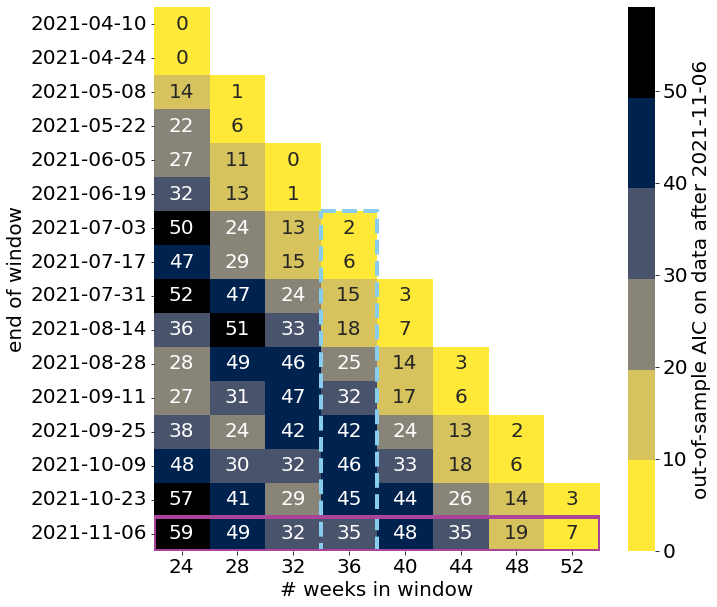

In [31]:
aictestall['aictest'] = aictestall['aictest']-np.min(aictestall['aictest'])
plt.figure(figsize=(10,10))
ax = plt.gca()
sns.heatmap(data=aictestall.pivot_table(index='end',columns='window')['aictest'],annot=True, fmt=".0f",cmap=aic_colormap(),
            cbar_kws={'label': 'out-of-sample AIC on data after 2021-11-06'},ax=ax)
ax.add_patch(Rectangle((3,6), 1, 10, fill=None, color=mycolorscb[3],linestyle = '--',linewidth=4,alpha=1))
ax.add_patch(Rectangle((0,15), 8, 1,fill=None, color=mycolorscb[0],linewidth=4,alpha=1))
plt.xlabel('# weeks in window')
plt.ylabel('end of window')
plt.show()

### Sup Figure 8

In [32]:
lag = 3
useprev_single = 'hospital admissions'
datatype = 'pmmov_bcov_flow_norm'
usewwsnew = ['orig-raw_data',datatype,'pmmov_bcov_norm']

In [33]:
fulldf = rolling_trend_analysis(wbe,prevdf,catches_shortlist,useprevs_trendflags,usewwsnew,
                                firstdate,lastdate,num_weeks_ww,num_weeks_prev,showfig=False)
datedf = trend_trajectory(fulldf,catches_shortlist,useprevs_trendflags,usewwsnew,prev_CI,ww_CI,
                          prev_daythresh,ww_daythresh,num_weeks_ww,firstdate,lastdate,showfig=False)

In [34]:
altprev = 'hospital admissions'
wbe1 = pd.read_csv(wbefile, parse_dates=['date'])
wbe1.rename(columns={'wrp':'catchment','sarscov2':'raw_data'},inplace=True)
paramdfsmallnone,aicdfsmall,pdfsmall,aicfulldfsmall = FitModelParameters(wbe1[wbe1.date<'2021-08-28'],prevdf,['comb'],[altprev],
                                                 ['raw_data'],['Egan','Hanover','Kirie','Lemont'],'2021-08-28',
                                                 [lag],ww_lod,prevlagdict,prevenddate)
display(paramdfsmallnone[paramdfsmallnone.fit=='orig-raw_data'])
wbe1 = CalculateModelFitsFromParams(wbe1,paramdf,ww_lod,wwtp,lag,useprev_single,scaleparam=False)
paramdfsmallfixed,aicdfsmall,pdfsmall,aicfulldfsmall = FitModelParameters(wbe1[wbe1.date<'2021-08-28'],prevdf,['comb'],[altprev],
                                                 [datatype,'pmmov_bcov_norm'],['Egan','Hanover','Kirie','Lemont'],'2021-08-28',
                                                 [lag],ww_lod,prevlagdict,prevenddate)
display(paramdfsmallfixed[paramdfsmallfixed.fit=='orig-'+datatype])

lag: 3 , catch:  comb


wwtp              prevind            fit  feature lag    params        lb  \
0  comb  hospital admissions  orig-raw_data     Egan   3  4.862366  4.683191   
1  comb  hospital admissions  orig-raw_data  Hanover   3  4.849260  4.670085   
2  comb  hospital admissions  orig-raw_data    Kirie   3  4.340396  4.161221   
3  comb  hospital admissions  orig-raw_data   Lemont   3  4.925912  4.754704   

         ub  
0  5.041541  
1  5.028435  
2  4.519571  
3  5.097120

lag: 3 , catch:  comb


wwtp              prevind                        fit  feature lag  \
0  comb  hospital admissions  orig-pmmov_bcov_flow_norm     Egan   3   
1  comb  hospital admissions  orig-pmmov_bcov_flow_norm  Hanover   3   
2  comb  hospital admissions  orig-pmmov_bcov_flow_norm    Kirie   3   
3  comb  hospital admissions  orig-pmmov_bcov_flow_norm   Lemont   3   

     params        lb        ub  
0  0.537727  0.467621  0.607834  
1  0.760780  0.688641  0.832919  
2  0.224871  0.148073  0.301668  
3  1.613588  1.508428  1.718748

Using lag = 3


catchment  Raw SARS-CoV-2  Corrected Wastewater  original model  % change
0  Stickney          0.3742                0.1967          0.1977    0.4743
1   Calumet          0.4250                0.1699          0.1776    0.6002
2    OBrien          0.5070                0.2293          0.2371    0.5477
3  Stickney          0.4519                0.1426          0.1310    0.6844
4   Calumet          0.5183                0.1336          0.1141    0.7422
5    OBrien          0.4539                0.1826          0.1675    0.5977
6      Egan          0.3390                0.1260          0.1193    0.6283
7   Hanover          0.4003                0.2137          0.2241    0.4662
8     Kirie          0.3323                0.1367          0.1328    0.5886
9    Lemont          0.5052                0.1602          0.1640    0.6829

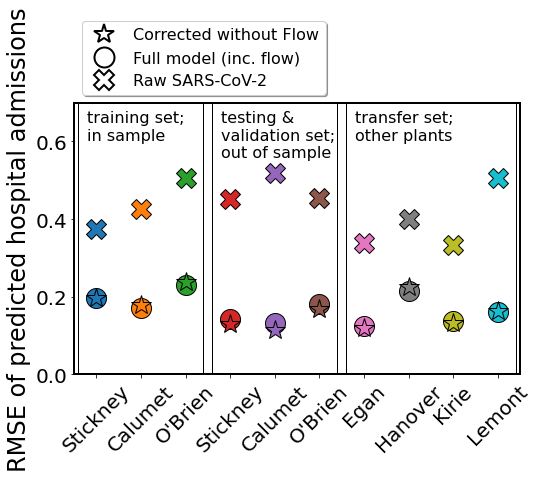

In [35]:
fs1 = 22 # tick labels 
fs2 = 24 # axis label
fs3 = 20 # legend & training annotation
mycolors = mycolorsorig
uselags = np.arange(-10,10,1)
show_corr_plot=False
trainbox = [-.4,0,2.8,.7]
testbox = [2.6,0,2.8,.7]
transferbox = [5.6,0,3.8,.7]
if show_corr_plot:
    plt.figure(figsize=(15,8))
mylags = pd.DataFrame()
mycorrs = pd.DataFrame()
mylags['catchment'] = catches_correlation
mycorrs['catchment'] = catches_correlation
for (ww,label,lin) in zip(usewwsnew+['pmmov_bcov_norm'],wwlabs+['original model'],['--','-','-.']):
    mylag = []
    mycorr = []
    for n,catch in enumerate(catches_correlation):
        if n<3:
            startdate = '2020-10-16'
            enddate = '2021-08-28'
        elif n<6:
            startdate = '2021-10-23'
            enddate = '2022-01-01'
        else:
            startdate = '2020-10-16'
            enddate = '2022-01-01'
        maskp = (prevdf.catchment==catch.replace('Stickney Full','Stickney')) & (prevdf[altprev]>0)
        maskw = (wbe.catchment==catch) & (wbe.date>=startdate) & (wbe.date<=enddate) & (wbe.orig_raw>ww_lod)
        wdf = wbe[maskw][['date',ww]].copy()
        if catch in ['Egan','Kirie','Hanover','Lemont']:
            if ww == 'orig-raw_data':
                wdf[ww] = wdf[ww]*10**(-paramdfsmallnone[(paramdfsmallnone.fit=='orig-raw_data') & (paramdfsmallnone.feature==catch)].params.iloc[0])
            elif ww == 'pmmov_bcov_flow_norm':
                wdf[ww] = wdf[ww]*10**(-paramdfsmallfixed[(paramdfsmallfixed.fit=='orig-'+datatype) & (paramdfsmallfixed.feature==catch)].params.iloc[0])
            else:
                wdf[ww] = wdf[ww]*10**(-paramdfsmallfixed[(paramdfsmallfixed.fit=='orig-pmmov_bcov_norm') & (paramdfsmallfixed.feature==catch)].params.iloc[0])
        pdf = prevdf[maskp][['date',altprev]].copy()
        wdf[ww] = np.log10(wdf[ww])
        pdf[altprev] = np.log10(pdf[altprev])
        mycors = crosscorrW(wdf,pdf,lags=uselags+prevlagdict[altprev],rmse=True)
        if show_corr_plot:
            plt.plot(uselags+prevlagdict[altprev],mycors,lin,color=mycolors[n],label=catch+', '+ww)
        mylag.append(uselags[np.argmax(mycors)]+prevlagdict[altprev])
        mycorr.append(mycors[uselags==lag])
    mylags[label] = np.round(mylag,4)
    mycorrs[label] = np.round(mycorr,4)
mycorrs['% change'] = np.round((mycorrs[wwlabs[0]]-mycorrs[wwlabs[1]])/mycorrs[wwlabs[0]],4)
print('Using lag =',lag)
display(mycorrs)
if show_corr_plot:
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()
fig,ax = plt.subplots(figsize=(8,5))
for n,catch in enumerate(catches_correlation):
    for (ww,star) in zip(wwlabs+['original model'],['X','o','*']):
        plt.plot(n,mycorrs[ww].iloc[n],star,markeredgecolor='black',color=mycolors[n],markersize=20)
plt.plot(10,60,'*',color='black',markersize=20,markeredgewidth=2,markerfacecolor='None',label='Corrected without Flow')
plt.plot(10,50,'o',color='black',markersize=20,markeredgewidth=2,markerfacecolor='None',label='Full model (inc. flow)')
plt.plot(10,50,'X',color='black',markersize=20,markeredgewidth=2,markerfacecolor='None',label=wwlabs[0])
for box,txt in zip([trainbox,testbox,transferbox],
                   ['training set;\nin sample','testing &\nvalidation set;\nout of sample',
                    'transfer set;\nother plants']):
    ax.add_patch(Rectangle((box[0],box[1]), box[2], box[3], fill=None, alpha=1))
    plt.annotate(txt,xy=(1,1),xycoords='figure fraction',
                   xytext=(box[0]+.2, box[1]+box[3]-.02), textcoords='data',
                   horizontalalignment='left',verticalalignment='top',fontsize=16)
ax.set_xlim([-.5,len(catches_correlation)-.5])
ax.set_xticks(range(len(catches_correlation)))
ax.set_xticklabels([catch.replace(' Full','').replace('OBrien',"O'Brien") for catch in catches_correlation],
                   rotation=45)
ax.set_ylim([0,0.7])
ax.set_ylabel('RMSE of predicted hospital admissions',fontsize=fs2)
ledge = plt.legend(loc='lower left', bbox_to_anchor=(0,1), shadow=True, fancybox=True, numpoints=1,ncol=1,fontsize=16)#bbox_to_anchor=(0.0, 0.83)
plt.show()
 

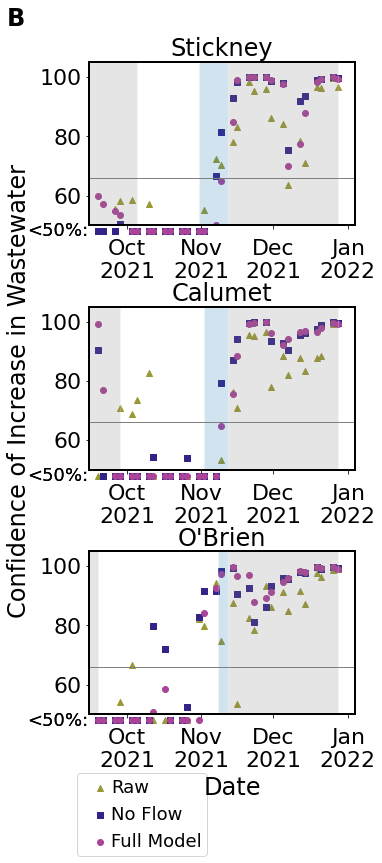

In [36]:
fs1 = 22 # tick labels
fs2 = 24 # axis labels
fs3 = 18 # legend
fs4 = 18 # flags
wws = usewwsnew[:2]    
num_weeks = num_weeks_ww
add_surge_arrows=False
add_surge_arrows2=False
n = 0
showdate = '2021-09-15'
datalabel = 'Corrected Wastewater'
fig = plt.figure(figsize=(21,12))
gs = fig.add_gridspec(len(catches_shortlist), 2, wspace=.4, hspace=.5,width_ratios=[8,3])
axs = [fig.add_subplot(gs[c, 1]) for c in range(3)]
surgedf = pd.DataFrame(columns={'catchment','date','source','surge'})
for c, catch in enumerate(catches_shortlist):    
    for m,usedata in enumerate(np.array(usewwsnew)[np.r_[0,2,1]]):
        mdf2 = fulldf[(fulldf.datatype==usedata) & (fulldf.catchment==catch)].copy()
        if m==0: # if we're doing the prevalence indicator, not the wastewater indicator...['#AA4499','#999933','#332288','#88CCEE']
            ax = axs[c]
            ax1b = ax.twinx()
            ax.scatter(mdf2.date,mdf2[f'Confidence of {num_weeks} week Trend'],color='#999933',marker='^',label='Raw')
            ax1b.scatter(mdf2[(mdf2[f'Confidence of {num_weeks} week Trend']<50) & (mdf2.date>showdate)].date,
                         np.ones(len(mdf2[(mdf2[f'Confidence of {num_weeks} week Trend']<50) & (mdf2.date>showdate)])),color='#999933',marker='^',clip_on=False)
            ax.xaxis.set_tick_params(labelsize=fs1)
            ax.yaxis.set_tick_params(labelsize=fs1)
        elif m==1: # if we're doing a wastewater indicator
            ax = axs[c]
            ax.scatter(mdf2.date,mdf2[f'Confidence of {num_weeks} week Trend'],color='#332288',marker='s',label='No Flow')
            ax1b.scatter(mdf2[(mdf2[f'Confidence of {num_weeks} week Trend']<50) & (mdf2.date>showdate)].date,
                         np.ones(len(mdf2[(mdf2[f'Confidence of {num_weeks} week Trend']<50) & (mdf2.date>showdate)])),color='#332288',marker='s',clip_on=False)
            ax1b.text(x=(pd.to_datetime(showdate, format = '%Y-%m-%d')), y=1, s="<50%:", fontsize=fs4, 
                      color="black",horizontalalignment='right',verticalalignment='center')
        else:
            ax = axs[c]
            ax.scatter(mdf2.date,mdf2[f'Confidence of {num_weeks} week Trend'],color='#AA4499',marker='o',label='Full Model')
            ax1b.scatter(mdf2[(mdf2[f'Confidence of {num_weeks} week Trend']<50) & (mdf2.date>showdate)].date,
                         np.ones(len(mdf2[(mdf2[f'Confidence of {num_weeks} week Trend']<50) & (mdf2.date>showdate)])),color='#AA4499',marker='o',clip_on=False)
            ax1b.text(x=(pd.to_datetime(showdate, format = '%Y-%m-%d')), y=1, s="<50%:", fontsize=fs4, 
                      color="black",horizontalalignment='right',verticalalignment='center')
            ax1b.set_ylim([2,30])
            ax1b.set_yticks([])
            ax.axhline(y=66, xmin=0, xmax=1, color='tab:grey', linestyle='-', linewidth=1)
            ax.set_title(catch.replace(' Full','').replace('OBrien',"O'Brien"),fontsize=fs2)
            ylim = ax.get_ylim()
            ax.set_ylim(50,105)
            ax.set_xbound(lower=mdates.date2num(datetime.datetime.strptime(firstdate, '%Y-%m-%d')-pd.Timedelta(15,'days')),\
                                 upper=mdates.date2num(datetime.datetime.strptime(lastdate, '%Y-%m-%d')+pd.Timedelta(15,'days')))
            if c==2: # if it's the first one, do this stuff so the first one has a legend.
                l1 = ax.legend(bbox_to_anchor=(0.2,-0.9),loc='lower center',fontsize=fs3,borderaxespad=.3,\
                               handletextpad=-.4,borderpad=.3)
            # This is where we start ading the shaded regions and arrow flags, using fulldf and datedf information.
            date0 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata)].iloc[0].date
            date2 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==useprev_single) & 
                       (fulldf.date>date0.strftime('%Y-%m-%d')) & 
                       (fulldf[f'Confidence of {num_weeks} week Trend']<66)].iloc[0].date
            date3 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata) & 
                           (fulldf.date>=date2.strftime('%Y-%m-%d')) &
                           (fulldf[f'Confidence of {num_weeks} week Trend']<34)].iloc[0].date
            # This is the first grey area, from the first date to the "end" of that region.
            ax.axvspan(date0,date3, facecolor='tab:grey',edgecolor='white', alpha=.2)
            h = ax.get_ylim()
            # Now we'll loop over the flagged dates in the bedsused column.  These are the (three) major surges.
            numbeddates = len(datedf[catch+f' {useprevs_trendflags[-1]} {num_weeks}wk'].dropna())
            for d,mydateb in enumerate(datedf[catch+f' {useprevs_trendflags[-1]} {num_weeks}wk'].dropna()):
                if add_surge_arrows2:
                    ax.annotate('B',xy=(mydateb, h[0]+(.68)*(h[1]-h[0])), xycoords='data',
                        xytext=(mydateb, h[0]+(.98)*(h[1]-h[0])), textcoords='data',
                        arrowprops=dict(facecolor=mycolors[8], shrink=0.05),
                        horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                # 3 prevalence columns to look at
                cols = ['date']+[catch+f' {pr} {num_weeks_prev}wk' for pr in useprevs_trendflags]
                df1 = datedf[cols].set_index('date').dropna(how='all').reset_index()
                # first date that is triggered in one of the prev columns that is 
                # less than 21 days before the beds date for the current surge.
                date1 = df1[df1.date+datetime.timedelta(days=21)>mydateb.strftime('%Y-%m-%d')].iloc[0].date
                # shade this region from that date to the beds date in blue.
                ax.axvspan(date1,mydateb, facecolor='tab:blue', edgecolor='white',alpha=.2)
                # Now 4 columns - the three prev columns plus the wastewater column.
                cols = ['date',catch+' '+usedata+f' {num_weeks}wk']+ [catch+f' {pr} {num_weeks_prev}wk' for pr in useprevs_trendflags]
                df1 = datedf[cols].set_index('date').dropna(how='all').reset_index()
                # Now this is the first date in all those columns, including ww, that is less than 21 days before the beds date.
                date1 = df1[df1.date+datetime.timedelta(days=21)>mydateb.strftime('%Y-%m-%d')].iloc[0].date
                # This is just dates that are after the the last date (from the previous surge) 
                # that sensitive admissions had an increase, 
                # but before the beginning of the next surge.  
                # So this will be dates where admissions or cases get shown, and where ww is shown with red.
                df2 = df1[(df1.date-datetime.timedelta(days=5)>date0) & (df1.date<date1)].copy()
                for p,(mydat,ca) in enumerate(zip(useprevs_trendflags[:-1],plabs)):
                    for mydate in df1[(df1.date>=date1) & (df1.date<mydateb)][catch+' '+mydat+' 4wk'].dropna():
                        if add_surge_arrows2:
                            ax.annotate(ca,xy=(mydate, h[0]+(.55-p*.1)*(h[1]-h[0])), xycoords='data',
                                xytext=(mydate, h[0]+(.85-p*.1)*(h[1]-h[0])), textcoords='data',
                                arrowprops=dict(facecolor=mycolors[p*4+1], shrink=0.05),
                                horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                # Get the range for the next gray band.
                if d<numbeddates-1:
                    date2 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==useprev_single) & 
                               (fulldf.date>mydateb.strftime('%Y-%m-%d')) & 
                               (fulldf[f'Confidence of {num_weeks} week Trend']<66)].iloc[0].date
                    date3 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata) & 
                                   (fulldf.date>=date2.strftime('%Y-%m-%d')) &
                                   (fulldf[f'Confidence of {num_weeks} week Trend']<34)].iloc[0].date
                    ax.axvspan(mydateb,date3, facecolor='tab:grey',edgecolor='white', alpha=.2)
                    date0 = mydateb
                else:
                    date2 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata)].iloc[-1].date
                    date3 = date2
                    ax.axvspan(mydateb,date3, facecolor='tab:grey', edgecolor='white',alpha=.2)
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
            ax.xaxis.set_major_formatter(DateFormatter("%b\n%Y"))
            ax.tick_params(axis='x', which='major', pad=10)
            ax.set_xbound(lower=mdates.date2num(datetime.datetime.strptime(showdate, '%Y-%m-%d')),\
                                 upper=mdates.date2num(datetime.datetime.strptime(lastdate, '%Y-%m-%d')+pd.Timedelta(3,'days')))
fig.text(0.8, 0.04, 'Date', va='center', rotation='horizontal',fontsize=fs2)
fig.text(0.67, 0.5, 'Confidence of Increase in Wastewater', va='center', rotation='vertical',fontsize=fs2)
fig.text(0.67, 0.93, 'B', va='center', rotation='horizontal',fontsize=fs2,weight='bold')
plt.show()


### Sup Table 5

#### All terms, admissions, lag = 3

In [37]:
lag = 3
useprev_single = 'hospital admissions'
datatype = 'pmmov_bcov_flow_norm'
usewwsnew = ['orig-raw_data',datatype,'pmmov_bcov_norm']

In [38]:
fulldf = rolling_trend_analysis(wbe,prevdf,catches_shortlist,useprevs_trendflags,usewwsnew,
                                firstdate,lastdate,num_weeks_ww,num_weeks_prev,showfig=False)
datedf = trend_trajectory(fulldf,catches_shortlist,useprevs_trendflags,usewwsnew,prev_CI,ww_CI,
                          prev_daythresh,ww_daythresh,num_weeks_ww,firstdate,lastdate,showfig=False)

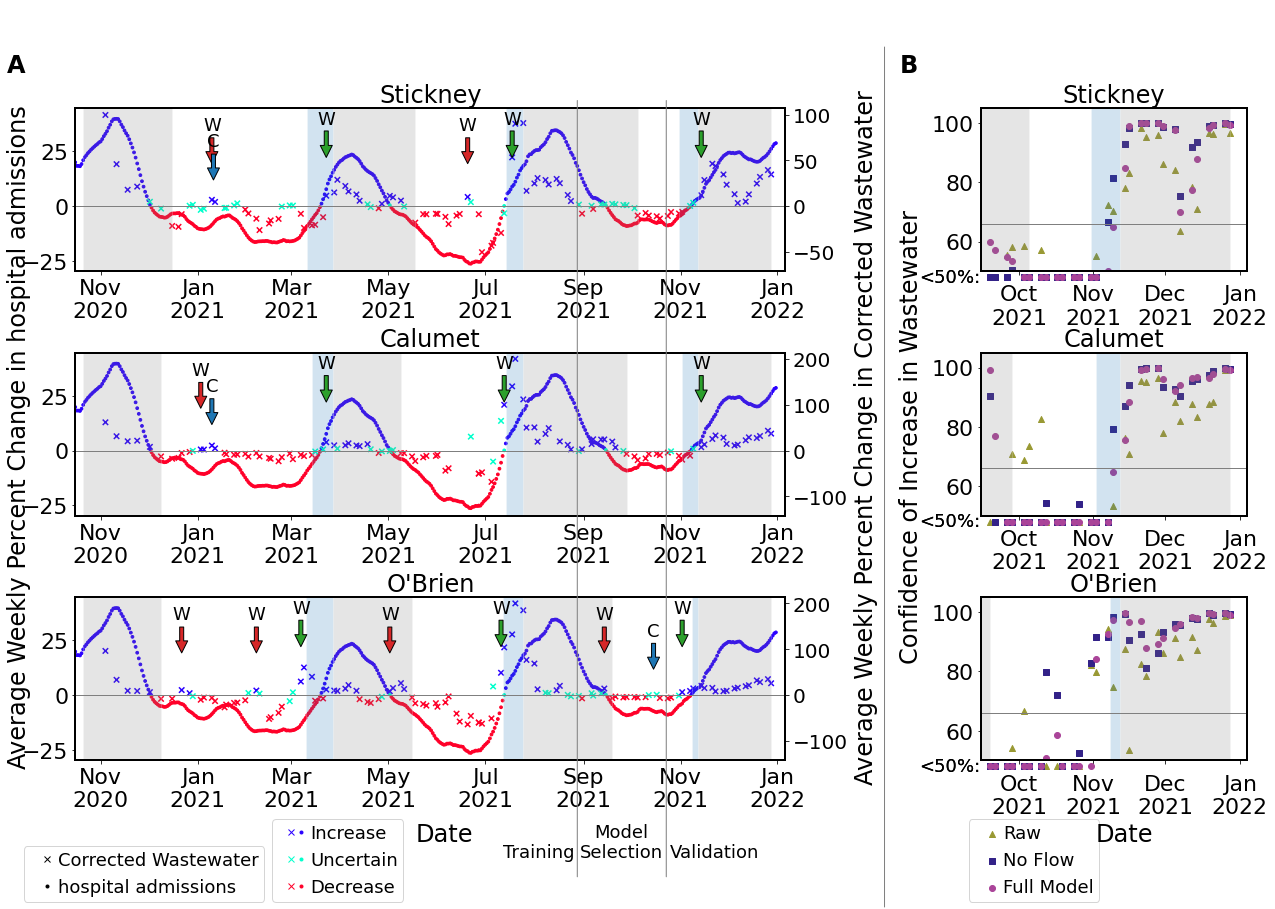

In [39]:
fs1 = 22 # tick labels
fs2 = 24 # axis labels
fs3 = 18 # legend
fs4 = 18 # flags
wws = usewwsnew[:2]    
num_weeks = num_weeks_ww
add_surge_arrows=False
add_surge_arrows2=False
n = 0
showdate = '2021-09-15'
datalabel = 'Corrected Wastewater'
# fig = plt.figure(figsize=(14,len(catches_shortlist)*3+1))
fig = plt.figure(figsize=(21,12))
gs = fig.add_gridspec(len(catches_shortlist), 2, wspace=.4, hspace=.5,width_ratios=[8,3])
axs = gs.subplots()
surgedf = pd.DataFrame(columns={'catchment','date','source','surge'})
for c, catch in enumerate(catches_shortlist):
    for m,usedata in enumerate([useprev_single,datatype]):
        mdf2 = fulldf[(fulldf.datatype==usedata) & (fulldf.catchment==catch)].copy()
        if m==0: # if we're doing the prevalence indicator, not the wastewater indicator...
            ax = axs[c,0]
            ax.scatter(mdf2.date,np.minimum(mdf2[f'Percent Change Weekly over {num_weeks} weeks'],200),\
                       c=mdf2[f'Confidence of {num_weeks} week Trend'].apply(lambda x:discrete_color(x)),\
                            s=30,cmap=newmap,marker='.')
            ax.set_title(catch.replace(' Full','').replace('OBrien',"O'Brien"),fontsize=fs2)
            ylim = ax.get_ylim()
            ax.set_ylim(-ylim[1]/1.5,ylim[1])
            ax.xaxis.set_tick_params(labelsize=fs1)
            ax.yaxis.set_tick_params(labelsize=fs1)
        else: # if we're doing a wastewater indicator
            ax = axs[c,0].twinx()
            sp = ax.scatter(mdf2.date,np.minimum(mdf2[f'Percent Change Weekly over {num_weeks} weeks'],200),\
                            c=mdf2[f'Confidence of {num_weeks} week Trend'].apply(lambda x:discrete_color(x)),\
                            s=30,cmap=newmap,marker='x')
            ax.axhline(y=0, xmin=0, xmax=1, color='tab:grey', linestyle='-', linewidth=1)
            ylim = ax.get_ylim()
            ax.set_ylim(-ylim[1]/1.5,ylim[1])
            ax.set_xbound(lower=mdates.date2num(datetime.datetime.strptime(firstdate, '%Y-%m-%d')-pd.Timedelta(5,'days')),\
                                 upper=mdates.date2num(datetime.datetime.strptime(lastdate, '%Y-%m-%d')+pd.Timedelta(5,'days')))
            if c==2: # if it's the first one, do this stuff so the first one has a legend.
                ax.plot(0,0,'x',color='black',label='Corrected Wastewater')
                ax.plot(0,0,'.',color='black',label=useprev_single.replace('sensitive admissions','Hospital Admissions'))
                l1 = ax.legend(bbox_to_anchor=(-0.08,-0.9),loc='lower left',fontsize=fs3,borderaxespad=.3,\
                               handletextpad=-.4,borderpad=.3)
                ax1 = ax
                p1, = ax1.plot(0,0,'x',color=newmap.colors[6])
                p2, = ax1.plot(0,0,'.',color=newmap.colors[6])
                p3, = ax1.plot(0,0,'x',color=newmap.colors[3])
                p4, = ax1.plot(0,0,'.',color=newmap.colors[3])
                p5, = ax1.plot(0,0,'x',color=newmap.colors[0])
                p6, = ax1.plot(0,0,'.',color=newmap.colors[0])
                ax.add_artist(l1)
                l = ax1.legend([(p1, p2), (p3, p4), (p5, p6)],\
                               ['Increase', 'Uncertain','Decrease'],\
                               handler_map={tuple: HandlerTuple(ndivide=None,pad=-.9)},borderaxespad=.3,\
                               bbox_to_anchor=(0.27,-0.9),loc='lower left',fontsize=fs3,handletextpad=-.2,borderpad=.3)
            # This is where we start ading the shaded regions and arrow flags, using fulldf and datedf information.
            date0 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata)].iloc[0].date
            date2 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==useprev_single) & 
                       (fulldf.date>date0.strftime('%Y-%m-%d')) & 
                       (fulldf[f'Confidence of {num_weeks} week Trend']<66)].iloc[0].date
            date3 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata) & 
                           (fulldf.date>=date2.strftime('%Y-%m-%d')) &
                           (fulldf[f'Confidence of {num_weeks} week Trend']<34)].iloc[0].date
            # This is the first grey area, from the first date to the "end" of that region.
            plt.axvspan(date0,date3, facecolor='tab:grey',edgecolor='white', alpha=.2)
            h = ax.get_ylim()
            # Now we'll loop over the flagged dates in the bedsused column.  These are the (three) major surges.
            numbeddates = len(datedf[catch+f' {useprevs_trendflags[-1]} {num_weeks}wk'].dropna())
            for d,mydateb in enumerate(datedf[catch+f' {useprevs_trendflags[-1]} {num_weeks}wk'].dropna()):
                surgedf = pd.concat([surgedf,pd.DataFrame({
                    'catchment':catch.replace(' Full',''),'date':mydateb.date(),
                    'source':useprevs_trendflags[-1].split(' ')[1],'surge':str(mydateb.date())+'-surge'},index=[0])],axis=0,ignore_index=True)
                if add_surge_arrows:
                    ax.annotate('B',xy=(mydateb, h[0]+(.68)*(h[1]-h[0])), xycoords='data',
                        xytext=(mydateb, h[0]+(.98)*(h[1]-h[0])), textcoords='data',
                        arrowprops=dict(facecolor=mycolors[8], shrink=0.05),
                        horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                # 3 prevalence columns to look at
                cols = ['date']+[catch+f' {pr} {num_weeks_prev}wk' for pr in useprevs_trendflags]
                df1 = datedf[cols].set_index('date').dropna(how='all').reset_index()
                # first date that is triggered in one of the prev columns that is 
                # less than 21 days before the beds date for the current surge.
                date1 = df1[df1.date+datetime.timedelta(days=21)>mydateb.strftime('%Y-%m-%d')].iloc[0].date
                # shade this region from that date to the beds date in blue.
                plt.axvspan(date1,mydateb, facecolor='tab:blue', edgecolor='white',alpha=.2)
                # Now 4 columns - the three prev columns plus the wastewater column.
                cols = ['date',catch+' '+usedata+f' {num_weeks}wk']+ [catch+f' {pr} {num_weeks_prev}wk' for pr in useprevs_trendflags]
                df1 = datedf[cols].set_index('date').dropna(how='all').reset_index()
                # Now this is the first date in all those columns, including ww, that is less than 21 days before the beds date.
                date1 = df1[df1.date+datetime.timedelta(days=21)>mydateb.strftime('%Y-%m-%d')].iloc[0].date
                # This is just dates that are after the the last date (from the previous surge) 
                # that sensitive admissions had an increase, 
                # but before the beginning of the next surge.  
                # So this will be dates where admissions or cases get shown, and where ww is shown with red.
#                     df2 = df1[(df1.date>date2) & (df1.date<date1)].copy()
                df2 = df1[(df1.date-datetime.timedelta(days=5)>date0) & (df1.date<date1)].copy()
                # Loop over wastewater dates where the date is within the range of associated with the surge, label green.
                for mydate in df1[(df1.date>=date1) & (df1.date-datetime.timedelta(days=5)<mydateb)][catch+' '+usedata+f' {num_weeks}wk'].dropna():
                    ax.annotate('W',xy=(mydate, h[0]+.69*(h[1]-h[0])), xycoords='data',
                        xytext=(mydate, h[0]+.99*(h[1]-h[0])), textcoords='data',
                        arrowprops=dict(facecolor='tab:green', shrink=0.04),
                        horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                    surgedf = pd.concat([surgedf,pd.DataFrame({
                        'catchment':catch.replace(' Full',''),'date':mydate.date(),
                        'source':'wastewater','surge':str(mydateb.date())+'-surge'},index=[0])],axis=0,ignore_index=True)
                # Loop over wastewater dates where the date is out of that range, label red.
                for mydate in df2[catch+' '+usedata+f' {num_weeks}wk'].dropna():
                    ax.annotate('W',xy=(mydate, h[0]+.65*(h[1]-h[0])), xycoords='data',
                        xytext=(mydate, h[0]+.95*(h[1]-h[0])), textcoords='data',
                        arrowprops=dict(facecolor='tab:red', shrink=0.05),
                        horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                    surgedf = pd.concat([surgedf,pd.DataFrame({
                        'catchment':catch.replace(' Full',''),'date':mydate.date(),
                        'source':'wastewater','surge':str(mydateb.date())+', pre:'+str(mydate.date())},
                        index=[0])],axis=0,ignore_index=True)
                # Loop over cases and admissions dates that are out of that range, label.
                for p,(mydat,ca) in enumerate(zip(useprevs_trendflags[:-1],plabs)):
                    for mydate in df2[catch+' '+mydat+f' {num_weeks}wk'].dropna():
                        ax.annotate(ca,xy=(mydate, h[0]+(.55-p*.1)*(h[1]-h[0])), xycoords='data',
                            xytext=(mydate, h[0]+(.85-p*.1)*(h[1]-h[0])), textcoords='data',
                            arrowprops=dict(facecolor=mycolors[p*4], shrink=0.05),
                            horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                        surgedf = pd.concat([surgedf,pd.DataFrame({
                            'catchment':catch.replace(' Full',''),'date':mydate.date(),
                            'source':mydat.split(' ')[1],'surge':str(mydateb.date())+', pre:'+str(mydate.date())},
                            index=[0])],axis=0,ignore_index=True)
                for p,(mydat,ca) in enumerate(zip(useprevs_trendflags[:-1],plabs)):
                    for mydate in df1[(df1.date>=date1) & (df1.date<mydateb)][catch+' '+mydat+' 4wk'].dropna():
                        if add_surge_arrows:
                            ax.annotate(ca,xy=(mydate, h[0]+(.55-p*.1)*(h[1]-h[0])), xycoords='data',
                                xytext=(mydate, h[0]+(.85-p*.1)*(h[1]-h[0])), textcoords='data',
                                arrowprops=dict(facecolor=mycolors[p*4+1], shrink=0.05),
                                horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                        surgedf = pd.concat([surgedf,pd.DataFrame({
                            'catchment':catch.replace(' Full',''),'date':mydate.date(),
                            'source':mydat.split(' ')[1],'surge':str(mydateb.date())+'-surge'},
                            index=[0])],axis=0,ignore_index=True)
                # Get the range for the next gray band.
                if d<numbeddates-1:
                    date2 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==useprev_single) & 
                               (fulldf.date>mydateb.strftime('%Y-%m-%d')) & 
                               (fulldf[f'Confidence of {num_weeks} week Trend']<66)].iloc[0].date
                    date3 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata) & 
                                   (fulldf.date>=date2.strftime('%Y-%m-%d')) &
                                   (fulldf[f'Confidence of {num_weeks} week Trend']<34)].iloc[0].date
                    plt.axvspan(mydateb,date3, facecolor='tab:grey',edgecolor='white', alpha=.2)
                    date0 = mydateb
                else:
                    date2 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata)].iloc[-1].date
                    date3 = date2
#                     plt.axvline(x=mydateb, color='white')
                    plt.axvspan(mydateb,date3, facecolor='tab:grey', edgecolor='white',alpha=.2)
#                     print(catch,date1,mydateb,date2,date3)
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
            ax.xaxis.set_major_formatter(DateFormatter("%b\n%Y"))
            ax.set_xbound(lower=mdates.date2num(datetime.datetime.strptime(firstdate, '%Y-%m-%d')+pd.Timedelta(15,'days')),\
                                 upper=mdates.date2num(datetime.datetime.strptime(lastdate, '%Y-%m-%d')+pd.Timedelta(5,'days')))
    if c==2:
        ylim = ax.get_ylim()
        for d,align in zip(['2021-08-28','2021-10-23'],['right','right']):
            ax.annotate('', xy = (pd.to_datetime(d, format = '%Y-%m-%d'), 0), xycoords='data',
                        xytext = (pd.to_datetime(d, format = '%Y-%m-%d'), -400), textcoords='data',
                        arrowprops=dict(arrowstyle="-",color='tab:grey'),
                        horizontalalignment='left', verticalalignment='top',fontsize=16)
            ax.annotate('', xy = (pd.to_datetime(d, format = '%Y-%m-%d'), 0), xycoords='data',
                        xytext = (pd.to_datetime(d, format = '%Y-%m-%d'), 1300), textcoords='data',
                        arrowprops=dict(arrowstyle="-",color='tab:grey'),
                        horizontalalignment='left', verticalalignment='top',fontsize=16)
    #         ax.annotate(datetime.datetime.strftime(pd.to_datetime(d,format = '%Y-%m-%d'),'%m/%d'), 
    #                 xy = (pd.to_datetime(d, format = '%Y-%m-%d'), ylim[-1]*.65), xycoords='data',
    #                 xytext = (pd.to_datetime(d, format = '%Y-%m-%d'), ylim[-1]*.65), textcoords='data',
    #                 horizontalalignment=align, verticalalignment='top',fontsize=12,rotation='vertical')
        for d,txt,align,vert,vert2 in zip(['2021-08-26','2021-09-25','2021-10-25'],
                               ['\n\n\n\nTraining','\n\n\nModel\nSelection','\n\n\n\nValidation'],
                               ['right','center','left'],[ylim[0]*.95,ylim[0]*.95,ylim[0]*.95],['top','top','top']):
            ax.annotate(txt,xy = (pd.to_datetime(d, format = '%Y-%m-%d'), ylim[0]), xycoords='data',
                    xytext = (pd.to_datetime(d, format = '%Y-%m-%d'), ylim[0]), textcoords='data',
                    horizontalalignment=align, verticalalignment=vert2,fontsize=fs3,rotation='horizontal')
        
    for m,usedata in enumerate(np.array(usewwsnew)[np.r_[0,2,1]]):
        mdf2 = fulldf[(fulldf.datatype==usedata) & (fulldf.catchment==catch)].copy()
        if m==0: # if we're doing the prevalence indicator, not the wastewater indicator...['#AA4499','#999933','#332288','#88CCEE']
            ax = axs[c,1]
            ax1b = ax.twinx()
            ax.scatter(mdf2.date,mdf2[f'Confidence of {num_weeks} week Trend'],color='#999933',marker='^',label='Raw')
            ax1b.scatter(mdf2[(mdf2[f'Confidence of {num_weeks} week Trend']<50) & (mdf2.date>showdate)].date,
                         np.ones(len(mdf2[(mdf2[f'Confidence of {num_weeks} week Trend']<50) & (mdf2.date>showdate)])),color='#999933',marker='^',clip_on=False)
#             ylim = ax.get_ylim()
#             ax.set_ylim(-5,105)
            ax.xaxis.set_tick_params(labelsize=fs1)
            ax.yaxis.set_tick_params(labelsize=fs1)
        elif m==1: # if we're doing a wastewater indicator
            ax = axs[c,1]
#             ax = axs[c].twinx()
            ax.scatter(mdf2.date,mdf2[f'Confidence of {num_weeks} week Trend'],color='#332288',marker='s',label='No Flow')
            ax1b.scatter(mdf2[(mdf2[f'Confidence of {num_weeks} week Trend']<50) & (mdf2.date>showdate)].date,
                         np.ones(len(mdf2[(mdf2[f'Confidence of {num_weeks} week Trend']<50) & (mdf2.date>showdate)])),color='#332288',marker='s',clip_on=False)
            ax1b.text(x=(pd.to_datetime(showdate, format = '%Y-%m-%d')), y=1, s="<50%:", fontsize=fs4, 
                      color="black",horizontalalignment='right',verticalalignment='center')
        else:
            ax = axs[c,1]
            ax.scatter(mdf2.date,mdf2[f'Confidence of {num_weeks} week Trend'],color='#AA4499',marker='o',label='Full Model')
            ax1b.scatter(mdf2[(mdf2[f'Confidence of {num_weeks} week Trend']<50) & (mdf2.date>showdate)].date,
                         np.ones(len(mdf2[(mdf2[f'Confidence of {num_weeks} week Trend']<50) & (mdf2.date>showdate)])),color='#AA4499',marker='o',clip_on=False)
            ax1b.text(x=(pd.to_datetime(showdate, format = '%Y-%m-%d')), y=1, s="<50%:", fontsize=fs4, 
                      color="black",horizontalalignment='right',verticalalignment='center')
            ax1b.set_ylim([2,30])
            ax1b.set_yticks([])
            ax.axhline(y=66, xmin=0, xmax=1, color='tab:grey', linestyle='-', linewidth=1)
            ax.set_title(catch.replace(' Full','').replace('OBrien',"O'Brien"),fontsize=fs2)
            ylim = ax.get_ylim()
            ax.set_ylim(50,105)
            ax.set_xbound(lower=mdates.date2num(datetime.datetime.strptime(firstdate, '%Y-%m-%d')-pd.Timedelta(15,'days')),\
                                 upper=mdates.date2num(datetime.datetime.strptime(lastdate, '%Y-%m-%d')+pd.Timedelta(15,'days')))
            if c==2: # if it's the first one, do this stuff so the first one has a legend.
#                 ax.plot(0,0,'x',color='black',label='Wastewater')
#                 ax.plot(0,0,'.',color='black',label=useprev_single.replace('sensitive admissions','Hosp Adm'))
                l1 = ax.legend(bbox_to_anchor=(0.2,-0.9),loc='lower center',fontsize=fs3,borderaxespad=.3,\
                               handletextpad=-.4,borderpad=.3)
            # This is where we start ading the shaded regions and arrow flags, using fulldf and datedf information.
            date0 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata)].iloc[0].date
            date2 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==useprev_single) & 
                       (fulldf.date>date0.strftime('%Y-%m-%d')) & 
                       (fulldf[f'Confidence of {num_weeks} week Trend']<66)].iloc[0].date
            date3 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata) & 
                           (fulldf.date>=date2.strftime('%Y-%m-%d')) &
                           (fulldf[f'Confidence of {num_weeks} week Trend']<34)].iloc[0].date
            # This is the first grey area, from the first date to the "end" of that region.
            ax.axvspan(date0,date3, facecolor='tab:grey',edgecolor='white', alpha=.2)
            h = ax.get_ylim()
            # Now we'll loop over the flagged dates in the bedsused column.  These are the (three) major surges.
            numbeddates = len(datedf[catch+f' {useprevs_trendflags[-1]} {num_weeks}wk'].dropna())
            for d,mydateb in enumerate(datedf[catch+f' {useprevs_trendflags[-1]} {num_weeks}wk'].dropna()):
                if add_surge_arrows2:
                    ax.annotate('B',xy=(mydateb, h[0]+(.68)*(h[1]-h[0])), xycoords='data',
                        xytext=(mydateb, h[0]+(.98)*(h[1]-h[0])), textcoords='data',
                        arrowprops=dict(facecolor=mycolors[8], shrink=0.05),
                        horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                # 3 prevalence columns to look at
                cols = ['date']+[catch+f' {pr} {num_weeks_prev}wk' for pr in useprevs_trendflags]
                df1 = datedf[cols].set_index('date').dropna(how='all').reset_index()
                # first date that is triggered in one of the prev columns that is 
                # less than 21 days before the beds date for the current surge.
                date1 = df1[df1.date+datetime.timedelta(days=21)>mydateb.strftime('%Y-%m-%d')].iloc[0].date
                # shade this region from that date to the beds date in blue.
                ax.axvspan(date1,mydateb, facecolor='tab:blue', edgecolor='white',alpha=.2)
                # Now 4 columns - the three prev columns plus the wastewater column.
                cols = ['date',catch+' '+usedata+f' {num_weeks}wk']+ [catch+f' {pr} {num_weeks_prev}wk' for pr in useprevs_trendflags]
                df1 = datedf[cols].set_index('date').dropna(how='all').reset_index()
                # Now this is the first date in all those columns, including ww, that is less than 21 days before the beds date.
                date1 = df1[df1.date+datetime.timedelta(days=21)>mydateb.strftime('%Y-%m-%d')].iloc[0].date
                # This is just dates that are after the the last date (from the previous surge) 
                # that sensitive admissions had an increase, 
                # but before the beginning of the next surge.  
                # So this will be dates where admissions or cases get shown, and where ww is shown with red.
#                     df2 = df1[(df1.date>date2) & (df1.date<date1)].copy()
                df2 = df1[(df1.date-datetime.timedelta(days=5)>date0) & (df1.date<date1)].copy()
                for p,(mydat,ca) in enumerate(zip(useprevs_trendflags[:-1],plabs)):
                    for mydate in df1[(df1.date>=date1) & (df1.date<mydateb)][catch+' '+mydat+' 4wk'].dropna():
                        if add_surge_arrows2:
                            ax.annotate(ca,xy=(mydate, h[0]+(.55-p*.1)*(h[1]-h[0])), xycoords='data',
                                xytext=(mydate, h[0]+(.85-p*.1)*(h[1]-h[0])), textcoords='data',
                                arrowprops=dict(facecolor=mycolors[p*4+1], shrink=0.05),
                                horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                # Get the range for the next gray band.
                if d<numbeddates-1:
                    date2 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==useprev_single) & 
                               (fulldf.date>mydateb.strftime('%Y-%m-%d')) & 
                               (fulldf[f'Confidence of {num_weeks} week Trend']<66)].iloc[0].date
                    date3 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata) & 
                                   (fulldf.date>=date2.strftime('%Y-%m-%d')) &
                                   (fulldf[f'Confidence of {num_weeks} week Trend']<34)].iloc[0].date
                    ax.axvspan(mydateb,date3, facecolor='tab:grey',edgecolor='white', alpha=.2)
                    date0 = mydateb
                else:
                    date2 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata)].iloc[-1].date
                    date3 = date2
#                     plt.axvline(x=mydateb, color='white')
                    ax.axvspan(mydateb,date3, facecolor='tab:grey', edgecolor='white',alpha=.2)
#                     print(catch,date1,mydateb,date2,date3)
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
            ax.xaxis.set_major_formatter(DateFormatter("%b\n%Y"))
            ax.tick_params(axis='x', which='major', pad=10)
#             ax.yaxis.set_ticks([-100,0,100,200,300])
            ax.set_xbound(lower=mdates.date2num(datetime.datetime.strptime(showdate, '%Y-%m-%d')),\
                                 upper=mdates.date2num(datetime.datetime.strptime(lastdate, '%Y-%m-%d')+pd.Timedelta(3,'days')))
fig.text(0.35, 0.04, 'Date', va='center', rotation='horizontal',fontsize=fs2)
fig.text(0.8, 0.04, 'Date', va='center', rotation='horizontal',fontsize=fs2)
fig.text(0.08, 0.5, 'Average Weekly Percent Change in '+useprev_single.replace('sensitive admissions','Hospital Admissions'), va='center', rotation='vertical',fontsize=fs2)
fig.text(0.64, 0.5, 'Average Weekly Percent Change in '+datalabel, va='center', rotation='vertical',fontsize=fs2)
fig.text(0.67, 0.5, 'Confidence of Increase in Wastewater', va='center', rotation='vertical',fontsize=fs2)
fig.text(0.08, 0.93, 'A', va='center', rotation='horizontal',fontsize=fs2,weight='bold')
fig.text(0.67, 0.93, 'B', va='center', rotation='horizontal',fontsize=fs2,weight='bold')
plt.annotate('', xy = (0.585, 1), xycoords='figure fraction',
                    xytext = (0.585, 0), textcoords='figure fraction',
                    arrowprops=dict(arrowstyle="-",color='tab:grey') )
plt.show()


In [40]:
surgedf.source = surgedf.source.replace('County','bedsused').replace('tests','cases')
surgedf.loc[(surgedf.catchment=='Calumet') & (surgedf.surge=='2021-03-27, pre:2021-01-11'),'surge'] = '2021-03-27, pre:2021-01-03'
surgedf.loc[(surgedf.catchment=='OBrien') & (surgedf.surge=='2021-11-12, pre:2021-09-20'),'surge'] = '2021-11-12, pre:2021-09-14'
surgedf.loc[(surgedf.catchment=='Stickney') & (surgedf.surge=='2021-03-27, pre:2021-01-12'),'surge'] = '2021-03-27, pre:2021-01-10'
newsurgedf = FormatDatesNicely(surgedf)
display(newsurgedf[['catchment','wastewater','cases','admissions','bedsused']])


Wastewater leads admissions in 4 surges by up to 13 days, and lags admissions in 5 surges by up to 6 days.
Cases leads admissions in 6 surges by up to 10 days, and lags admissions in 2 surges by up to 0 days.
Beds-in-use lags admissions in all surges by 4 to 11 days.

Wastewater leads cases in 3 surges by up to 3 days, and lags cases in 5 surges by up to 14 days.
Wastewater leads beds-in-use in all surges by -2 to 20 days.


source catchment  wastewater       cases  admissions    bedsused
0        Calumet  2021-01-03         NaN         NaN         NaN
1        Calumet         NaN  2021-01-10         NaN         NaN
2        Calumet  2021-03-23  2021-03-14  2021-03-20  2021-03-27
3        Calumet  2021-07-13  2021-07-14  2021-07-14  2021-07-25
4        Calumet  2021-11-14  2021-11-02  2021-11-08  2021-11-12
5         OBrien  2020-12-22         NaN         NaN         NaN
6         OBrien  2021-02-07         NaN         NaN         NaN
7         OBrien  2021-03-07  2021-03-10  2021-03-20  2021-03-27
8         OBrien  2021-05-02         NaN         NaN         NaN
9         OBrien  2021-07-11  2021-07-12  2021-07-14  2021-07-25
10        OBrien  2021-09-14         NaN         NaN         NaN
11        OBrien         NaN  2021-10-15         NaN         NaN
12        OBrien  2021-11-02         NaN  2021-11-08  2021-11-12
13      Stickney  2021-01-10         NaN         NaN         NaN
14      Stickney         NaN  2021-01-11         NaN         NaN
15      Stickney  2021-03-23  2021-03-11  2021-03-20  2021-03-27
16      Stickney  2021-06-20         NaN         NaN         NaN
17      Stickney  2021-07-18  2021-07-14  2021-07-14  2021-07-25
18      Stickney  2021-11-14  2021-10-31  2021-11-08  2021-11-12

In [41]:
surgefull = surgedf.copy()

#### BCoV only, admissions, lag = 3

In [42]:
lag = 3
useprev_single = 'hospital admissions'
datatype = 'only_bcov_norm'
usewwsnew = ['orig-raw_data',datatype]

In [43]:
fulldf = rolling_trend_analysis(wbe,prevdf,catches_shortlist,useprevs_trendflags,usewwsnew,
                                firstdate,lastdate,num_weeks_ww,num_weeks_prev,showfig=False)
datedf = trend_trajectory(fulldf,catches_shortlist,useprevs_trendflags,usewwsnew,prev_CI,ww_CI,
                          prev_daythresh,ww_daythresh,num_weeks_ww,firstdate,lastdate,showfig=False)

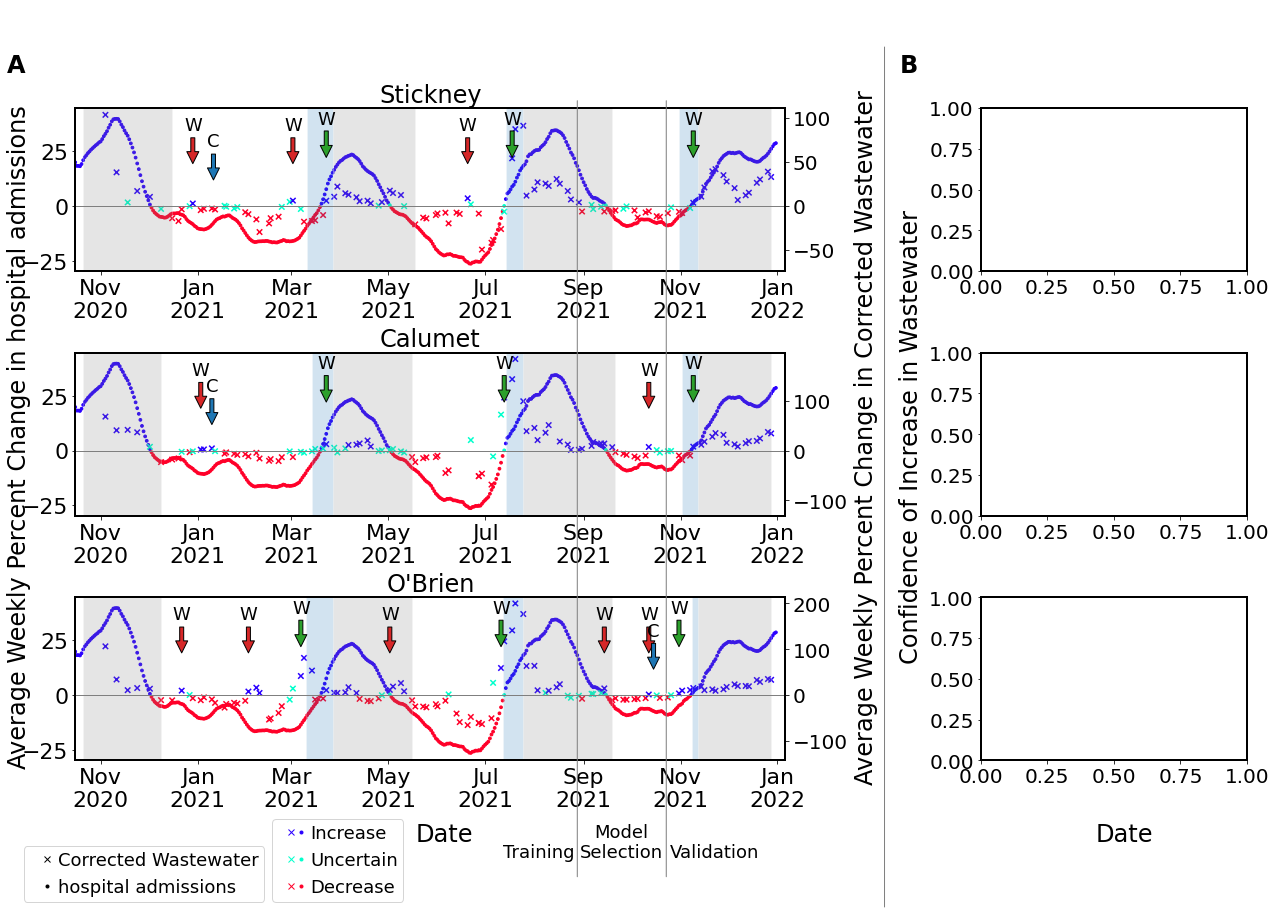

In [44]:
fs1 = 22 # tick labels
fs2 = 24 # axis labels
fs3 = 18 # legend
fs4 = 18 # flags
wws = usewwsnew[:2]    
num_weeks = num_weeks_ww
add_surge_arrows=False
add_surge_arrows2=False
n = 0
showdate = '2021-09-15'
datalabel = 'Corrected Wastewater'
# fig = plt.figure(figsize=(14,len(catches_shortlist)*3+1))
fig = plt.figure(figsize=(21,12))
gs = fig.add_gridspec(len(catches_shortlist), 2, wspace=.4, hspace=.5,width_ratios=[8,3])
axs = gs.subplots()
surgedf = pd.DataFrame(columns={'catchment','date','source','surge'})
for c, catch in enumerate(catches_shortlist):
    for m,usedata in enumerate([useprev_single,datatype]):
        mdf2 = fulldf[(fulldf.datatype==usedata) & (fulldf.catchment==catch)].copy()
        if m==0: # if we're doing the prevalence indicator, not the wastewater indicator...
            ax = axs[c,0]
            ax.scatter(mdf2.date,np.minimum(mdf2[f'Percent Change Weekly over {num_weeks} weeks'],200),\
                       c=mdf2[f'Confidence of {num_weeks} week Trend'].apply(lambda x:discrete_color(x)),\
                            s=30,cmap=newmap,marker='.')
            ax.set_title(catch.replace(' Full','').replace('OBrien',"O'Brien"),fontsize=fs2)
            ylim = ax.get_ylim()
            ax.set_ylim(-ylim[1]/1.5,ylim[1])
            ax.xaxis.set_tick_params(labelsize=fs1)
            ax.yaxis.set_tick_params(labelsize=fs1)
        else: # if we're doing a wastewater indicator
            ax = axs[c,0].twinx()
            sp = ax.scatter(mdf2.date,np.minimum(mdf2[f'Percent Change Weekly over {num_weeks} weeks'],200),\
                            c=mdf2[f'Confidence of {num_weeks} week Trend'].apply(lambda x:discrete_color(x)),\
                            s=30,cmap=newmap,marker='x')
            ax.axhline(y=0, xmin=0, xmax=1, color='tab:grey', linestyle='-', linewidth=1)
            ylim = ax.get_ylim()
            ax.set_ylim(-ylim[1]/1.5,ylim[1])
            ax.set_xbound(lower=mdates.date2num(datetime.datetime.strptime(firstdate, '%Y-%m-%d')-pd.Timedelta(5,'days')),\
                                 upper=mdates.date2num(datetime.datetime.strptime(lastdate, '%Y-%m-%d')+pd.Timedelta(5,'days')))
            if c==2: # if it's the first one, do this stuff so the first one has a legend.
                ax.plot(0,0,'x',color='black',label='Corrected Wastewater')
                ax.plot(0,0,'.',color='black',label=useprev_single.replace('sensitive admissions','Hospital Admissions'))
                l1 = ax.legend(bbox_to_anchor=(-0.08,-0.9),loc='lower left',fontsize=fs3,borderaxespad=.3,\
                               handletextpad=-.4,borderpad=.3)
                ax1 = ax
                p1, = ax1.plot(0,0,'x',color=newmap.colors[6])
                p2, = ax1.plot(0,0,'.',color=newmap.colors[6])
                p3, = ax1.plot(0,0,'x',color=newmap.colors[3])
                p4, = ax1.plot(0,0,'.',color=newmap.colors[3])
                p5, = ax1.plot(0,0,'x',color=newmap.colors[0])
                p6, = ax1.plot(0,0,'.',color=newmap.colors[0])
                ax.add_artist(l1)
                l = ax1.legend([(p1, p2), (p3, p4), (p5, p6)],\
                               ['Increase', 'Uncertain','Decrease'],\
                               handler_map={tuple: HandlerTuple(ndivide=None,pad=-.9)},borderaxespad=.3,\
                               bbox_to_anchor=(0.27,-0.9),loc='lower left',fontsize=fs3,handletextpad=-.2,borderpad=.3)
            # This is where we start ading the shaded regions and arrow flags, using fulldf and datedf information.
            date0 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata)].iloc[0].date
            date2 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==useprev_single) & 
                       (fulldf.date>date0.strftime('%Y-%m-%d')) & 
                       (fulldf[f'Confidence of {num_weeks} week Trend']<66)].iloc[0].date
            date3 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata) & 
                           (fulldf.date>=date2.strftime('%Y-%m-%d')) &
                           (fulldf[f'Confidence of {num_weeks} week Trend']<34)].iloc[0].date
            # This is the first grey area, from the first date to the "end" of that region.
            plt.axvspan(date0,date3, facecolor='tab:grey',edgecolor='white', alpha=.2)
            h = ax.get_ylim()
            # Now we'll loop over the flagged dates in the bedsused column.  These are the (three) major surges.
            numbeddates = len(datedf[catch+f' {useprevs_trendflags[-1]} {num_weeks}wk'].dropna())
            for d,mydateb in enumerate(datedf[catch+f' {useprevs_trendflags[-1]} {num_weeks}wk'].dropna()):
                surgedf = pd.concat([surgedf,pd.DataFrame({
                    'catchment':catch.replace(' Full',''),'date':mydateb.date(),
                    'source':useprevs_trendflags[-1].split(' ')[1],'surge':str(mydateb.date())+'-surge'},index=[0])],axis=0,ignore_index=True)
                if add_surge_arrows:
                    ax.annotate('B',xy=(mydateb, h[0]+(.68)*(h[1]-h[0])), xycoords='data',
                        xytext=(mydateb, h[0]+(.98)*(h[1]-h[0])), textcoords='data',
                        arrowprops=dict(facecolor=mycolors[8], shrink=0.05),
                        horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                # 3 prevalence columns to look at
                cols = ['date']+[catch+f' {pr} {num_weeks_prev}wk' for pr in useprevs_trendflags]
                df1 = datedf[cols].set_index('date').dropna(how='all').reset_index()
                # first date that is triggered in one of the prev columns that is 
                # less than 21 days before the beds date for the current surge.
                date1 = df1[df1.date+datetime.timedelta(days=21)>mydateb.strftime('%Y-%m-%d')].iloc[0].date
                # shade this region from that date to the beds date in blue.
                plt.axvspan(date1,mydateb, facecolor='tab:blue', edgecolor='white',alpha=.2)
                # Now 4 columns - the three prev columns plus the wastewater column.
                cols = ['date',catch+' '+usedata+f' {num_weeks}wk']+ [catch+f' {pr} {num_weeks_prev}wk' for pr in useprevs_trendflags]
                df1 = datedf[cols].set_index('date').dropna(how='all').reset_index()
                # Now this is the first date in all those columns, including ww, that is less than 21 days before the beds date.
                date1 = df1[df1.date+datetime.timedelta(days=21)>mydateb.strftime('%Y-%m-%d')].iloc[0].date
                # This is just dates that are after the the last date (from the previous surge) 
                # that sensitive admissions had an increase, 
                # but before the beginning of the next surge.  
                # So this will be dates where admissions or cases get shown, and where ww is shown with red.
#                     df2 = df1[(df1.date>date2) & (df1.date<date1)].copy()
                df2 = df1[(df1.date-datetime.timedelta(days=5)>date0) & (df1.date<date1)].copy()
                # Loop over wastewater dates where the date is within the range of associated with the surge, label green.
                for mydate in df1[(df1.date>=date1) & (df1.date-datetime.timedelta(days=5)<mydateb)][catch+' '+usedata+f' {num_weeks}wk'].dropna():
                    ax.annotate('W',xy=(mydate, h[0]+.69*(h[1]-h[0])), xycoords='data',
                        xytext=(mydate, h[0]+.99*(h[1]-h[0])), textcoords='data',
                        arrowprops=dict(facecolor='tab:green', shrink=0.04),
                        horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                    surgedf = pd.concat([surgedf,pd.DataFrame({
                        'catchment':catch.replace(' Full',''),'date':mydate.date(),
                        'source':'wastewater','surge':str(mydateb.date())+'-surge'},index=[0])],axis=0,ignore_index=True)
                # Loop over wastewater dates where the date is out of that range, label red.
                for mydate in df2[catch+' '+usedata+f' {num_weeks}wk'].dropna():
                    ax.annotate('W',xy=(mydate, h[0]+.65*(h[1]-h[0])), xycoords='data',
                        xytext=(mydate, h[0]+.95*(h[1]-h[0])), textcoords='data',
                        arrowprops=dict(facecolor='tab:red', shrink=0.05),
                        horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                    surgedf = pd.concat([surgedf,pd.DataFrame({
                        'catchment':catch.replace(' Full',''),'date':mydate.date(),
                        'source':'wastewater','surge':str(mydateb.date())+', pre:'+str(mydate.date())},
                        index=[0])],axis=0,ignore_index=True)
                # Loop over cases and admissions dates that are out of that range, label.
                for p,(mydat,ca) in enumerate(zip(useprevs_trendflags[:-1],plabs)):
                    for mydate in df2[catch+' '+mydat+f' {num_weeks}wk'].dropna():
                        ax.annotate(ca,xy=(mydate, h[0]+(.55-p*.1)*(h[1]-h[0])), xycoords='data',
                            xytext=(mydate, h[0]+(.85-p*.1)*(h[1]-h[0])), textcoords='data',
                            arrowprops=dict(facecolor=mycolors[p*4], shrink=0.05),
                            horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                        surgedf = pd.concat([surgedf,pd.DataFrame({
                            'catchment':catch.replace(' Full',''),'date':mydate.date(),
                            'source':mydat.split(' ')[1],'surge':str(mydateb.date())+', pre:'+str(mydate.date())},
                            index=[0])],axis=0,ignore_index=True)
                for p,(mydat,ca) in enumerate(zip(useprevs_trendflags[:-1],plabs)):
                    for mydate in df1[(df1.date>=date1) & (df1.date<mydateb)][catch+' '+mydat+' 4wk'].dropna():
                        if add_surge_arrows:
                            ax.annotate(ca,xy=(mydate, h[0]+(.55-p*.1)*(h[1]-h[0])), xycoords='data',
                                xytext=(mydate, h[0]+(.85-p*.1)*(h[1]-h[0])), textcoords='data',
                                arrowprops=dict(facecolor=mycolors[p*4+1], shrink=0.05),
                                horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                        surgedf = pd.concat([surgedf,pd.DataFrame({
                            'catchment':catch.replace(' Full',''),'date':mydate.date(),
                            'source':mydat.split(' ')[1],'surge':str(mydateb.date())+'-surge'},
                            index=[0])],axis=0,ignore_index=True)
                # Get the range for the next gray band.
                if d<numbeddates-1:
                    date2 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==useprev_single) & 
                               (fulldf.date>mydateb.strftime('%Y-%m-%d')) & 
                               (fulldf[f'Confidence of {num_weeks} week Trend']<66)].iloc[0].date
                    date3 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata) & 
                                   (fulldf.date>=date2.strftime('%Y-%m-%d')) &
                                   (fulldf[f'Confidence of {num_weeks} week Trend']<34)].iloc[0].date
                    plt.axvspan(mydateb,date3, facecolor='tab:grey',edgecolor='white', alpha=.2)
                    date0 = mydateb
                else:
                    date2 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata)].iloc[-1].date
                    date3 = date2
#                     plt.axvline(x=mydateb, color='white')
                    plt.axvspan(mydateb,date3, facecolor='tab:grey', edgecolor='white',alpha=.2)
#                     print(catch,date1,mydateb,date2,date3)
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
            ax.xaxis.set_major_formatter(DateFormatter("%b\n%Y"))
            ax.set_xbound(lower=mdates.date2num(datetime.datetime.strptime(firstdate, '%Y-%m-%d')+pd.Timedelta(15,'days')),\
                                 upper=mdates.date2num(datetime.datetime.strptime(lastdate, '%Y-%m-%d')+pd.Timedelta(5,'days')))
    if c==2:
        ylim = ax.get_ylim()
        for d,align in zip(['2021-08-28','2021-10-23'],['right','right']):
            ax.annotate('', xy = (pd.to_datetime(d, format = '%Y-%m-%d'), 0), xycoords='data',
                        xytext = (pd.to_datetime(d, format = '%Y-%m-%d'), -400), textcoords='data',
                        arrowprops=dict(arrowstyle="-",color='tab:grey'),
                        horizontalalignment='left', verticalalignment='top',fontsize=16)
            ax.annotate('', xy = (pd.to_datetime(d, format = '%Y-%m-%d'), 0), xycoords='data',
                        xytext = (pd.to_datetime(d, format = '%Y-%m-%d'), 1300), textcoords='data',
                        arrowprops=dict(arrowstyle="-",color='tab:grey'),
                        horizontalalignment='left', verticalalignment='top',fontsize=16)
    #         ax.annotate(datetime.datetime.strftime(pd.to_datetime(d,format = '%Y-%m-%d'),'%m/%d'), 
    #                 xy = (pd.to_datetime(d, format = '%Y-%m-%d'), ylim[-1]*.65), xycoords='data',
    #                 xytext = (pd.to_datetime(d, format = '%Y-%m-%d'), ylim[-1]*.65), textcoords='data',
    #                 horizontalalignment=align, verticalalignment='top',fontsize=12,rotation='vertical')
        for d,txt,align,vert,vert2 in zip(['2021-08-26','2021-09-25','2021-10-25'],
                               ['\n\n\n\nTraining','\n\n\nModel\nSelection','\n\n\n\nValidation'],
                               ['right','center','left'],[ylim[0]*.95,ylim[0]*.95,ylim[0]*.95],['top','top','top']):
            ax.annotate(txt,xy = (pd.to_datetime(d, format = '%Y-%m-%d'), ylim[0]), xycoords='data',
                    xytext = (pd.to_datetime(d, format = '%Y-%m-%d'), ylim[0]), textcoords='data',
                    horizontalalignment=align, verticalalignment=vert2,fontsize=fs3,rotation='horizontal')
        
fig.text(0.35, 0.04, 'Date', va='center', rotation='horizontal',fontsize=fs2)
fig.text(0.8, 0.04, 'Date', va='center', rotation='horizontal',fontsize=fs2)
fig.text(0.08, 0.5, 'Average Weekly Percent Change in '+useprev_single.replace('sensitive admissions','Hospital Admissions'), va='center', rotation='vertical',fontsize=fs2)
fig.text(0.64, 0.5, 'Average Weekly Percent Change in '+datalabel, va='center', rotation='vertical',fontsize=fs2)
fig.text(0.67, 0.5, 'Confidence of Increase in Wastewater', va='center', rotation='vertical',fontsize=fs2)
fig.text(0.08, 0.93, 'A', va='center', rotation='horizontal',fontsize=fs2,weight='bold')
fig.text(0.67, 0.93, 'B', va='center', rotation='horizontal',fontsize=fs2,weight='bold')
plt.annotate('', xy = (0.585, 1), xycoords='figure fraction',
                    xytext = (0.585, 0), textcoords='figure fraction',
                    arrowprops=dict(arrowstyle="-",color='tab:grey') )
plt.show()


In [45]:
surgedf.source = surgedf.source.replace('County','bedsused').replace('tests','cases')
surgedf.loc[(surgedf.catchment=='Calumet') & (surgedf.surge=='2021-03-27, pre:2021-01-11'),'surge'] = '2021-03-27, pre:2021-01-03'
surgedf.loc[(surgedf.catchment=='OBrien') & (surgedf.surge=='2021-11-12, pre:2021-09-20'),'surge'] = '2021-11-12, pre:2021-09-14'
surgedf.loc[(surgedf.catchment=='OBrien') & (surgedf.surge=='2021-11-12, pre:2021-10-12'),'surge'] = '2021-11-12, pre:2021-10-16'
surgedf.loc[(surgedf.catchment=='Stickney') & (surgedf.surge=='2021-03-27, pre:2021-01-12'),'surge'] = '2021-03-27, pre:2020-12-29'
newsurgedf = FormatDatesNicely(surgedf)
display(newsurgedf[['catchment','wastewater','cases','admissions','bedsused']])


Wastewater leads admissions in 4 surges by up to 13 days, and lags admissions in 5 surges by up to 4 days.
Cases leads admissions in 6 surges by up to 10 days, and lags admissions in 2 surges by up to 0 days.
Beds-in-use lags admissions in all surges by 4 to 11 days.

Wastewater leads cases in 3 surges by up to 3 days, and lags cases in 5 surges by up to 12 days.
Wastewater leads beds-in-use in all surges by 3 to 20 days.


source catchment  wastewater       cases  admissions    bedsused
0        Calumet  2021-01-03         NaN         NaN         NaN
1        Calumet         NaN  2021-01-10         NaN         NaN
2        Calumet  2021-03-23  2021-03-14  2021-03-20  2021-03-27
3        Calumet  2021-07-13  2021-07-14  2021-07-14  2021-07-25
4        Calumet  2021-10-12         NaN         NaN         NaN
5        Calumet  2021-11-09  2021-11-02  2021-11-08  2021-11-12
6         OBrien  2020-12-22         NaN         NaN         NaN
7         OBrien  2021-02-02         NaN         NaN         NaN
8         OBrien  2021-03-07  2021-03-10  2021-03-20  2021-03-27
9         OBrien  2021-05-02         NaN         NaN         NaN
10        OBrien  2021-07-11  2021-07-12  2021-07-14  2021-07-25
11        OBrien  2021-09-14         NaN         NaN         NaN
12        OBrien         NaN  2021-10-15         NaN         NaN
13        OBrien  2021-10-12         NaN         NaN         NaN
14        OBrien  2021-10-31         NaN  2021-11-08  2021-11-12
15      Stickney  2020-12-29         NaN         NaN         NaN
16      Stickney         NaN  2021-01-11         NaN         NaN
17      Stickney  2021-03-02         NaN         NaN         NaN
18      Stickney  2021-03-23  2021-03-11  2021-03-20  2021-03-27
19      Stickney  2021-06-20         NaN         NaN         NaN
20      Stickney  2021-07-18  2021-07-14  2021-07-14  2021-07-25
21      Stickney  2021-11-09  2021-10-31  2021-11-08  2021-11-12

In [46]:
surgebcov = surgedf.copy()

#### Trained to beds, no flow, lag = -1

In [47]:
lag = -1
useprev_single = 'Cook County beds in use'
datatype = 'pmmov_bcov_norm'
usewws = ['orig-raw_data',datatype]
wbe1 = pd.read_csv(wbefile, parse_dates=['date'])
wbe1.rename(columns={'wrp':'catchment','sarscov2':'raw_data'},inplace=True)
wbe1 = CalculateModelFitsFromParams(wbe1,paramdf,ww_lod,wwtp,lag,useprev_single)

In [48]:
fulldf = rolling_trend_analysis(wbe1,prevdf,catches_shortlist,useprevs_trendflags,usewws,
                                firstdate,lastdate,num_weeks_ww,num_weeks_prev,showfig=False)
datedf = trend_trajectory(fulldf,catches_shortlist,useprevs_trendflags,usewws,prev_CI,ww_CI,
                          prev_daythresh,ww_daythresh,num_weeks_ww,firstdate,lastdate,showfig=False)

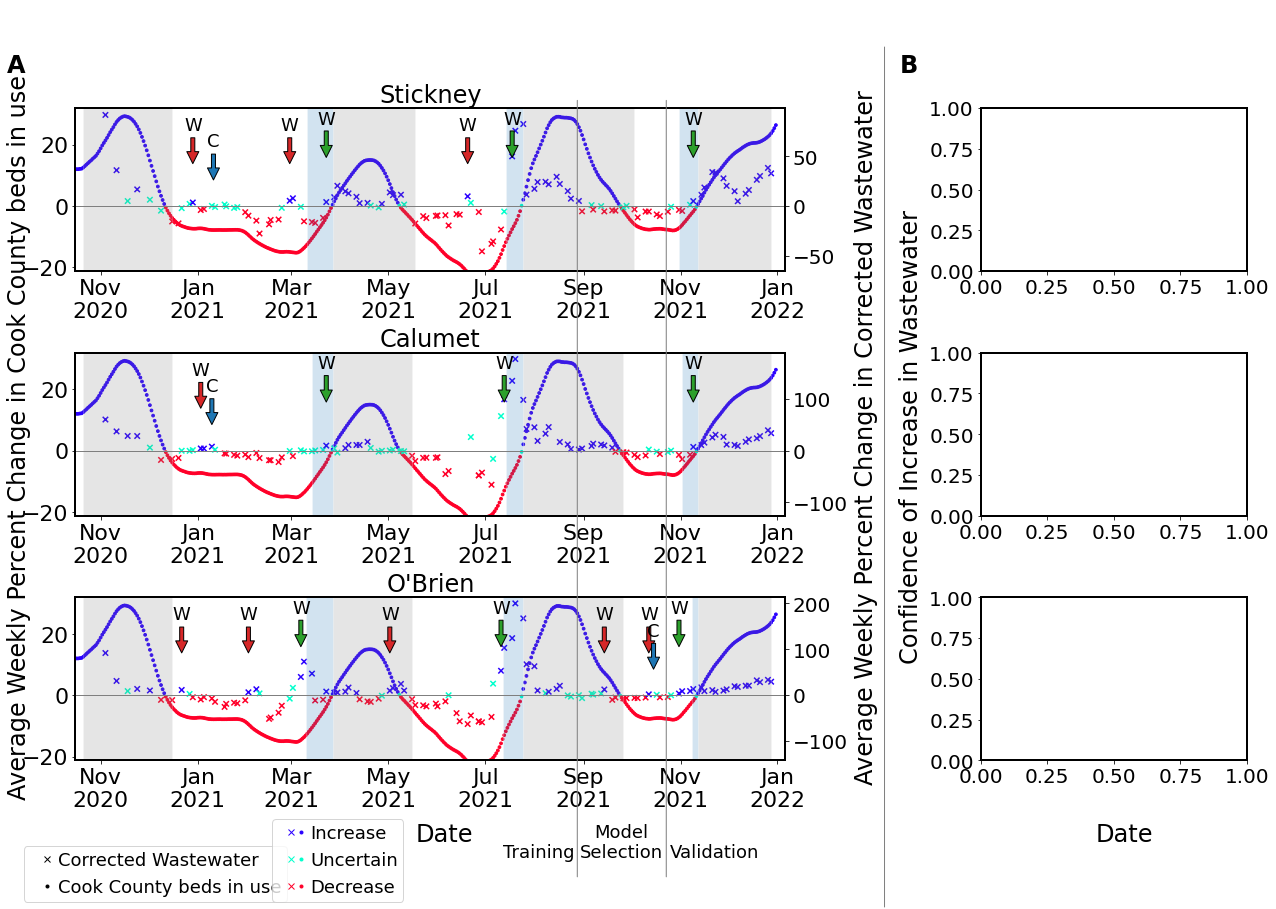

In [49]:
fs1 = 22 # tick labels
fs2 = 24 # axis labels
fs3 = 18 # legend
fs4 = 18 # flags
wws = usewwsnew[:2]    
num_weeks = num_weeks_ww
add_surge_arrows=False
add_surge_arrows2=False
n = 0
showdate = '2021-09-15'
datalabel = 'Corrected Wastewater'
# fig = plt.figure(figsize=(14,len(catches_shortlist)*3+1))
fig = plt.figure(figsize=(21,12))
gs = fig.add_gridspec(len(catches_shortlist), 2, wspace=.4, hspace=.5,width_ratios=[8,3])
axs = gs.subplots()
surgedf = pd.DataFrame(columns={'catchment','date','source','surge'})
for c, catch in enumerate(catches_shortlist):
    for m,usedata in enumerate([useprev_single,datatype]):
        mdf2 = fulldf[(fulldf.datatype==usedata) & (fulldf.catchment==catch)].copy()
        if m==0: # if we're doing the prevalence indicator, not the wastewater indicator...
            ax = axs[c,0]
            ax.scatter(mdf2.date,np.minimum(mdf2[f'Percent Change Weekly over {num_weeks} weeks'],200),\
                       c=mdf2[f'Confidence of {num_weeks} week Trend'].apply(lambda x:discrete_color(x)),\
                            s=30,cmap=newmap,marker='.')
            ax.set_title(catch.replace(' Full','').replace('OBrien',"O'Brien"),fontsize=fs2)
            ylim = ax.get_ylim()
            ax.set_ylim(-ylim[1]/1.5,ylim[1])
            ax.xaxis.set_tick_params(labelsize=fs1)
            ax.yaxis.set_tick_params(labelsize=fs1)
        else: # if we're doing a wastewater indicator
            ax = axs[c,0].twinx()
            sp = ax.scatter(mdf2.date,np.minimum(mdf2[f'Percent Change Weekly over {num_weeks} weeks'],200),\
                            c=mdf2[f'Confidence of {num_weeks} week Trend'].apply(lambda x:discrete_color(x)),\
                            s=30,cmap=newmap,marker='x')
            ax.axhline(y=0, xmin=0, xmax=1, color='tab:grey', linestyle='-', linewidth=1)
            ylim = ax.get_ylim()
            ax.set_ylim(-ylim[1]/1.5,ylim[1])
            ax.set_xbound(lower=mdates.date2num(datetime.datetime.strptime(firstdate, '%Y-%m-%d')-pd.Timedelta(5,'days')),\
                                 upper=mdates.date2num(datetime.datetime.strptime(lastdate, '%Y-%m-%d')+pd.Timedelta(5,'days')))
            if c==2: # if it's the first one, do this stuff so the first one has a legend.
                ax.plot(0,0,'x',color='black',label='Corrected Wastewater')
                ax.plot(0,0,'.',color='black',label=useprev_single.replace('sensitive admissions','Hospital Admissions'))
                l1 = ax.legend(bbox_to_anchor=(-0.08,-0.9),loc='lower left',fontsize=fs3,borderaxespad=.3,\
                               handletextpad=-.4,borderpad=.3)
                ax1 = ax
                p1, = ax1.plot(0,0,'x',color=newmap.colors[6])
                p2, = ax1.plot(0,0,'.',color=newmap.colors[6])
                p3, = ax1.plot(0,0,'x',color=newmap.colors[3])
                p4, = ax1.plot(0,0,'.',color=newmap.colors[3])
                p5, = ax1.plot(0,0,'x',color=newmap.colors[0])
                p6, = ax1.plot(0,0,'.',color=newmap.colors[0])
                ax.add_artist(l1)
                l = ax1.legend([(p1, p2), (p3, p4), (p5, p6)],\
                               ['Increase', 'Uncertain','Decrease'],\
                               handler_map={tuple: HandlerTuple(ndivide=None,pad=-.9)},borderaxespad=.3,\
                               bbox_to_anchor=(0.27,-0.9),loc='lower left',fontsize=fs3,handletextpad=-.2,borderpad=.3)
            # This is where we start ading the shaded regions and arrow flags, using fulldf and datedf information.
            date0 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata)].iloc[0].date
            date2 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==useprev_single) & 
                       (fulldf.date>date0.strftime('%Y-%m-%d')) & 
                       (fulldf[f'Confidence of {num_weeks} week Trend']<66)].iloc[0].date
            date3 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata) & 
                           (fulldf.date>=date2.strftime('%Y-%m-%d')) &
                           (fulldf[f'Confidence of {num_weeks} week Trend']<34)].iloc[0].date
            # This is the first grey area, from the first date to the "end" of that region.
            plt.axvspan(date0,date3, facecolor='tab:grey',edgecolor='white', alpha=.2)
            h = ax.get_ylim()
            # Now we'll loop over the flagged dates in the bedsused column.  These are the (three) major surges.
            numbeddates = len(datedf[catch+f' {useprevs_trendflags[-1]} {num_weeks}wk'].dropna())
            for d,mydateb in enumerate(datedf[catch+f' {useprevs_trendflags[-1]} {num_weeks}wk'].dropna()):
                surgedf = pd.concat([surgedf,pd.DataFrame({
                    'catchment':catch.replace(' Full',''),'date':mydateb.date(),
                    'source':useprevs_trendflags[-1].split(' ')[1],'surge':str(mydateb.date())+'-surge'},index=[0])],axis=0,ignore_index=True)
                if add_surge_arrows:
                    ax.annotate('B',xy=(mydateb, h[0]+(.68)*(h[1]-h[0])), xycoords='data',
                        xytext=(mydateb, h[0]+(.98)*(h[1]-h[0])), textcoords='data',
                        arrowprops=dict(facecolor=mycolors[8], shrink=0.05),
                        horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                # 3 prevalence columns to look at
                cols = ['date']+[catch+f' {pr} {num_weeks_prev}wk' for pr in useprevs_trendflags]
                df1 = datedf[cols].set_index('date').dropna(how='all').reset_index()
                # first date that is triggered in one of the prev columns that is 
                # less than 21 days before the beds date for the current surge.
                date1 = df1[df1.date+datetime.timedelta(days=21)>mydateb.strftime('%Y-%m-%d')].iloc[0].date
                # shade this region from that date to the beds date in blue.
                plt.axvspan(date1,mydateb, facecolor='tab:blue', edgecolor='white',alpha=.2)
                # Now 4 columns - the three prev columns plus the wastewater column.
                cols = ['date',catch+' '+usedata+f' {num_weeks}wk']+ [catch+f' {pr} {num_weeks_prev}wk' for pr in useprevs_trendflags]
                df1 = datedf[cols].set_index('date').dropna(how='all').reset_index()
                # Now this is the first date in all those columns, including ww, that is less than 21 days before the beds date.
                date1 = df1[df1.date+datetime.timedelta(days=21)>mydateb.strftime('%Y-%m-%d')].iloc[0].date
                # This is just dates that are after the the last date (from the previous surge) 
                # that sensitive admissions had an increase, 
                # but before the beginning of the next surge.  
                # So this will be dates where admissions or cases get shown, and where ww is shown with red.
#                     df2 = df1[(df1.date>date2) & (df1.date<date1)].copy()
                df2 = df1[(df1.date-datetime.timedelta(days=5)>date0) & (df1.date<date1)].copy()
                # Loop over wastewater dates where the date is within the range of associated with the surge, label green.
                for mydate in df1[(df1.date>=date1) & (df1.date-datetime.timedelta(days=5)<mydateb)][catch+' '+usedata+f' {num_weeks}wk'].dropna():
                    ax.annotate('W',xy=(mydate, h[0]+.69*(h[1]-h[0])), xycoords='data',
                        xytext=(mydate, h[0]+.99*(h[1]-h[0])), textcoords='data',
                        arrowprops=dict(facecolor='tab:green', shrink=0.04),
                        horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                    surgedf = pd.concat([surgedf,pd.DataFrame({
                        'catchment':catch.replace(' Full',''),'date':mydate.date(),
                        'source':'wastewater','surge':str(mydateb.date())+'-surge'},index=[0])],axis=0,ignore_index=True)
                # Loop over wastewater dates where the date is out of that range, label red.
                for mydate in df2[catch+' '+usedata+f' {num_weeks}wk'].dropna():
                    ax.annotate('W',xy=(mydate, h[0]+.65*(h[1]-h[0])), xycoords='data',
                        xytext=(mydate, h[0]+.95*(h[1]-h[0])), textcoords='data',
                        arrowprops=dict(facecolor='tab:red', shrink=0.05),
                        horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                    surgedf = pd.concat([surgedf,pd.DataFrame({
                        'catchment':catch.replace(' Full',''),'date':mydate.date(),
                        'source':'wastewater','surge':str(mydateb.date())+', pre:'+str(mydate.date())},
                        index=[0])],axis=0,ignore_index=True)
                # Loop over cases and admissions dates that are out of that range, label.
                for p,(mydat,ca) in enumerate(zip(useprevs_trendflags[:-1],plabs)):
                    for mydate in df2[catch+' '+mydat+f' {num_weeks}wk'].dropna():
                        ax.annotate(ca,xy=(mydate, h[0]+(.55-p*.1)*(h[1]-h[0])), xycoords='data',
                            xytext=(mydate, h[0]+(.85-p*.1)*(h[1]-h[0])), textcoords='data',
                            arrowprops=dict(facecolor=mycolors[p*4], shrink=0.05),
                            horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                        surgedf = pd.concat([surgedf,pd.DataFrame({
                            'catchment':catch.replace(' Full',''),'date':mydate.date(),
                            'source':mydat.split(' ')[1],'surge':str(mydateb.date())+', pre:'+str(mydate.date())},
                            index=[0])],axis=0,ignore_index=True)
                for p,(mydat,ca) in enumerate(zip(useprevs_trendflags[:-1],plabs)):
                    for mydate in df1[(df1.date>=date1) & (df1.date<mydateb)][catch+' '+mydat+' 4wk'].dropna():
                        if add_surge_arrows:
                            ax.annotate(ca,xy=(mydate, h[0]+(.55-p*.1)*(h[1]-h[0])), xycoords='data',
                                xytext=(mydate, h[0]+(.85-p*.1)*(h[1]-h[0])), textcoords='data',
                                arrowprops=dict(facecolor=mycolors[p*4+1], shrink=0.05),
                                horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                        surgedf = pd.concat([surgedf,pd.DataFrame({
                            'catchment':catch.replace(' Full',''),'date':mydate.date(),
                            'source':mydat.split(' ')[1],'surge':str(mydateb.date())+'-surge'},
                            index=[0])],axis=0,ignore_index=True)
                # Get the range for the next gray band.
                if d<numbeddates-1:
                    date2 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==useprev_single) & 
                               (fulldf.date>mydateb.strftime('%Y-%m-%d')) & 
                               (fulldf[f'Confidence of {num_weeks} week Trend']<66)].iloc[0].date
                    date3 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata) & 
                                   (fulldf.date>=date2.strftime('%Y-%m-%d')) &
                                   (fulldf[f'Confidence of {num_weeks} week Trend']<34)].iloc[0].date
                    plt.axvspan(mydateb,date3, facecolor='tab:grey',edgecolor='white', alpha=.2)
                    date0 = mydateb
                else:
                    date2 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata)].iloc[-1].date
                    date3 = date2
#                     plt.axvline(x=mydateb, color='white')
                    plt.axvspan(mydateb,date3, facecolor='tab:grey', edgecolor='white',alpha=.2)
#                     print(catch,date1,mydateb,date2,date3)
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
            ax.xaxis.set_major_formatter(DateFormatter("%b\n%Y"))
            ax.set_xbound(lower=mdates.date2num(datetime.datetime.strptime(firstdate, '%Y-%m-%d')+pd.Timedelta(15,'days')),\
                                 upper=mdates.date2num(datetime.datetime.strptime(lastdate, '%Y-%m-%d')+pd.Timedelta(5,'days')))
    if c==2:
        ylim = ax.get_ylim()
        for d,align in zip(['2021-08-28','2021-10-23'],['right','right']):
            ax.annotate('', xy = (pd.to_datetime(d, format = '%Y-%m-%d'), 0), xycoords='data',
                        xytext = (pd.to_datetime(d, format = '%Y-%m-%d'), -400), textcoords='data',
                        arrowprops=dict(arrowstyle="-",color='tab:grey'),
                        horizontalalignment='left', verticalalignment='top',fontsize=16)
            ax.annotate('', xy = (pd.to_datetime(d, format = '%Y-%m-%d'), 0), xycoords='data',
                        xytext = (pd.to_datetime(d, format = '%Y-%m-%d'), 1300), textcoords='data',
                        arrowprops=dict(arrowstyle="-",color='tab:grey'),
                        horizontalalignment='left', verticalalignment='top',fontsize=16)
    #         ax.annotate(datetime.datetime.strftime(pd.to_datetime(d,format = '%Y-%m-%d'),'%m/%d'), 
    #                 xy = (pd.to_datetime(d, format = '%Y-%m-%d'), ylim[-1]*.65), xycoords='data',
    #                 xytext = (pd.to_datetime(d, format = '%Y-%m-%d'), ylim[-1]*.65), textcoords='data',
    #                 horizontalalignment=align, verticalalignment='top',fontsize=12,rotation='vertical')
        for d,txt,align,vert,vert2 in zip(['2021-08-26','2021-09-25','2021-10-25'],
                               ['\n\n\n\nTraining','\n\n\nModel\nSelection','\n\n\n\nValidation'],
                               ['right','center','left'],[ylim[0]*.95,ylim[0]*.95,ylim[0]*.95],['top','top','top']):
            ax.annotate(txt,xy = (pd.to_datetime(d, format = '%Y-%m-%d'), ylim[0]), xycoords='data',
                    xytext = (pd.to_datetime(d, format = '%Y-%m-%d'), ylim[0]), textcoords='data',
                    horizontalalignment=align, verticalalignment=vert2,fontsize=fs3,rotation='horizontal')
        
fig.text(0.35, 0.04, 'Date', va='center', rotation='horizontal',fontsize=fs2)
fig.text(0.8, 0.04, 'Date', va='center', rotation='horizontal',fontsize=fs2)
fig.text(0.08, 0.5, 'Average Weekly Percent Change in '+useprev_single.replace('sensitive admissions','Hospital Admissions'), va='center', rotation='vertical',fontsize=fs2)
fig.text(0.64, 0.5, 'Average Weekly Percent Change in '+datalabel, va='center', rotation='vertical',fontsize=fs2)
fig.text(0.67, 0.5, 'Confidence of Increase in Wastewater', va='center', rotation='vertical',fontsize=fs2)
fig.text(0.08, 0.93, 'A', va='center', rotation='horizontal',fontsize=fs2,weight='bold')
fig.text(0.67, 0.93, 'B', va='center', rotation='horizontal',fontsize=fs2,weight='bold')
plt.annotate('', xy = (0.585, 1), xycoords='figure fraction',
                    xytext = (0.585, 0), textcoords='figure fraction',
                    arrowprops=dict(arrowstyle="-",color='tab:grey') )
plt.show()


In [50]:
surgedf.loc[(surgedf.catchment=='Calumet') & (surgedf.surge=='2021-03-27, pre:2021-01-11'),'surge'] = '2021-03-27, pre:2021-01-03'
surgedf.loc[(surgedf.catchment=='OBrien') & (surgedf.surge=='2021-11-12, pre:2021-09-20'),'surge'] = '2021-11-12, pre:2021-09-14'
surgedf.loc[(surgedf.catchment=='OBrien') & (surgedf.surge=='2021-11-12, pre:2021-10-16'),'surge'] = '2021-11-12, pre:2021-10-12'
surgedf.loc[(surgedf.catchment=='Stickney') & (surgedf.surge=='2021-03-27, pre:2021-01-12'),'surge'] = '2021-03-27, pre:2020-12-29'
surgedf.source = surgedf.source.replace('County','bedsused').replace('tests','cases')
newsurgedf = FormatDatesNicely(surgedf)
display(newsurgedf[['catchment','wastewater','cases','admissions','bedsused']])


Wastewater leads admissions in 4 surges by up to 13 days, and lags admissions in 5 surges by up to 4 days.
Cases leads admissions in 6 surges by up to 10 days, and lags admissions in 2 surges by up to 0 days.
Beds-in-use lags admissions in all surges by 4 to 11 days.

Wastewater leads cases in 3 surges by up to 3 days, and lags cases in 5 surges by up to 12 days.
Wastewater leads beds-in-use in all surges by 3 to 20 days.


source catchment  wastewater       cases  admissions    bedsused
0        Calumet  2021-01-03         NaN         NaN         NaN
1        Calumet         NaN  2021-01-10         NaN         NaN
2        Calumet  2021-03-23  2021-03-14  2021-03-20  2021-03-27
3        Calumet  2021-07-13  2021-07-14  2021-07-14  2021-07-25
4        Calumet  2021-11-09  2021-11-02  2021-11-08  2021-11-12
5         OBrien  2020-12-22         NaN         NaN         NaN
6         OBrien  2021-02-02         NaN         NaN         NaN
7         OBrien  2021-03-07  2021-03-10  2021-03-20  2021-03-27
8         OBrien  2021-05-02         NaN         NaN         NaN
9         OBrien  2021-07-11  2021-07-12  2021-07-14  2021-07-25
10        OBrien  2021-09-14         NaN         NaN         NaN
11        OBrien  2021-10-12         NaN         NaN         NaN
12        OBrien         NaN  2021-10-15         NaN         NaN
13        OBrien  2021-10-31         NaN  2021-11-08  2021-11-12
14      Stickney  2020-12-29         NaN         NaN         NaN
15      Stickney         NaN  2021-01-11         NaN         NaN
16      Stickney  2021-02-28         NaN         NaN         NaN
17      Stickney  2021-03-23  2021-03-11  2021-03-20  2021-03-27
18      Stickney  2021-06-20         NaN         NaN         NaN
19      Stickney  2021-07-18  2021-07-14  2021-07-14  2021-07-25
20      Stickney  2021-11-09  2021-10-31  2021-11-08  2021-11-12

In [51]:
surgebeds = surgedf.copy()

#### Raw Uncorrected Data

In [52]:
lag = 3
useprev_single = 'hospital admissions'
datatype = 'orig-raw_data'
usewws = ['raw_data',datatype]

In [53]:
fulldf = rolling_trend_analysis(wbe,prevdf,catches_shortlist,useprevs_trendflags,usewws,
                                firstdate,lastdate,num_weeks_ww,num_weeks_prev,showfig=False)
datedf = trend_trajectory(fulldf,catches_shortlist,useprevs_trendflags,usewws,prev_CI,ww_CI,
                          prev_daythresh,ww_daythresh,num_weeks_ww,firstdate,lastdate,showfig=False)

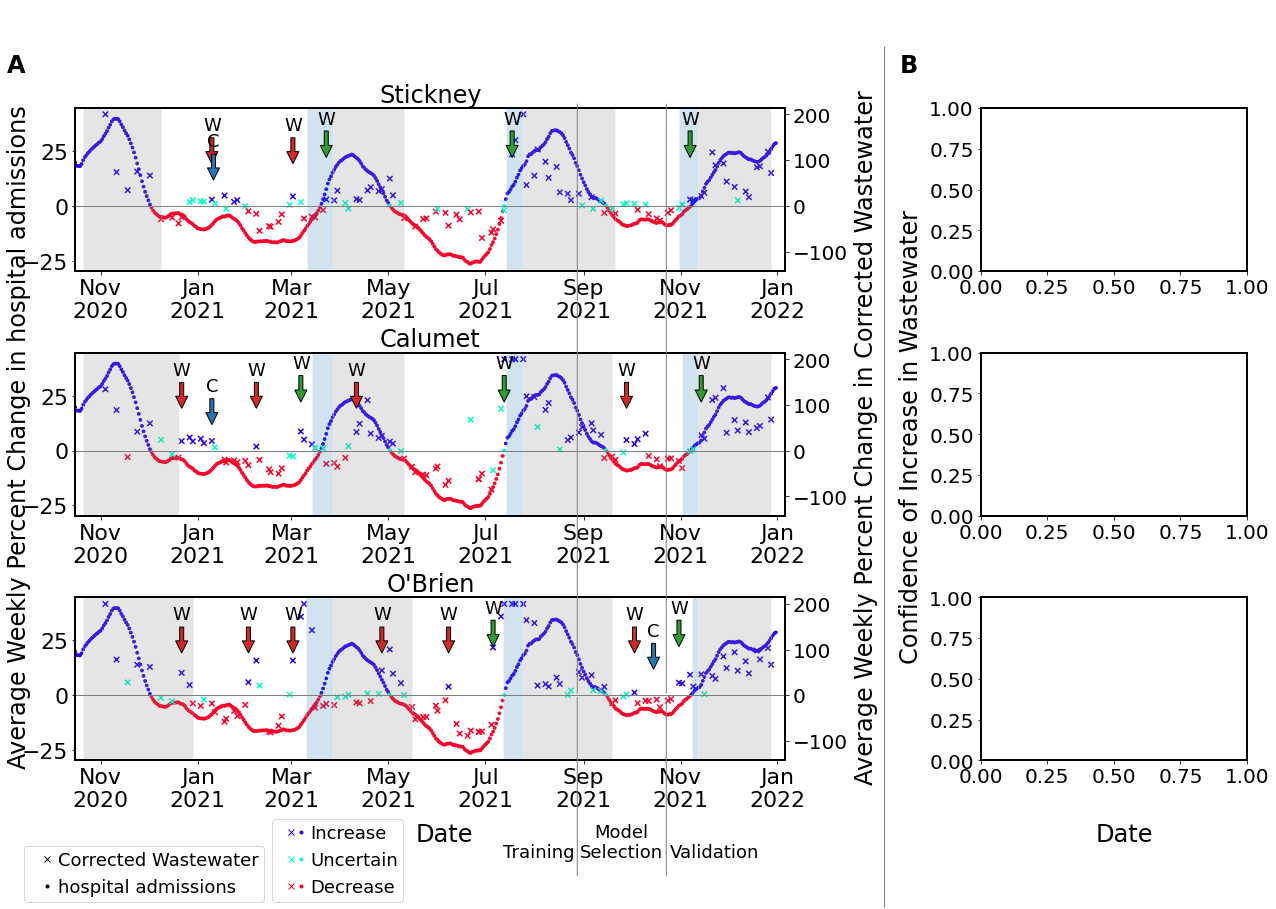

In [54]:
fs1 = 22 # tick labels
fs2 = 24 # axis labels
fs3 = 18 # legend
fs4 = 18 # flags
wws = usewwsnew[:2]    
num_weeks = num_weeks_ww
add_surge_arrows=False
add_surge_arrows2=False
n = 0
showdate = '2021-09-15'
datalabel = 'Corrected Wastewater'
# fig = plt.figure(figsize=(14,len(catches_shortlist)*3+1))
fig = plt.figure(figsize=(21,12))
gs = fig.add_gridspec(len(catches_shortlist), 2, wspace=.4, hspace=.5,width_ratios=[8,3])
axs = gs.subplots()
surgedf = pd.DataFrame(columns={'catchment','date','source','surge'})
for c, catch in enumerate(catches_shortlist):
    for m,usedata in enumerate([useprev_single,datatype]):
        mdf2 = fulldf[(fulldf.datatype==usedata) & (fulldf.catchment==catch)].copy()
        if m==0: # if we're doing the prevalence indicator, not the wastewater indicator...
            ax = axs[c,0]
            ax.scatter(mdf2.date,np.minimum(mdf2[f'Percent Change Weekly over {num_weeks} weeks'],200),\
                       c=mdf2[f'Confidence of {num_weeks} week Trend'].apply(lambda x:discrete_color(x)),\
                            s=30,cmap=newmap,marker='.')
            ax.set_title(catch.replace(' Full','').replace('OBrien',"O'Brien"),fontsize=fs2)
            ylim = ax.get_ylim()
            ax.set_ylim(-ylim[1]/1.5,ylim[1])
            ax.xaxis.set_tick_params(labelsize=fs1)
            ax.yaxis.set_tick_params(labelsize=fs1)
        else: # if we're doing a wastewater indicator
            ax = axs[c,0].twinx()
            sp = ax.scatter(mdf2.date,np.minimum(mdf2[f'Percent Change Weekly over {num_weeks} weeks'],200),\
                            c=mdf2[f'Confidence of {num_weeks} week Trend'].apply(lambda x:discrete_color(x)),\
                            s=30,cmap=newmap,marker='x')
            ax.axhline(y=0, xmin=0, xmax=1, color='tab:grey', linestyle='-', linewidth=1)
            ylim = ax.get_ylim()
            ax.set_ylim(-ylim[1]/1.5,ylim[1])
            ax.set_xbound(lower=mdates.date2num(datetime.datetime.strptime(firstdate, '%Y-%m-%d')-pd.Timedelta(5,'days')),\
                                 upper=mdates.date2num(datetime.datetime.strptime(lastdate, '%Y-%m-%d')+pd.Timedelta(5,'days')))
            if c==2: # if it's the first one, do this stuff so the first one has a legend.
                ax.plot(0,0,'x',color='black',label='Corrected Wastewater')
                ax.plot(0,0,'.',color='black',label=useprev_single.replace('sensitive admissions','Hospital Admissions'))
                l1 = ax.legend(bbox_to_anchor=(-0.08,-0.9),loc='lower left',fontsize=fs3,borderaxespad=.3,\
                               handletextpad=-.4,borderpad=.3)
                ax1 = ax
                p1, = ax1.plot(0,0,'x',color=newmap.colors[6])
                p2, = ax1.plot(0,0,'.',color=newmap.colors[6])
                p3, = ax1.plot(0,0,'x',color=newmap.colors[3])
                p4, = ax1.plot(0,0,'.',color=newmap.colors[3])
                p5, = ax1.plot(0,0,'x',color=newmap.colors[0])
                p6, = ax1.plot(0,0,'.',color=newmap.colors[0])
                ax.add_artist(l1)
                l = ax1.legend([(p1, p2), (p3, p4), (p5, p6)],\
                               ['Increase', 'Uncertain','Decrease'],\
                               handler_map={tuple: HandlerTuple(ndivide=None,pad=-.9)},borderaxespad=.3,\
                               bbox_to_anchor=(0.27,-0.9),loc='lower left',fontsize=fs3,handletextpad=-.2,borderpad=.3)
            # This is where we start ading the shaded regions and arrow flags, using fulldf and datedf information.
            date0 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata)].iloc[0].date
            date2 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==useprev_single) & 
                       (fulldf.date>date0.strftime('%Y-%m-%d')) & 
                       (fulldf[f'Confidence of {num_weeks} week Trend']<66)].iloc[0].date
            date3 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata) & 
                           (fulldf.date>=date2.strftime('%Y-%m-%d')) &
                           (fulldf[f'Confidence of {num_weeks} week Trend']<34)].iloc[0].date
            # This is the first grey area, from the first date to the "end" of that region.
            plt.axvspan(date0,date3, facecolor='tab:grey',edgecolor='white', alpha=.2)
            h = ax.get_ylim()
            # Now we'll loop over the flagged dates in the bedsused column.  These are the (three) major surges.
            numbeddates = len(datedf[catch+f' {useprevs_trendflags[-1]} {num_weeks}wk'].dropna())
            for d,mydateb in enumerate(datedf[catch+f' {useprevs_trendflags[-1]} {num_weeks}wk'].dropna()):
                surgedf = pd.concat([surgedf,pd.DataFrame({
                    'catchment':catch.replace(' Full',''),'date':mydateb.date(),
                    'source':useprevs_trendflags[-1].split(' ')[1],'surge':str(mydateb.date())+'-surge'},index=[0])],axis=0,ignore_index=True)
                if add_surge_arrows:
                    ax.annotate('B',xy=(mydateb, h[0]+(.68)*(h[1]-h[0])), xycoords='data',
                        xytext=(mydateb, h[0]+(.98)*(h[1]-h[0])), textcoords='data',
                        arrowprops=dict(facecolor=mycolors[8], shrink=0.05),
                        horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                # 3 prevalence columns to look at
                cols = ['date']+[catch+f' {pr} {num_weeks_prev}wk' for pr in useprevs_trendflags]
                df1 = datedf[cols].set_index('date').dropna(how='all').reset_index()
                # first date that is triggered in one of the prev columns that is 
                # less than 21 days before the beds date for the current surge.
                date1 = df1[df1.date+datetime.timedelta(days=21)>mydateb.strftime('%Y-%m-%d')].iloc[0].date
                # shade this region from that date to the beds date in blue.
                plt.axvspan(date1,mydateb, facecolor='tab:blue', edgecolor='white',alpha=.2)
                # Now 4 columns - the three prev columns plus the wastewater column.
                cols = ['date',catch+' '+usedata+f' {num_weeks}wk']+ [catch+f' {pr} {num_weeks_prev}wk' for pr in useprevs_trendflags]
                df1 = datedf[cols].set_index('date').dropna(how='all').reset_index()
                # Now this is the first date in all those columns, including ww, that is less than 21 days before the beds date.
                date1 = df1[df1.date+datetime.timedelta(days=21)>mydateb.strftime('%Y-%m-%d')].iloc[0].date
                # This is just dates that are after the the last date (from the previous surge) 
                # that sensitive admissions had an increase, 
                # but before the beginning of the next surge.  
                # So this will be dates where admissions or cases get shown, and where ww is shown with red.
#                     df2 = df1[(df1.date>date2) & (df1.date<date1)].copy()
                df2 = df1[(df1.date-datetime.timedelta(days=5)>date0) & (df1.date<date1)].copy()
                # Loop over wastewater dates where the date is within the range of associated with the surge, label green.
                for mydate in df1[(df1.date>=date1) & (df1.date-datetime.timedelta(days=5)<mydateb)][catch+' '+usedata+f' {num_weeks}wk'].dropna():
                    ax.annotate('W',xy=(mydate, h[0]+.69*(h[1]-h[0])), xycoords='data',
                        xytext=(mydate, h[0]+.99*(h[1]-h[0])), textcoords='data',
                        arrowprops=dict(facecolor='tab:green', shrink=0.04),
                        horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                    surgedf = pd.concat([surgedf,pd.DataFrame({
                        'catchment':catch.replace(' Full',''),'date':mydate.date(),
                        'source':'wastewater','surge':str(mydateb.date())+'-surge'},index=[0])],axis=0,ignore_index=True)
                # Loop over wastewater dates where the date is out of that range, label red.
                for mydate in df2[catch+' '+usedata+f' {num_weeks}wk'].dropna():
                    ax.annotate('W',xy=(mydate, h[0]+.65*(h[1]-h[0])), xycoords='data',
                        xytext=(mydate, h[0]+.95*(h[1]-h[0])), textcoords='data',
                        arrowprops=dict(facecolor='tab:red', shrink=0.05),
                        horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                    surgedf = pd.concat([surgedf,pd.DataFrame({
                        'catchment':catch.replace(' Full',''),'date':mydate.date(),
                        'source':'wastewater','surge':str(mydateb.date())+', pre:'+str(mydate.date())},
                        index=[0])],axis=0,ignore_index=True)
                # Loop over cases and admissions dates that are out of that range, label.
                for p,(mydat,ca) in enumerate(zip(useprevs_trendflags[:-1],plabs)):
                    for mydate in df2[catch+' '+mydat+f' {num_weeks}wk'].dropna():
                        ax.annotate(ca,xy=(mydate, h[0]+(.55-p*.1)*(h[1]-h[0])), xycoords='data',
                            xytext=(mydate, h[0]+(.85-p*.1)*(h[1]-h[0])), textcoords='data',
                            arrowprops=dict(facecolor=mycolors[p*4], shrink=0.05),
                            horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                        surgedf = pd.concat([surgedf,pd.DataFrame({
                            'catchment':catch.replace(' Full',''),'date':mydate.date(),
                            'source':mydat.split(' ')[1],'surge':str(mydateb.date())+', pre:'+str(mydate.date())},
                            index=[0])],axis=0,ignore_index=True)
                for p,(mydat,ca) in enumerate(zip(useprevs_trendflags[:-1],plabs)):
                    for mydate in df1[(df1.date>=date1) & (df1.date<mydateb)][catch+' '+mydat+' 4wk'].dropna():
                        if add_surge_arrows:
                            ax.annotate(ca,xy=(mydate, h[0]+(.55-p*.1)*(h[1]-h[0])), xycoords='data',
                                xytext=(mydate, h[0]+(.85-p*.1)*(h[1]-h[0])), textcoords='data',
                                arrowprops=dict(facecolor=mycolors[p*4+1], shrink=0.05),
                                horizontalalignment='center', verticalalignment='top',fontsize=fs4)
                        surgedf = pd.concat([surgedf,pd.DataFrame({
                            'catchment':catch.replace(' Full',''),'date':mydate.date(),
                            'source':mydat.split(' ')[1],'surge':str(mydateb.date())+'-surge'},
                            index=[0])],axis=0,ignore_index=True)
                # Get the range for the next gray band.
                if d<numbeddates-1:
                    date2 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==useprev_single) & 
                               (fulldf.date>mydateb.strftime('%Y-%m-%d')) & 
                               (fulldf[f'Confidence of {num_weeks} week Trend']<66)].iloc[0].date
                    date3 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata) & 
                                   (fulldf.date>=date2.strftime('%Y-%m-%d')) &
                                   (fulldf[f'Confidence of {num_weeks} week Trend']<34)].iloc[0].date
                    plt.axvspan(mydateb,date3, facecolor='tab:grey',edgecolor='white', alpha=.2)
                    date0 = mydateb
                else:
                    date2 = fulldf[(fulldf.catchment==catch) & (fulldf.datatype==usedata)].iloc[-1].date
                    date3 = date2
#                     plt.axvline(x=mydateb, color='white')
                    plt.axvspan(mydateb,date3, facecolor='tab:grey', edgecolor='white',alpha=.2)
#                     print(catch,date1,mydateb,date2,date3)
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
            ax.xaxis.set_major_formatter(DateFormatter("%b\n%Y"))
            ax.set_xbound(lower=mdates.date2num(datetime.datetime.strptime(firstdate, '%Y-%m-%d')+pd.Timedelta(15,'days')),\
                                 upper=mdates.date2num(datetime.datetime.strptime(lastdate, '%Y-%m-%d')+pd.Timedelta(5,'days')))
    if c==2:
        ylim = ax.get_ylim()
        for d,align in zip(['2021-08-28','2021-10-23'],['right','right']):
            ax.annotate('', xy = (pd.to_datetime(d, format = '%Y-%m-%d'), 0), xycoords='data',
                        xytext = (pd.to_datetime(d, format = '%Y-%m-%d'), -400), textcoords='data',
                        arrowprops=dict(arrowstyle="-",color='tab:grey'),
                        horizontalalignment='left', verticalalignment='top',fontsize=16)
            ax.annotate('', xy = (pd.to_datetime(d, format = '%Y-%m-%d'), 0), xycoords='data',
                        xytext = (pd.to_datetime(d, format = '%Y-%m-%d'), 1300), textcoords='data',
                        arrowprops=dict(arrowstyle="-",color='tab:grey'),
                        horizontalalignment='left', verticalalignment='top',fontsize=16)
    #         ax.annotate(datetime.datetime.strftime(pd.to_datetime(d,format = '%Y-%m-%d'),'%m/%d'), 
    #                 xy = (pd.to_datetime(d, format = '%Y-%m-%d'), ylim[-1]*.65), xycoords='data',
    #                 xytext = (pd.to_datetime(d, format = '%Y-%m-%d'), ylim[-1]*.65), textcoords='data',
    #                 horizontalalignment=align, verticalalignment='top',fontsize=12,rotation='vertical')
        for d,txt,align,vert,vert2 in zip(['2021-08-26','2021-09-25','2021-10-25'],
                               ['\n\n\n\nTraining','\n\n\nModel\nSelection','\n\n\n\nValidation'],
                               ['right','center','left'],[ylim[0]*.95,ylim[0]*.95,ylim[0]*.95],['top','top','top']):
            ax.annotate(txt,xy = (pd.to_datetime(d, format = '%Y-%m-%d'), ylim[0]), xycoords='data',
                    xytext = (pd.to_datetime(d, format = '%Y-%m-%d'), ylim[0]), textcoords='data',
                    horizontalalignment=align, verticalalignment=vert2,fontsize=fs3,rotation='horizontal')
        
fig.text(0.35, 0.04, 'Date', va='center', rotation='horizontal',fontsize=fs2)
fig.text(0.8, 0.04, 'Date', va='center', rotation='horizontal',fontsize=fs2)
fig.text(0.08, 0.5, 'Average Weekly Percent Change in '+useprev_single.replace('sensitive admissions','Hospital Admissions'), va='center', rotation='vertical',fontsize=fs2)
fig.text(0.64, 0.5, 'Average Weekly Percent Change in '+datalabel, va='center', rotation='vertical',fontsize=fs2)
fig.text(0.67, 0.5, 'Confidence of Increase in Wastewater', va='center', rotation='vertical',fontsize=fs2)
fig.text(0.08, 0.93, 'A', va='center', rotation='horizontal',fontsize=fs2,weight='bold')
fig.text(0.67, 0.93, 'B', va='center', rotation='horizontal',fontsize=fs2,weight='bold')
plt.annotate('', xy = (0.585, 1), xycoords='figure fraction',
                    xytext = (0.585, 0), textcoords='figure fraction',
                    arrowprops=dict(arrowstyle="-",color='tab:grey') )
plt.show()


In [55]:
surgedf.loc[(surgedf.catchment=='Calumet') & (surgedf.surge=='2021-03-27, pre:2020-12-22'),'surge'] = '2021-03-27, pre:2021-01-11'
surgedf.loc[(surgedf.catchment=='OBrien') & (surgedf.surge=='2021-03-27, pre:2021-03-02'),'surge'] = '2021-03-27-surge'
surgedf.loc[(surgedf.catchment=='OBrien') & (surgedf.surge=='2021-11-12, pre:2021-10-03'),'surge'] = '2021-11-12, pre:2021-10-16'
surgedf.loc[(surgedf.catchment=='Stickney') & (surgedf.surge=='2021-03-27, pre:2021-01-10'),'surge'] = '2021-03-27, pre:2021-01-12'
surgedf.source = surgedf.source.replace('County','bedsused').replace('tests','cases')
newsurgedf = FormatDatesNicely(surgedf)
display(newsurgedf[['catchment','wastewater','cases','admissions','bedsused']])


Wastewater leads admissions in 6 surges by up to 18 days, and lags admissions in 3 surges by up to 6 days.
Cases leads admissions in 6 surges by up to 10 days, and lags admissions in 2 surges by up to 0 days.
Beds-in-use lags admissions in all surges by 4 to 11 days.

Wastewater leads cases in 4 surges by up to 8 days, and lags cases in 4 surges by up to 12 days.
Wastewater leads beds-in-use in all surges by -2 to 25 days.


source catchment  wastewater       cases  admissions    bedsused
0        Calumet         NaN  2021-01-10         NaN         NaN
1        Calumet  2020-12-22         NaN         NaN         NaN
2        Calumet  2021-02-07         NaN         NaN         NaN
3        Calumet  2021-03-07  2021-03-14  2021-03-20  2021-03-27
4        Calumet  2021-04-11         NaN         NaN         NaN
5        Calumet  2021-07-13  2021-07-14  2021-07-14  2021-07-25
6        Calumet  2021-09-28         NaN         NaN         NaN
7        Calumet  2021-11-14  2021-11-02  2021-11-08  2021-11-12
8         OBrien  2020-12-22         NaN         NaN         NaN
9         OBrien  2021-02-02         NaN         NaN         NaN
10        OBrien  2021-03-02  2021-03-10  2021-03-20  2021-03-27
11        OBrien  2021-04-27         NaN         NaN         NaN
12        OBrien  2021-06-08         NaN         NaN         NaN
13        OBrien  2021-07-06  2021-07-12  2021-07-14  2021-07-25
14        OBrien         NaN  2021-10-15         NaN         NaN
15        OBrien  2021-10-03         NaN         NaN         NaN
16        OBrien  2021-10-31         NaN  2021-11-08  2021-11-12
17      Stickney         NaN  2021-01-11         NaN         NaN
18      Stickney  2021-01-10         NaN         NaN         NaN
19      Stickney  2021-03-02         NaN         NaN         NaN
20      Stickney  2021-03-23  2021-03-11  2021-03-20  2021-03-27
21      Stickney  2021-07-18  2021-07-14  2021-07-14  2021-07-25
22      Stickney  2021-11-07  2021-10-31  2021-11-08  2021-11-12

In [56]:
surgeraw = surgedf.copy()

In [57]:
keys = ['noflow','full','bcov','fit2beds','raw','cases','admits','beds']
surgeall = pd.concat([surgebest[surgebest.source=='wastewater'],surgefull[surgefull.source=='wastewater'],
                     surgebcov[surgebcov.source=='wastewater'],surgebeds[surgebeds.source=='wastewater'],
                     surgeraw[surgeraw.source=='wastewater'],surgebest[surgebest.source=='cases'],
                      surgebest[surgebest.source=='admissions'],surgebest[surgebest.source=='bedsused']],
                     axis=0, keys=keys).reset_index(level=[0])
surgeall['source'] = surgeall['level_0']
surgeall.drop(columns='level_0',inplace=True)
surgeall.info()
surgeall.source.unique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120 entries, 1 to 42
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   surge      120 non-null    object
 1   date       120 non-null    object
 2   catchment  120 non-null    object
 3   source     120 non-null    object
dtypes: object(4)
memory usage: 4.7+ KB


array(['noflow', 'full', 'bcov', 'fit2beds', 'raw', 'cases', 'admits',
       'beds'], dtype=object)

In [58]:
surgeall.loc[(surgeall.catchment=='Calumet') & (surgeall.surge=='2021-03-27, pre:2021-01-11'),'surge'] = '2021-03-27, pre:2021-01-03'
surgeall.loc[(surgeall.catchment=='Calumet') & (surgeall.surge=='2021-07-25, pre:2021-04-06'),'surge'] = '2021-07-25, pre:2021-04-11'
surgeall.loc[(surgeall.catchment=='Calumet') & (surgeall.surge=='2021-11-12, pre:2021-09-28'),'surge'] = '2021-11-12, pre:2021-10-12'
surgeall.loc[(surgeall.catchment=='OBrien') & (surgeall.surge=='2021-03-27, pre:2021-02-07'),'surge'] = '2021-03-27, pre:2021-02-02'
surgeall.loc[(surgeall.catchment=='OBrien') & (surgeall.surge=='2021-07-25, pre:2021-04-27'),'surge'] = '2021-07-25, pre:2021-05-02'
surgeall.loc[(surgeall.catchment=='OBrien') & (surgeall.surge=='2021-11-12, pre:2021-10-12'),'surge'] = '2021-11-12, pre:2021-10-16'
surgeall.loc[(surgeall.catchment=='Stickney') & (surgeall.surge=='2021-03-27, pre:2021-01-10'),'surge'] = '2021-03-27, pre:2020-12-29'
surgeall.loc[(surgeall.catchment=='Stickney') & (surgeall.surge=='2021-03-27, pre:2021-01-12'),'surge'] = '2021-03-27, pre:2020-12-29'
surgeall.loc[(surgeall.catchment=='Stickney') & (surgeall.surge=='2021-03-27, pre:2021-02-28'),'surge'] = '2021-03-27, pre:2021-03-02'
surgeall.loc[(surgeall.catchment=='Stickney') & (surgeall.surge=='2021-07-25, pre:2021-04-27'),'surge'] = '2021-07-25, pre:2021-05-02'

newsurgedf = surgeall.pivot(index=['catchment','surge'],columns=['source'],values=['date'])['date'].reset_index()
newsurgedf.sort_values(by=['catchment','surge'],inplace=True)
newsurgedf = newsurgedf[['catchment']+keys[:-3]+['surge']]
display(newsurgedf[['catchment']+keys[:-3]].set_index('catchment'))

source         noflow        full        bcov    fit2beds         raw
catchment                                                            
Calumet    2021-01-03  2021-01-03  2021-01-03  2021-01-03  2020-12-22
Calumet           NaN         NaN         NaN         NaN         NaN
Calumet           NaN         NaN         NaN         NaN  2021-02-07
Calumet    2021-03-23  2021-03-23  2021-03-23  2021-03-23  2021-03-07
Calumet           NaN         NaN         NaN         NaN  2021-04-11
Calumet    2021-07-13  2021-07-13  2021-07-13  2021-07-13  2021-07-13
Calumet           NaN         NaN  2021-10-12         NaN  2021-09-28
Calumet    2021-11-09  2021-11-14  2021-11-09  2021-11-09  2021-11-14
OBrien     2020-12-22  2020-12-22  2020-12-22  2020-12-22  2020-12-22
OBrien     2021-02-02  2021-02-07  2021-02-02  2021-02-02  2021-02-02
OBrien     2021-03-07  2021-03-07  2021-03-07  2021-03-07  2021-03-02
OBrien     2021-05-02  2021-05-02  2021-05-02  2021-05-02  2021-04-27
OBrien            NaN         NaN         NaN         NaN  2021-06-08
OBrien     2021-07-11  2021-07-11  2021-07-11  2021-07-11  2021-07-06
OBrien     2021-09-14  2021-09-14  2021-09-14  2021-09-14         NaN
OBrien            NaN         NaN         NaN         NaN         NaN
OBrien     2021-10-12         NaN  2021-10-12  2021-10-12  2021-10-03
OBrien            NaN  2021-11-02  2021-10-31  2021-10-31  2021-10-31
Stickney   2020-12-29  2021-01-10  2020-12-29  2020-12-29  2021-01-10
Stickney          NaN         NaN         NaN         NaN         NaN
Stickney   2021-02-28         NaN  2021-03-02  2021-02-28  2021-03-02
Stickney   2021-03-28  2021-03-23  2021-03-23  2021-03-23  2021-03-23
Stickney   2021-05-02         NaN         NaN         NaN         NaN
Stickney   2021-06-20  2021-06-20  2021-06-20  2021-06-20         NaN
Stickney   2021-07-18  2021-07-18  2021-07-18  2021-07-18  2021-07-18
Stickney   2021-11-07  2021-11-14  2021-11-09  2021-11-09  2021-11-07